In [3]:
%matplotlib notebook
import os
import numpy as np
import sys
import json
import pickle
import h5py
# import skbio
import time
import pandas as pd
import torch
import edlib

import evaluate_v2
import seaborn as sns 
import matplotlib.pyplot as plt
from data_preprocess import DNA_SEGMENT_LENGTH, SEQUENCING_ERROR_RATE
from train import align_accuracy
from argparse import ArgumentParser
from spoa import poa
from tqdm import tqdm
from Levenshtein import distance
from p_tqdm import p_map
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

In [2]:
dataset_dict = {

    
    'nanopore': './dataset_nanopore.hdf5',  # v2
}

In [3]:
model_dict = {
    'nanopore': {
       
        'v2': {
            "all": './model/nanopore.pth',
        }
    }
}

In [4]:
gpu = 5
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [5]:
def plot_msa_heatmap(msa):
    """
    Plots a heatmap of a multiple sequence alignment (MSA).

    Parameters:
    ----------
    msa : List[str]
        A list of aligned sequences containing only 'A', 'C', 'G', 'T', and '-'.
        All strings must be of equal length.
    """
    if not msa:
        raise ValueError("MSA input is empty.")

    # Validate input consistency
    seq_length = len(msa[0])
    if any(len(seq) != seq_length for seq in msa):
        raise ValueError("All sequences in MSA must have the same length.")

    # Map characters to integers
    base_to_int = {'A': 0, 'C': 1, 'G': 2, 'T': 3, '-': 4}
    int_to_base = ['A', 'C', 'G', 'T', '-']

    # Convert to numeric matrix
    try:
        msa_matrix = np.array([[base_to_int[char] for char in row] for row in msa])
    except KeyError as e:
        raise ValueError(f"Invalid character '{e.args[0]}' in MSA. Only A, C, G, T, and '-' are allowed.")

    # Dynamically determine a readable figure size
    num_seqs = len(msa)
    num_cols = seq_length

    # Each cell should have enough pixels to be visible but not too large
    cell_width = 0.15   # width per base (x-axis)
    cell_height = 0.15  # height per sequence (y-axis)

    max_width = 30  # limit max figure width in inches
    max_height = 20 # limit max figure height in inches

    fig_width = min(max_width, cell_width * num_cols)
    fig_height = min(max_height, cell_height * num_seqs)

    # Plot heatmap
    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.heatmap(msa_matrix, cmap='viridis', cbar_kws={'ticks': [0, 1, 2, 3, 4]})
    plt.title('MSA Heatmap')
    plt.xlabel('Alignment Position')
    plt.ylabel('Sequence Index')

    # Set colorbar labels
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticklabels(int_to_base)

    plt.tight_layout()
    plt.show()

In [6]:
def obtain_align_result(query, target, return_nice=False, verbose=True):
    dis = distance(query, target)
    result = edlib.align(query, target, task = "path")
    nice = edlib.getNiceAlignment(result, query, target)
    if verbose:
        print('query(up)-target(bottom)-alignment:')
        print("\n".join(nice.values()))
    
    if return_nice:
        return dis, nice
    
    return dis

In [7]:
def consensus_prob_visual(probs):
    plt.figure(figsize=(12, 4))
    sns.heatmap(probs.T, cmap="viridis", cbar=True,  # xticklabels=False, 
                yticklabels=['A', 'C', 'G', 'T'])
    plt.xlabel("Token index")
    plt.ylabel("Vocabulary index")
    plt.title("Probability distribution heatmap")
    plt.show()

In [8]:
def plot(df):
    plt.figure()
    a_df = df[['depth', 'poa']].rename(columns={'poa': 'correct ratio(%)'})
    b_df = df[['depth', 'new']].rename(columns={'new': 'correct ratio(%)'})
    c_df = df[['depth', 'bs']].rename(columns={'bs': 'correct ratio(%)'})
    a_df['method'] = 'poa'
    b_df['method'] = 'new'
    c_df['method'] = 'bs'
    merge_df = pd.concat([a_df, b_df, c_df])
    sns.barplot(data=merge_df, x='depth', y='correct ratio(%)', hue='method')
    plt.legend(loc='best', bbox_to_anchor=[1, 1])
    plt.tight_layout()

In [9]:
# def vote_consensus(msa):
#     msa = skbio.TabularMSA([skbio.DNA(s) for s in msa])
#     return str(msa.consensus()).replace('-', '')

def vote_consensus(msa):
    # Convert to NumPy array of shape (num_seqs, seq_len)
    arr = np.array([list(seq) for seq in msa])
    
    consensus = []
    for col in arr.T:  # iterate over columns
        # Count each base
        unique, counts = np.unique(col, return_counts=True)
        # Choose the one with the highest count (break ties by lexicographic order)
        consensus.append(unique[np.argmax(counts)])
    
    return ''.join(consensus).replace('-', '')

In [10]:
def bsalign_process_v2(seqs, file_dir, file_idx):
    bsalign_exe_path = './dna_storage_bench_tools/Reconstruction/bsalign/bsalign'
    if not os.path.exists(file_dir):
        os.makedirs(file_dir)
    
    fasta_path = os.path.join(file_dir, f"{file_idx}.fasta")
    consensus_path = os.path.join(file_dir, f"{file_idx}.consensus")
    alignment_path = os.path.join(file_dir, f"{file_idx}.alignment")

    with open(fasta_path, 'w') as test_f:
        for s_id, s in enumerate(seqs):
            test_f.write(f'>{s_id}\n{s}\n')

    _ = os.system(
        f'{bsalign_exe_path} poa {fasta_path} -o {consensus_path} -L > {alignment_path}'
    )

    with open(alignment_path) as f:
        msa = [
            line.strip().split(' ')[3].upper().replace('.', '-')
            for line in f.readlines()[2: 2 + len(seqs)]
        ]
        
        cns = vote_consensus(msa)

    os.remove(fasta_path)
    os.remove(consensus_path)
    os.remove(alignment_path)
    return file_idx, msa, cns


def bsalign_process_parallel(data, file_dir):
    data_list = [(item['seqs'], file_dir, cluster) for (cluster, item) in data.items()]
    results = p_map(lambda kv: bsalign_process_v2(kv[0], kv[1], kv[2]), data_list, num_cpus=72)
    return dict([(k, msa) for k, msa, cns in results]), dict([(k, cns) for k, msa, cns in results])

In [11]:
def bmala_consensus_process(idx, seqs, dump_ref_len):
    _exe = './dna_storage_bench_tools/Reconstruction/BMALA/BMALA'
    _out_path = f'./dna_storage_bench_tools/bmala_out/{idx}'
    if not os.path.exists(_out_path):
        os.makedirs(_out_path)
    file_path = os.path.join(_out_path, 'test.fa')
    dump_ref = 'A' * dump_ref_len
    with open(file_path, 'w') as test_f:
        test_f.write(f'{dump_ref}\n****\n')
        for s_id, s in enumerate(seqs):
            test_f.write(f'{s}\n')
        test_f.write('\n\n')
    
    _ = os.system(
        f'{_exe} {file_path} {_out_path} > /dev/null'
    )
    
    with open(os.path.join(_out_path, 'output-results-fail.txt'), 'r') as f:
        ret = f.readlines()[2].strip()
    
    return ret, idx


def bmala_consensus_parallel(data_dict):
    args = data_dict
    
    results = p_map(lambda kv: bmala_consensus_process(kv[0], kv[1], kv[2]), args, num_cpus=72)

    return dict([(k, val) for val, k in results])

In [12]:
def itr_consensus_process(record_idx, cluster_idx, seqs, dump_ref_len):
    itr_exe = './dna_storage_bench_tools/Reconstruction/Iterative/DNA'
    itr_out_path = f'./dna_storage_bench_tools/itr_out/{record_idx}_{cluster_idx}'
    if not os.path.exists(itr_out_path):
        os.makedirs(itr_out_path)
    file_path = os.path.join(itr_out_path, 'test.fa')
    dump_ref = 'A' * dump_ref_len
    with open(file_path, 'w') as test_f:
        test_f.write(f'{dump_ref}\n****\n')
        for s_id, s in enumerate(seqs):
            test_f.write(f'{s}\n')
        test_f.write('\n\n')
    
    _ = os.system(
        f'{itr_exe} {file_path} {itr_out_path} > /dev/null'
    )
    
    with open(os.path.join(itr_out_path , 'output-results-fail.txt'), 'r') as f:
        ret = f.readlines()[2].strip()
        
    return ret, record_idx, cluster_idx


def itr_consensus_parallel(data_dict):
    args = data_dict
    
    results = p_map(lambda kv: itr_consensus_process(kv[0], kv[1], kv[2], kv[3]), args, num_cpus=72)

    return [(a, b, c) for a, b, c in results]

In [13]:
# # unified parallel algorithm 
# def unified_consensns_process(record_idx, cluster_idx, seqs, dump_ref_len, algorithm):
#     exe_db = {
#         # poa, bsalign, itr, bmala, 
#         'xx': 'path'
#     }[algorithm]
    
#     # .... 
    
#     return msa, cns, record_idx, cluster_idx  # msa can be None


# def unified_consensus_parallel(data_dict, algorithm):
    
#     # ... results 
#     return [(a,b,c,d) for a,b,c,d in results]

In [14]:
"""
bsalign 默认用 Global alignment + Vote consensus generation;
POA     默认用 Local alignment (algorithm=0), 算法接口输出的consensus和手动Vote生成的没有区别
其他算法用默认设置, ITR 算法效率最低必须多线程计算. 
"""

def test(
    sequencing_type,
    model_version,
    model_depth,
    batch_size,
    min_depth,
    max_depth,
    epochs,
    qual_vocab_size,
    context_len,
    decode_len,
    record_st=0,
    poa_method='global',
    poa_use_vote=True,
    use_bsalign=True,
    bsalign_out_dir=None,
    skip_itr=False,
):
    poa_algorithm_id = {
        'local'      : 0,
        'global'     : 1,
        'semi_global': 2,
    }[poa_method]
    
    if model_version == 'v1':
        predictor = evaluate.ConsensusPredictor(
            model_path=model_dict[sequencing_type][model_version],
            qual_vocab_size=qual_vocab_size,
            context_len=context_len,
            decode_len=decode_len,
            max_depth=max_depth,
            batch_size=batch_size,
            gpu=gpu,
        )
    else:
        predictor = evaluate_v2.ConsensusPredictor(
            model_path=model_dict[sequencing_type][model_version][model_depth],
            qual_vocab_size=qual_vocab_size,
            context_len=context_len,
#             decode_len=decode_len,
            max_depth=max_depth,
            batch_size=batch_size,
            gpu=gpu,
        )

    data = h5py.File(dataset_dict[sequencing_type])
    
    rng = np.random.default_rng(seed=42)
    total_record_indices = np.arange(len(data.keys()))
    rng.shuffle(total_record_indices) 
    valid_size = len(data.keys()) - int(len(data.keys()) * 0.75)
    valid_record_indices = total_record_indices[-valid_size:]
    print('valid_size:', valid_size)
    
    seqs  = []
    quals = []
    refs  = []
    
    for valid_idx in valid_record_indices:
        seqs.append(data[str(valid_idx)]['seqs'])
        quals.append(data[str(valid_idx)]['quals'])
        refs.append(data[str(valid_idx)]['refs'])
    
    num_records = len(seqs) 
    if epochs is not None:
        num_records = min(num_records, epochs)
     
    ret_dict = []
    for record_idx in tqdm(range(record_st, num_records)):
        batched_data = {}
        runtime_data = {}
        curr_ref = refs[record_idx][0].decode('ascii')
        # curr_len = lens[record_idx]
        for depth in range(min_depth, max_depth + 1):
            cluster_id = f"D{depth}"
            batched_data[cluster_id] = {
                'refs' : curr_ref, 
                'seqs' : [s.decode('ascii') for s in  seqs[record_idx][np.arange(depth)]], 
                'quals': [s.decode('ascii') for s in quals[record_idx][np.arange(depth)]],
            }
        
        clock_st = time.time()
        bs_msa_dict, bs_cns_dict = bsalign_process_parallel(batched_data, bsalign_out_dir)
        clock_en = time.time()
        runtime_data['bs'] = (clock_en - clock_st)
        
        clock_st = time.time()
        bmala_out = bmala_consensus_parallel([
            (cluster, item['seqs'], decode_len) 
            for cluster, item in batched_data.items()
        ])
        clock_en = time.time()
        runtime_data['bmala'] = (clock_en - clock_st)
        
        clock_st = time.time()
        if model_version == 'v1':
            output = predictor.predict(
                batched_data,
                use_bsalign=use_bsalign,
                bsalign_out_dir=bsalign_out_dir,
            )
        else:
            output = predictor.predict(
                batched_data, 
                bs_msa_dict, 
            )
        clock_en = time.time()
        runtime_data['new']   = (clock_en - clock_st)
        
        runtime_data['poa']   = 0
        for cluster in batched_data.keys():
            clock_st = time.time()
            poa_cns, poa_msa_list = poa(batched_data[cluster]['seqs'], algorithm=poa_algorithm_id)
            if poa_use_vote:
                output[cluster]['poa_consensus'] = vote_consensus(poa_msa_list)
            else:
                output[cluster]['poa_consensus'] = poa_cns
            clock_en = time.time()
            runtime_data['poa'] += (clock_en - clock_st)
            
            output[cluster]['bs_consensus']    = bs_cns_dict[cluster]
            output[cluster]['bmala_consensus'] = bmala_out[cluster]
            output[cluster]['poa_dis']   = distance(batched_data[cluster]['refs'], output[cluster]['poa_consensus'])
            output[cluster]['new_dis']   = distance(batched_data[cluster]['refs'], output[cluster]['new_consensus'])
            output[cluster]['bs_dis']    = distance(batched_data[cluster]['refs'], output[cluster]['bs_consensus'])
            output[cluster]['bmala_dis'] = distance(batched_data[cluster]['refs'], output[cluster]['bmala_consensus'])
            
        ret_dict.append((batched_data, output, runtime_data))
    
    if not skip_itr:
        _itr_process_dat = []
        for record_idx in range(len(ret_dict)):
            _batched_dat, _output, _runtime_dat = ret_dict[record_idx]
            for k, v in _batched_dat.items():
                _itr_process_dat.append(
                    (record_idx, k, v['seqs'], decode_len)
                )
        
        clock_st = time.time()
        itr_ret_dict = itr_consensus_parallel(_itr_process_dat)
        clock_en = time.time()
        itr_total_runtime = (clock_en - clock_st)
        itr_mean_runtime = itr_total_runtime / len(ret_dict)
        
        for itr_cns, record_idx, cluster_idx in itr_ret_dict:
            ret_dict[record_idx][2]['itr'] = itr_mean_runtime
            ret_dict[record_idx][1][cluster_idx]['itr_consensus'] = itr_cns
            ret_dict[record_idx][1][cluster_idx]['itr_dis'] = distance(
                ret_dict[record_idx][0][cluster_idx]['refs'],
                ret_dict[record_idx][1][cluster_idx]['itr_consensus']
            )

    return ret_dict

In [15]:
ont_ret_dict = test(
    sequencing_type='nanopore',
    model_version='v2',
    model_depth='all',
    batch_size=21,
    min_depth=5,
    max_depth=25,
    record_st=0,
    epochs=None,
    qual_vocab_size=91,
    context_len=624,
    decode_len=260,
    poa_method='local',
    poa_use_vote=True,
    use_bsalign=True,
    bsalign_out_dir='nanopore_bench_tmp_dir',
    skip_itr=False,
)

Load model done.
valid_size: 2742


  0%|                                                                                                                                                                                                                                                          | 0/2742 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|                                                                                                                                                                                                                                                | 1/2742 [00:02<2:16:28,  2.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                                                                                                               | 2/2742 [00:06<2:26:19,  3.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                                                                                               | 3/2742 [00:09<2:35:17,  3.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                                                                                               | 4/2742 [00:13<2:34:09,  3.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                                                                                                               | 5/2742 [00:16<2:34:01,  3.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|▌                                                                                                                                                                                                                                               | 6/2742 [00:20<2:34:50,  3.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|▌                                                                                                                                                                                                                                               | 7/2742 [00:23<2:36:03,  3.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|▋                                                                                                                                                                                                                                               | 8/2742 [00:27<2:36:18,  3.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|▊                                                                                                                                                                                                                                               | 9/2742 [00:30<2:35:27,  3.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|▊                                                                                                                                                                                                                                              | 10/2742 [00:33<2:34:43,  3.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|▉                                                                                                                                                                                                                                              | 11/2742 [00:37<2:38:31,  3.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|█                                                                                                                                                                                                                                              | 12/2742 [00:40<2:36:58,  3.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|█▏                                                                                                                                                                                                                                             | 13/2742 [00:44<2:36:33,  3.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|█▏                                                                                                                                                                                                                                             | 14/2742 [00:47<2:36:12,  3.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|█▎                                                                                                                                                                                                                                             | 15/2742 [00:51<2:36:26,  3.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|█▍                                                                                                                                                                                                                                             | 16/2742 [00:54<2:38:24,  3.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|█▍                                                                                                                                                                                                                                             | 17/2742 [00:58<2:38:10,  3.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|█▌                                                                                                                                                                                                                                             | 18/2742 [01:01<2:37:31,  3.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|█▋                                                                                                                                                                                                                                             | 19/2742 [01:05<2:37:35,  3.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|█▋                                                                                                                                                                                                                                             | 20/2742 [01:08<2:38:30,  3.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|█▊                                                                                                                                                                                                                                             | 21/2742 [01:12<2:38:17,  3.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|█▉                                                                                                                                                                                                                                             | 22/2742 [01:15<2:36:58,  3.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|██                                                                                                                                                                                                                                             | 23/2742 [01:19<2:36:51,  3.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|██                                                                                                                                                                                                                                             | 24/2742 [01:22<2:38:03,  3.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|██▏                                                                                                                                                                                                                                            | 25/2742 [01:26<2:38:19,  3.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|██▎                                                                                                                                                                                                                                            | 26/2742 [01:29<2:39:01,  3.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|██▎                                                                                                                                                                                                                                            | 27/2742 [01:33<2:39:33,  3.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|██▍                                                                                                                                                                                                                                            | 28/2742 [01:36<2:39:27,  3.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|██▌                                                                                                                                                                                                                                            | 29/2742 [01:40<2:42:41,  3.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|██▌                                                                                                                                                                                                                                            | 30/2742 [01:44<2:43:14,  3.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|██▋                                                                                                                                                                                                                                            | 31/2742 [01:47<2:44:28,  3.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|██▊                                                                                                                                                                                                                                            | 32/2742 [01:51<2:45:27,  3.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|██▉                                                                                                                                                                                                                                            | 33/2742 [01:55<2:45:50,  3.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|██▉                                                                                                                                                                                                                                            | 34/2742 [01:58<2:44:45,  3.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|███                                                                                                                                                                                                                                            | 35/2742 [02:02<2:44:02,  3.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|███▏                                                                                                                                                                                                                                           | 36/2742 [02:06<2:43:21,  3.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|███▏                                                                                                                                                                                                                                           | 37/2742 [02:09<2:45:36,  3.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|███▎                                                                                                                                                                                                                                           | 38/2742 [02:13<2:45:19,  3.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|███▍                                                                                                                                                                                                                                           | 39/2742 [02:17<2:45:45,  3.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|███▍                                                                                                                                                                                                                                           | 40/2742 [02:20<2:45:33,  3.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|███▌                                                                                                                                                                                                                                           | 41/2742 [02:24<2:44:54,  3.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|███▋                                                                                                                                                                                                                                           | 42/2742 [02:28<2:49:25,  3.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|███▋                                                                                                                                                                                                                                           | 43/2742 [02:32<2:46:23,  3.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|███▊                                                                                                                                                                                                                                           | 44/2742 [02:35<2:45:32,  3.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|███▉                                                                                                                                                                                                                                           | 45/2742 [02:39<2:45:57,  3.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|████                                                                                                                                                                                                                                           | 46/2742 [02:43<2:45:40,  3.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|████                                                                                                                                                                                                                                           | 47/2742 [02:46<2:45:51,  3.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|████▏                                                                                                                                                                                                                                          | 48/2742 [02:50<2:45:39,  3.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|████▎                                                                                                                                                                                                                                          | 49/2742 [02:54<2:44:41,  3.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|████▎                                                                                                                                                                                                                                          | 50/2742 [02:57<2:45:39,  3.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|████▍                                                                                                                                                                                                                                          | 51/2742 [03:01<2:45:51,  3.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|████▌                                                                                                                                                                                                                                          | 52/2742 [03:05<2:46:26,  3.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|████▌                                                                                                                                                                                                                                          | 53/2742 [03:09<2:47:12,  3.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|████▋                                                                                                                                                                                                                                          | 54/2742 [03:12<2:47:10,  3.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|████▊                                                                                                                                                                                                                                          | 55/2742 [03:16<2:46:56,  3.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|████▉                                                                                                                                                                                                                                          | 56/2742 [03:20<2:46:29,  3.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|████▉                                                                                                                                                                                                                                          | 57/2742 [03:23<2:46:59,  3.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|█████                                                                                                                                                                                                                                          | 58/2742 [03:27<2:46:44,  3.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|█████▏                                                                                                                                                                                                                                         | 59/2742 [03:31<2:46:10,  3.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|█████▏                                                                                                                                                                                                                                         | 60/2742 [03:35<2:45:49,  3.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|█████▎                                                                                                                                                                                                                                         | 61/2742 [03:38<2:46:35,  3.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|█████▍                                                                                                                                                                                                                                         | 62/2742 [03:42<2:50:25,  3.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|█████▍                                                                                                                                                                                                                                         | 63/2742 [03:46<2:50:44,  3.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|█████▌                                                                                                                                                                                                                                         | 64/2742 [03:50<2:50:28,  3.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|█████▋                                                                                                                                                                                                                                         | 65/2742 [03:54<2:50:32,  3.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|█████▊                                                                                                                                                                                                                                         | 66/2742 [03:58<2:52:01,  3.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|█████▊                                                                                                                                                                                                                                         | 67/2742 [04:02<2:53:03,  3.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|█████▉                                                                                                                                                                                                                                         | 68/2742 [04:06<2:53:50,  3.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|██████                                                                                                                                                                                                                                         | 69/2742 [04:10<2:59:47,  4.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|██████                                                                                                                                                                                                                                         | 70/2742 [04:14<2:58:10,  4.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|██████▏                                                                                                                                                                                                                                        | 71/2742 [04:18<2:55:32,  3.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|██████▎                                                                                                                                                                                                                                        | 72/2742 [04:22<2:53:24,  3.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|██████▎                                                                                                                                                                                                                                        | 73/2742 [04:25<2:53:14,  3.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|██████▍                                                                                                                                                                                                                                        | 74/2742 [04:29<2:53:45,  3.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|██████▌                                                                                                                                                                                                                                        | 75/2742 [04:33<2:53:43,  3.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|██████▌                                                                                                                                                                                                                                        | 76/2742 [04:37<2:53:14,  3.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|██████▋                                                                                                                                                                                                                                        | 77/2742 [04:41<2:53:04,  3.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|██████▊                                                                                                                                                                                                                                        | 78/2742 [04:45<2:53:22,  3.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|██████▉                                                                                                                                                                                                                                        | 79/2742 [04:49<2:53:41,  3.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|██████▉                                                                                                                                                                                                                                        | 80/2742 [04:53<2:54:16,  3.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|███████                                                                                                                                                                                                                                        | 81/2742 [04:57<2:59:02,  4.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|███████▏                                                                                                                                                                                                                                       | 82/2742 [05:01<2:57:26,  4.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|███████▏                                                                                                                                                                                                                                       | 83/2742 [05:05<2:56:36,  3.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|███████▎                                                                                                                                                                                                                                       | 84/2742 [05:09<2:55:46,  3.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|███████▍                                                                                                                                                                                                                                       | 85/2742 [05:13<2:55:37,  3.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|███████▍                                                                                                                                                                                                                                       | 86/2742 [05:17<2:56:37,  3.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|███████▌                                                                                                                                                                                                                                       | 87/2742 [05:21<2:57:54,  4.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|███████▋                                                                                                                                                                                                                                       | 88/2742 [05:25<2:58:06,  4.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|███████▊                                                                                                                                                                                                                                       | 89/2742 [05:29<2:58:25,  4.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|███████▊                                                                                                                                                                                                                                       | 90/2742 [05:33<3:00:11,  4.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|███████▉                                                                                                                                                                                                                                       | 91/2742 [05:37<3:00:41,  4.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|████████                                                                                                                                                                                                                                       | 92/2742 [05:42<3:02:55,  4.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|████████                                                                                                                                                                                                                                       | 93/2742 [05:46<3:03:07,  4.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|████████▏                                                                                                                                                                                                                                      | 94/2742 [05:50<3:03:10,  4.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|████████▎                                                                                                                                                                                                                                      | 95/2742 [05:54<3:07:20,  4.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|████████▎                                                                                                                                                                                                                                      | 96/2742 [05:59<3:08:52,  4.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|████████▍                                                                                                                                                                                                                                      | 97/2742 [06:03<3:05:52,  4.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|████████▌                                                                                                                                                                                                                                      | 98/2742 [06:07<3:02:06,  4.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|████████▋                                                                                                                                                                                                                                      | 99/2742 [06:11<3:02:43,  4.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|████████▋                                                                                                                                                                                                                                     | 100/2742 [06:15<3:03:44,  4.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|████████▊                                                                                                                                                                                                                                     | 101/2742 [06:20<3:05:31,  4.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|████████▊                                                                                                                                                                                                                                     | 102/2742 [06:24<3:05:38,  4.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|████████▉                                                                                                                                                                                                                                     | 103/2742 [06:28<3:08:51,  4.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|█████████                                                                                                                                                                                                                                     | 104/2742 [06:33<3:09:10,  4.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|█████████                                                                                                                                                                                                                                     | 105/2742 [06:37<3:08:51,  4.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|█████████▏                                                                                                                                                                                                                                    | 106/2742 [06:41<3:09:52,  4.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|█████████▎                                                                                                                                                                                                                                    | 107/2742 [06:46<3:10:28,  4.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|█████████▎                                                                                                                                                                                                                                    | 108/2742 [06:50<3:10:02,  4.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|█████████▍                                                                                                                                                                                                                                    | 109/2742 [06:54<3:08:08,  4.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|█████████▌                                                                                                                                                                                                                                    | 110/2742 [06:58<3:08:48,  4.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|█████████▋                                                                                                                                                                                                                                    | 111/2742 [07:03<3:07:41,  4.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|█████████▋                                                                                                                                                                                                                                    | 112/2742 [07:07<3:09:25,  4.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|█████████▊                                                                                                                                                                                                                                    | 113/2742 [07:12<3:10:11,  4.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|█████████▉                                                                                                                                                                                                                                    | 114/2742 [07:16<3:09:40,  4.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|█████████▉                                                                                                                                                                                                                                    | 115/2742 [07:20<3:08:15,  4.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|██████████                                                                                                                                                                                                                                    | 116/2742 [07:24<3:08:32,  4.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|██████████▏                                                                                                                                                                                                                                   | 117/2742 [07:29<3:10:43,  4.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|██████████▏                                                                                                                                                                                                                                   | 118/2742 [07:33<3:10:38,  4.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|██████████▎                                                                                                                                                                                                                                   | 119/2742 [07:38<3:12:17,  4.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|██████████▍                                                                                                                                                                                                                                   | 120/2742 [07:42<3:13:16,  4.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|██████████▌                                                                                                                                                                                                                                   | 121/2742 [07:46<3:11:35,  4.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|██████████▌                                                                                                                                                                                                                                   | 122/2742 [07:51<3:11:48,  4.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|██████████▋                                                                                                                                                                                                                                   | 123/2742 [07:55<3:09:15,  4.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|██████████▊                                                                                                                                                                                                                                   | 124/2742 [08:00<3:12:07,  4.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|██████████▊                                                                                                                                                                                                                                   | 125/2742 [08:04<3:13:20,  4.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|██████████▉                                                                                                                                                                                                                                   | 126/2742 [08:09<3:13:12,  4.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|███████████                                                                                                                                                                                                                                   | 127/2742 [08:13<3:12:18,  4.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|███████████                                                                                                                                                                                                                                   | 128/2742 [08:17<3:13:34,  4.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|███████████▏                                                                                                                                                                                                                                  | 129/2742 [08:22<3:15:45,  4.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|███████████▎                                                                                                                                                                                                                                  | 130/2742 [08:27<3:22:48,  4.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|███████████▎                                                                                                                                                                                                                                  | 131/2742 [08:32<3:20:38,  4.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|███████████▍                                                                                                                                                                                                                                  | 132/2742 [08:36<3:21:35,  4.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|███████████▌                                                                                                                                                                                                                                  | 133/2742 [08:41<3:22:07,  4.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|███████████▋                                                                                                                                                                                                                                  | 134/2742 [08:45<3:19:07,  4.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|███████████▋                                                                                                                                                                                                                                  | 135/2742 [08:50<3:21:20,  4.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|███████████▊                                                                                                                                                                                                                                  | 136/2742 [08:55<3:19:23,  4.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|███████████▉                                                                                                                                                                                                                                  | 137/2742 [08:59<3:18:55,  4.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|███████████▉                                                                                                                                                                                                                                  | 138/2742 [09:04<3:22:38,  4.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|████████████                                                                                                                                                                                                                                  | 139/2742 [09:09<3:21:19,  4.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|████████████▏                                                                                                                                                                                                                                 | 140/2742 [09:13<3:19:53,  4.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|████████████▏                                                                                                                                                                                                                                 | 141/2742 [09:18<3:20:15,  4.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|████████████▎                                                                                                                                                                                                                                 | 142/2742 [09:22<3:18:56,  4.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|████████████▍                                                                                                                                                                                                                                 | 143/2742 [09:27<3:19:11,  4.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|████████████▍                                                                                                                                                                                                                                 | 144/2742 [09:32<3:18:46,  4.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|████████████▌                                                                                                                                                                                                                                 | 145/2742 [09:36<3:17:58,  4.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|████████████▋                                                                                                                                                                                                                                 | 146/2742 [09:41<3:19:16,  4.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|████████████▊                                                                                                                                                                                                                                 | 147/2742 [09:45<3:19:36,  4.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|████████████▊                                                                                                                                                                                                                                 | 148/2742 [09:50<3:21:45,  4.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|████████████▉                                                                                                                                                                                                                                 | 149/2742 [09:55<3:22:03,  4.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|█████████████                                                                                                                                                                                                                                 | 150/2742 [09:59<3:21:02,  4.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|█████████████                                                                                                                                                                                                                                 | 151/2742 [10:04<3:21:58,  4.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|█████████████▏                                                                                                                                                                                                                                | 152/2742 [10:09<3:21:43,  4.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|█████████████▎                                                                                                                                                                                                                                | 153/2742 [10:14<3:21:08,  4.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|█████████████▎                                                                                                                                                                                                                                | 154/2742 [10:18<3:24:07,  4.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|█████████████▍                                                                                                                                                                                                                                | 155/2742 [10:23<3:25:10,  4.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|█████████████▌                                                                                                                                                                                                                                | 156/2742 [10:28<3:23:10,  4.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|█████████████▋                                                                                                                                                                                                                                | 157/2742 [10:33<3:23:58,  4.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|█████████████▋                                                                                                                                                                                                                                | 158/2742 [10:37<3:22:56,  4.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|█████████████▊                                                                                                                                                                                                                                | 159/2742 [10:42<3:22:14,  4.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|█████████████▉                                                                                                                                                                                                                                | 160/2742 [10:47<3:23:59,  4.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|█████████████▉                                                                                                                                                                                                                                | 161/2742 [10:52<3:24:13,  4.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|██████████████                                                                                                                                                                                                                                | 162/2742 [10:56<3:21:52,  4.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|██████████████▏                                                                                                                                                                                                                               | 163/2742 [11:01<3:22:19,  4.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|██████████████▏                                                                                                                                                                                                                               | 164/2742 [11:06<3:22:35,  4.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|██████████████▎                                                                                                                                                                                                                               | 165/2742 [11:10<3:23:31,  4.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|██████████████▍                                                                                                                                                                                                                               | 166/2742 [11:15<3:23:47,  4.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|██████████████▍                                                                                                                                                                                                                               | 167/2742 [11:20<3:22:29,  4.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|██████████████▌                                                                                                                                                                                                                               | 168/2742 [11:24<3:21:47,  4.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|██████████████▋                                                                                                                                                                                                                               | 169/2742 [11:29<3:22:46,  4.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|██████████████▊                                                                                                                                                                                                                               | 170/2742 [11:34<3:21:45,  4.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|██████████████▊                                                                                                                                                                                                                               | 171/2742 [11:39<3:21:24,  4.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|██████████████▉                                                                                                                                                                                                                               | 172/2742 [11:43<3:22:20,  4.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|███████████████                                                                                                                                                                                                                               | 173/2742 [11:48<3:22:21,  4.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|███████████████                                                                                                                                                                                                                               | 174/2742 [11:53<3:22:51,  4.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|███████████████▏                                                                                                                                                                                                                              | 175/2742 [11:58<3:22:52,  4.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|███████████████▎                                                                                                                                                                                                                              | 176/2742 [12:02<3:23:13,  4.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|███████████████▎                                                                                                                                                                                                                              | 177/2742 [12:07<3:22:04,  4.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|███████████████▍                                                                                                                                                                                                                              | 178/2742 [12:12<3:23:21,  4.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|███████████████▌                                                                                                                                                                                                                              | 179/2742 [12:17<3:23:34,  4.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|███████████████▌                                                                                                                                                                                                                              | 180/2742 [12:22<3:25:12,  4.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|███████████████▋                                                                                                                                                                                                                              | 181/2742 [12:26<3:25:21,  4.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|███████████████▊                                                                                                                                                                                                                              | 182/2742 [12:31<3:25:10,  4.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|███████████████▉                                                                                                                                                                                                                              | 183/2742 [12:36<3:25:34,  4.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|███████████████▉                                                                                                                                                                                                                              | 184/2742 [12:41<3:26:49,  4.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|████████████████                                                                                                                                                                                                                              | 185/2742 [12:46<3:26:00,  4.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|████████████████▏                                                                                                                                                                                                                             | 186/2742 [12:51<3:26:30,  4.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|████████████████▏                                                                                                                                                                                                                             | 187/2742 [12:56<3:33:36,  5.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|████████████████▎                                                                                                                                                                                                                             | 188/2742 [13:01<3:31:51,  4.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|████████████████▍                                                                                                                                                                                                                             | 189/2742 [13:06<3:32:02,  4.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|████████████████▍                                                                                                                                                                                                                             | 190/2742 [13:11<3:31:47,  4.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|████████████████▌                                                                                                                                                                                                                             | 191/2742 [13:16<3:30:25,  4.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|████████████████▋                                                                                                                                                                                                                             | 192/2742 [13:21<3:28:19,  4.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|████████████████▊                                                                                                                                                                                                                             | 193/2742 [13:25<3:27:53,  4.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|████████████████▊                                                                                                                                                                                                                             | 194/2742 [13:30<3:27:57,  4.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|████████████████▉                                                                                                                                                                                                                             | 195/2742 [13:35<3:25:33,  4.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|█████████████████                                                                                                                                                                                                                             | 196/2742 [13:40<3:29:00,  4.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|█████████████████                                                                                                                                                                                                                             | 197/2742 [13:45<3:33:25,  5.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|█████████████████▏                                                                                                                                                                                                                            | 198/2742 [13:51<3:34:46,  5.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|█████████████████▎                                                                                                                                                                                                                            | 199/2742 [13:55<3:30:36,  4.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|█████████████████▎                                                                                                                                                                                                                            | 200/2742 [14:00<3:26:44,  4.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|█████████████████▍                                                                                                                                                                                                                            | 201/2742 [14:05<3:24:45,  4.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|█████████████████▌                                                                                                                                                                                                                            | 202/2742 [14:10<3:24:24,  4.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|█████████████████▌                                                                                                                                                                                                                            | 203/2742 [14:14<3:23:43,  4.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|█████████████████▋                                                                                                                                                                                                                            | 204/2742 [14:19<3:22:34,  4.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|█████████████████▊                                                                                                                                                                                                                            | 205/2742 [14:24<3:21:23,  4.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|█████████████████▉                                                                                                                                                                                                                            | 206/2742 [14:29<3:21:37,  4.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|█████████████████▉                                                                                                                                                                                                                            | 207/2742 [14:33<3:20:16,  4.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|██████████████████                                                                                                                                                                                                                            | 208/2742 [14:38<3:20:02,  4.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|██████████████████▏                                                                                                                                                                                                                           | 209/2742 [14:43<3:20:00,  4.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|██████████████████▏                                                                                                                                                                                                                           | 210/2742 [14:48<3:20:36,  4.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|██████████████████▎                                                                                                                                                                                                                           | 211/2742 [14:52<3:20:39,  4.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|██████████████████▍                                                                                                                                                                                                                           | 212/2742 [14:57<3:20:03,  4.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|██████████████████▍                                                                                                                                                                                                                           | 213/2742 [15:02<3:20:26,  4.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|██████████████████▌                                                                                                                                                                                                                           | 214/2742 [15:07<3:20:05,  4.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|██████████████████▋                                                                                                                                                                                                                           | 215/2742 [15:11<3:18:58,  4.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|██████████████████▋                                                                                                                                                                                                                           | 216/2742 [15:16<3:17:54,  4.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|██████████████████▊                                                                                                                                                                                                                           | 217/2742 [15:21<3:17:29,  4.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|██████████████████▉                                                                                                                                                                                                                           | 218/2742 [15:25<3:17:15,  4.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|███████████████████                                                                                                                                                                                                                           | 219/2742 [15:30<3:17:39,  4.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|███████████████████                                                                                                                                                                                                                           | 220/2742 [15:35<3:19:08,  4.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|███████████████████▏                                                                                                                                                                                                                          | 221/2742 [15:40<3:20:42,  4.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|███████████████████▎                                                                                                                                                                                                                          | 222/2742 [15:44<3:21:41,  4.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|███████████████████▎                                                                                                                                                                                                                          | 223/2742 [15:49<3:22:04,  4.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|███████████████████▍                                                                                                                                                                                                                          | 224/2742 [15:54<3:20:19,  4.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|███████████████████▌                                                                                                                                                                                                                          | 225/2742 [15:59<3:18:44,  4.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|███████████████████▌                                                                                                                                                                                                                          | 226/2742 [16:03<3:18:51,  4.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|███████████████████▋                                                                                                                                                                                                                          | 227/2742 [16:08<3:19:08,  4.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|███████████████████▊                                                                                                                                                                                                                          | 228/2742 [16:13<3:20:46,  4.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|███████████████████▉                                                                                                                                                                                                                          | 229/2742 [16:18<3:23:16,  4.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|███████████████████▉                                                                                                                                                                                                                          | 230/2742 [16:23<3:22:23,  4.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|████████████████████                                                                                                                                                                                                                          | 231/2742 [16:28<3:21:15,  4.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|████████████████████▏                                                                                                                                                                                                                         | 232/2742 [16:32<3:20:54,  4.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|████████████████████▏                                                                                                                                                                                                                         | 233/2742 [16:37<3:19:52,  4.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|████████████████████▎                                                                                                                                                                                                                         | 234/2742 [16:42<3:19:13,  4.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|████████████████████▍                                                                                                                                                                                                                         | 235/2742 [16:47<3:17:58,  4.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|████████████████████▍                                                                                                                                                                                                                         | 236/2742 [16:51<3:18:23,  4.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|████████████████████▌                                                                                                                                                                                                                         | 237/2742 [16:56<3:18:49,  4.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|████████████████████▋                                                                                                                                                                                                                         | 238/2742 [17:01<3:19:38,  4.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|████████████████████▋                                                                                                                                                                                                                         | 239/2742 [17:06<3:19:39,  4.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|████████████████████▊                                                                                                                                                                                                                         | 240/2742 [17:10<3:19:35,  4.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|████████████████████▉                                                                                                                                                                                                                         | 241/2742 [17:15<3:20:37,  4.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|█████████████████████                                                                                                                                                                                                                         | 242/2742 [17:20<3:20:35,  4.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|█████████████████████                                                                                                                                                                                                                         | 243/2742 [17:25<3:20:53,  4.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|█████████████████████▏                                                                                                                                                                                                                        | 244/2742 [17:30<3:20:12,  4.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|█████████████████████▎                                                                                                                                                                                                                        | 245/2742 [17:35<3:20:26,  4.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|█████████████████████▎                                                                                                                                                                                                                        | 246/2742 [17:40<3:22:03,  4.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|█████████████████████▍                                                                                                                                                                                                                        | 247/2742 [17:45<3:23:01,  4.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|█████████████████████▌                                                                                                                                                                                                                        | 248/2742 [17:49<3:22:07,  4.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|█████████████████████▌                                                                                                                                                                                                                        | 249/2742 [17:54<3:23:12,  4.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|█████████████████████▋                                                                                                                                                                                                                        | 250/2742 [17:59<3:24:00,  4.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|█████████████████████▊                                                                                                                                                                                                                        | 251/2742 [18:04<3:24:56,  4.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|█████████████████████▊                                                                                                                                                                                                                        | 252/2742 [18:09<3:25:34,  4.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|█████████████████████▉                                                                                                                                                                                                                        | 253/2742 [18:14<3:24:44,  4.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|██████████████████████                                                                                                                                                                                                                        | 254/2742 [18:19<3:23:23,  4.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|██████████████████████▏                                                                                                                                                                                                                       | 255/2742 [18:24<3:22:59,  4.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|██████████████████████▏                                                                                                                                                                                                                       | 256/2742 [18:29<3:22:49,  4.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|██████████████████████▎                                                                                                                                                                                                                       | 257/2742 [18:34<3:23:06,  4.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|██████████████████████▍                                                                                                                                                                                                                       | 258/2742 [18:39<3:23:16,  4.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|██████████████████████▍                                                                                                                                                                                                                       | 259/2742 [18:43<3:22:58,  4.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|██████████████████████▌                                                                                                                                                                                                                       | 260/2742 [18:48<3:22:25,  4.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|██████████████████████▋                                                                                                                                                                                                                       | 261/2742 [18:54<3:31:21,  5.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|██████████████████████▋                                                                                                                                                                                                                       | 262/2742 [18:59<3:28:12,  5.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|██████████████████████▊                                                                                                                                                                                                                       | 263/2742 [19:04<3:26:23,  5.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|██████████████████████▉                                                                                                                                                                                                                       | 264/2742 [19:09<3:27:16,  5.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|███████████████████████                                                                                                                                                                                                                       | 265/2742 [19:14<3:27:18,  5.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|███████████████████████                                                                                                                                                                                                                       | 266/2742 [19:19<3:26:53,  5.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|███████████████████████▏                                                                                                                                                                                                                      | 267/2742 [19:24<3:26:38,  5.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|███████████████████████▎                                                                                                                                                                                                                      | 268/2742 [19:29<3:25:54,  4.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|███████████████████████▎                                                                                                                                                                                                                      | 269/2742 [19:34<3:27:46,  5.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|███████████████████████▍                                                                                                                                                                                                                      | 270/2742 [19:39<3:29:43,  5.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|███████████████████████▌                                                                                                                                                                                                                      | 271/2742 [19:44<3:31:26,  5.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|███████████████████████▌                                                                                                                                                                                                                      | 272/2742 [19:50<3:37:09,  5.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|███████████████████████▋                                                                                                                                                                                                                      | 273/2742 [19:55<3:35:44,  5.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|███████████████████████▊                                                                                                                                                                                                                      | 274/2742 [20:00<3:35:36,  5.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|███████████████████████▊                                                                                                                                                                                                                      | 275/2742 [20:06<3:34:22,  5.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|███████████████████████▉                                                                                                                                                                                                                      | 276/2742 [20:11<3:34:37,  5.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|████████████████████████                                                                                                                                                                                                                      | 277/2742 [20:16<3:35:09,  5.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|████████████████████████▏                                                                                                                                                                                                                     | 278/2742 [20:21<3:35:02,  5.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|████████████████████████▏                                                                                                                                                                                                                     | 279/2742 [20:27<3:35:00,  5.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|████████████████████████▎                                                                                                                                                                                                                     | 280/2742 [20:32<3:33:38,  5.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|████████████████████████▍                                                                                                                                                                                                                     | 281/2742 [20:37<3:34:11,  5.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|████████████████████████▍                                                                                                                                                                                                                     | 282/2742 [20:42<3:34:07,  5.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|████████████████████████▌                                                                                                                                                                                                                     | 283/2742 [20:47<3:31:34,  5.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|████████████████████████▋                                                                                                                                                                                                                     | 284/2742 [20:52<3:30:43,  5.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|████████████████████████▋                                                                                                                                                                                                                     | 285/2742 [20:57<3:30:30,  5.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|████████████████████████▊                                                                                                                                                                                                                     | 286/2742 [21:03<3:30:43,  5.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|████████████████████████▉                                                                                                                                                                                                                     | 287/2742 [21:08<3:29:41,  5.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|████████████████████████▉                                                                                                                                                                                                                     | 288/2742 [21:13<3:30:25,  5.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|█████████████████████████                                                                                                                                                                                                                     | 289/2742 [21:18<3:31:20,  5.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|█████████████████████████▏                                                                                                                                                                                                                    | 290/2742 [21:23<3:32:24,  5.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|█████████████████████████▎                                                                                                                                                                                                                    | 291/2742 [21:29<3:34:17,  5.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|█████████████████████████▎                                                                                                                                                                                                                    | 292/2742 [21:34<3:34:59,  5.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|█████████████████████████▍                                                                                                                                                                                                                    | 293/2742 [21:39<3:34:00,  5.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|█████████████████████████▌                                                                                                                                                                                                                    | 294/2742 [21:44<3:32:29,  5.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|█████████████████████████▌                                                                                                                                                                                                                    | 295/2742 [21:50<3:32:14,  5.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|█████████████████████████▋                                                                                                                                                                                                                    | 296/2742 [21:55<3:32:05,  5.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|█████████████████████████▊                                                                                                                                                                                                                    | 297/2742 [22:00<3:31:45,  5.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|█████████████████████████▊                                                                                                                                                                                                                    | 298/2742 [22:05<3:33:12,  5.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|█████████████████████████▉                                                                                                                                                                                                                    | 299/2742 [22:11<3:34:23,  5.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|██████████████████████████                                                                                                                                                                                                                    | 300/2742 [22:16<3:35:37,  5.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|██████████████████████████▏                                                                                                                                                                                                                   | 301/2742 [22:21<3:35:25,  5.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|██████████████████████████▏                                                                                                                                                                                                                   | 302/2742 [22:27<3:38:17,  5.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|██████████████████████████▎                                                                                                                                                                                                                   | 303/2742 [22:32<3:35:12,  5.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|██████████████████████████▍                                                                                                                                                                                                                   | 304/2742 [22:37<3:38:18,  5.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|██████████████████████████▍                                                                                                                                                                                                                   | 305/2742 [22:43<3:37:01,  5.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|██████████████████████████▌                                                                                                                                                                                                                   | 306/2742 [22:48<3:37:20,  5.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|██████████████████████████▋                                                                                                                                                                                                                   | 307/2742 [22:54<3:38:28,  5.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|██████████████████████████▋                                                                                                                                                                                                                   | 308/2742 [22:59<3:37:31,  5.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|██████████████████████████▊                                                                                                                                                                                                                   | 309/2742 [23:04<3:39:16,  5.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|██████████████████████████▉                                                                                                                                                                                                                   | 310/2742 [23:10<3:38:13,  5.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|██████████████████████████▉                                                                                                                                                                                                                   | 311/2742 [23:15<3:37:20,  5.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|███████████████████████████                                                                                                                                                                                                                   | 312/2742 [23:20<3:37:39,  5.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|███████████████████████████▏                                                                                                                                                                                                                  | 313/2742 [23:26<3:37:44,  5.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|███████████████████████████▎                                                                                                                                                                                                                  | 314/2742 [23:31<3:36:58,  5.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|███████████████████████████▎                                                                                                                                                                                                                  | 315/2742 [23:36<3:37:04,  5.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|███████████████████████████▍                                                                                                                                                                                                                  | 316/2742 [23:42<3:36:46,  5.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|███████████████████████████▌                                                                                                                                                                                                                  | 317/2742 [23:47<3:36:34,  5.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|███████████████████████████▌                                                                                                                                                                                                                  | 318/2742 [23:52<3:34:51,  5.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|███████████████████████████▋                                                                                                                                                                                                                  | 319/2742 [23:58<3:34:12,  5.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|███████████████████████████▊                                                                                                                                                                                                                  | 320/2742 [24:03<3:35:38,  5.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|███████████████████████████▊                                                                                                                                                                                                                  | 321/2742 [24:09<3:37:00,  5.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|███████████████████████████▉                                                                                                                                                                                                                  | 322/2742 [24:14<3:34:21,  5.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|████████████████████████████                                                                                                                                                                                                                  | 323/2742 [24:19<3:34:33,  5.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|████████████████████████████                                                                                                                                                                                                                  | 324/2742 [24:24<3:35:11,  5.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|████████████████████████████▏                                                                                                                                                                                                                 | 325/2742 [24:30<3:33:20,  5.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|████████████████████████████▎                                                                                                                                                                                                                 | 326/2742 [24:35<3:34:00,  5.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|████████████████████████████▍                                                                                                                                                                                                                 | 327/2742 [24:40<3:35:03,  5.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|████████████████████████████▍                                                                                                                                                                                                                 | 328/2742 [24:46<3:36:10,  5.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|████████████████████████████▌                                                                                                                                                                                                                 | 329/2742 [24:51<3:37:11,  5.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|████████████████████████████▋                                                                                                                                                                                                                 | 330/2742 [24:57<3:37:43,  5.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|████████████████████████████▋                                                                                                                                                                                                                 | 331/2742 [25:02<3:38:54,  5.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|████████████████████████████▊                                                                                                                                                                                                                 | 332/2742 [25:08<3:40:02,  5.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|████████████████████████████▉                                                                                                                                                                                                                 | 333/2742 [25:13<3:40:11,  5.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|████████████████████████████▉                                                                                                                                                                                                                 | 334/2742 [25:19<3:40:07,  5.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|█████████████████████████████                                                                                                                                                                                                                 | 335/2742 [25:24<3:40:27,  5.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|█████████████████████████████▏                                                                                                                                                                                                                | 336/2742 [25:30<3:39:17,  5.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|█████████████████████████████▎                                                                                                                                                                                                                | 337/2742 [25:35<3:38:49,  5.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|█████████████████████████████▎                                                                                                                                                                                                                | 338/2742 [25:41<3:39:03,  5.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|█████████████████████████████▍                                                                                                                                                                                                                | 339/2742 [25:46<3:37:31,  5.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|█████████████████████████████▌                                                                                                                                                                                                                | 340/2742 [25:51<3:36:10,  5.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|█████████████████████████████▌                                                                                                                                                                                                                | 341/2742 [25:57<3:37:01,  5.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|█████████████████████████████▋                                                                                                                                                                                                                | 342/2742 [26:02<3:36:35,  5.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|█████████████████████████████▊                                                                                                                                                                                                                | 343/2742 [26:08<3:38:17,  5.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|█████████████████████████████▊                                                                                                                                                                                                                | 344/2742 [26:14<3:42:23,  5.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|█████████████████████████████▉                                                                                                                                                                                                                | 345/2742 [26:19<3:39:43,  5.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|██████████████████████████████                                                                                                                                                                                                                | 346/2742 [26:24<3:39:13,  5.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|██████████████████████████████                                                                                                                                                                                                                | 347/2742 [26:30<3:37:48,  5.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|██████████████████████████████▏                                                                                                                                                                                                               | 348/2742 [26:35<3:39:22,  5.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|██████████████████████████████▎                                                                                                                                                                                                               | 349/2742 [26:41<3:38:49,  5.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|██████████████████████████████▍                                                                                                                                                                                                               | 350/2742 [26:46<3:37:35,  5.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|██████████████████████████████▍                                                                                                                                                                                                               | 351/2742 [26:52<3:37:48,  5.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|██████████████████████████████▌                                                                                                                                                                                                               | 352/2742 [26:58<3:46:13,  5.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|██████████████████████████████▋                                                                                                                                                                                                               | 353/2742 [27:03<3:43:44,  5.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|██████████████████████████████▋                                                                                                                                                                                                               | 354/2742 [27:09<3:41:56,  5.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|██████████████████████████████▊                                                                                                                                                                                                               | 355/2742 [27:14<3:40:57,  5.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|██████████████████████████████▉                                                                                                                                                                                                               | 356/2742 [27:20<3:38:19,  5.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|██████████████████████████████▉                                                                                                                                                                                                               | 357/2742 [27:25<3:38:58,  5.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|███████████████████████████████                                                                                                                                                                                                               | 358/2742 [27:31<3:40:13,  5.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|███████████████████████████████▏                                                                                                                                                                                                              | 359/2742 [27:36<3:40:35,  5.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|███████████████████████████████▏                                                                                                                                                                                                              | 360/2742 [27:42<3:41:42,  5.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|███████████████████████████████▎                                                                                                                                                                                                              | 361/2742 [27:48<3:43:25,  5.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|███████████████████████████████▍                                                                                                                                                                                                              | 362/2742 [27:53<3:42:02,  5.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|███████████████████████████████▌                                                                                                                                                                                                              | 363/2742 [27:59<3:42:13,  5.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|███████████████████████████████▌                                                                                                                                                                                                              | 364/2742 [28:05<3:40:52,  5.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|███████████████████████████████▋                                                                                                                                                                                                              | 365/2742 [28:10<3:39:19,  5.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|███████████████████████████████▊                                                                                                                                                                                                              | 366/2742 [28:16<3:39:41,  5.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|███████████████████████████████▊                                                                                                                                                                                                              | 367/2742 [28:21<3:40:47,  5.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|███████████████████████████████▉                                                                                                                                                                                                              | 368/2742 [28:27<3:39:26,  5.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|████████████████████████████████                                                                                                                                                                                                              | 369/2742 [28:32<3:40:10,  5.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|████████████████████████████████                                                                                                                                                                                                              | 370/2742 [28:38<3:37:04,  5.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|████████████████████████████████▏                                                                                                                                                                                                             | 371/2742 [28:44<3:42:24,  5.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|████████████████████████████████▎                                                                                                                                                                                                             | 372/2742 [28:50<3:48:37,  5.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|████████████████████████████████▍                                                                                                                                                                                                             | 373/2742 [28:56<3:54:15,  5.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|████████████████████████████████▍                                                                                                                                                                                                             | 374/2742 [29:02<3:59:07,  6.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|████████████████████████████████▌                                                                                                                                                                                                             | 375/2742 [29:08<3:54:41,  5.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|████████████████████████████████▋                                                                                                                                                                                                             | 376/2742 [29:14<3:51:43,  5.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|████████████████████████████████▋                                                                                                                                                                                                             | 377/2742 [29:20<3:53:19,  5.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|████████████████████████████████▊                                                                                                                                                                                                             | 378/2742 [29:25<3:50:15,  5.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|████████████████████████████████▉                                                                                                                                                                                                             | 379/2742 [29:31<3:47:08,  5.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|████████████████████████████████▉                                                                                                                                                                                                             | 380/2742 [29:37<3:50:55,  5.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|█████████████████████████████████                                                                                                                                                                                                             | 381/2742 [29:43<3:46:20,  5.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|█████████████████████████████████▏                                                                                                                                                                                                            | 382/2742 [29:48<3:43:46,  5.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|█████████████████████████████████▏                                                                                                                                                                                                            | 383/2742 [29:55<3:52:02,  5.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|█████████████████████████████████▎                                                                                                                                                                                                            | 384/2742 [30:00<3:48:43,  5.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|█████████████████████████████████▍                                                                                                                                                                                                            | 385/2742 [30:06<3:45:00,  5.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|█████████████████████████████████▌                                                                                                                                                                                                            | 386/2742 [30:11<3:43:15,  5.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|█████████████████████████████████▌                                                                                                                                                                                                            | 387/2742 [30:17<3:41:02,  5.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|█████████████████████████████████▋                                                                                                                                                                                                            | 388/2742 [30:23<3:46:16,  5.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|█████████████████████████████████▊                                                                                                                                                                                                            | 389/2742 [30:29<3:45:03,  5.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|█████████████████████████████████▊                                                                                                                                                                                                            | 390/2742 [30:34<3:42:50,  5.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|█████████████████████████████████▉                                                                                                                                                                                                            | 391/2742 [30:40<3:49:31,  5.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|██████████████████████████████████                                                                                                                                                                                                            | 392/2742 [30:46<3:52:10,  5.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|██████████████████████████████████                                                                                                                                                                                                            | 393/2742 [30:53<3:56:52,  6.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|██████████████████████████████████▏                                                                                                                                                                                                           | 394/2742 [30:59<4:00:20,  6.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|██████████████████████████████████▎                                                                                                                                                                                                           | 395/2742 [31:05<4:02:36,  6.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|██████████████████████████████████▎                                                                                                                                                                                                           | 396/2742 [31:12<4:03:56,  6.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|██████████████████████████████████▍                                                                                                                                                                                                           | 397/2742 [31:18<4:04:45,  6.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|██████████████████████████████████▌                                                                                                                                                                                                           | 398/2742 [31:24<4:04:31,  6.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|██████████████████████████████████▋                                                                                                                                                                                                           | 399/2742 [31:31<4:05:31,  6.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|██████████████████████████████████▋                                                                                                                                                                                                           | 400/2742 [31:37<4:07:45,  6.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|██████████████████████████████████▊                                                                                                                                                                                                           | 401/2742 [31:44<4:07:29,  6.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|██████████████████████████████████▉                                                                                                                                                                                                           | 402/2742 [31:50<4:06:06,  6.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|██████████████████████████████████▉                                                                                                                                                                                                           | 403/2742 [31:56<4:06:14,  6.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|███████████████████████████████████                                                                                                                                                                                                           | 404/2742 [32:02<4:06:34,  6.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|███████████████████████████████████▏                                                                                                                                                                                                          | 405/2742 [32:09<4:08:01,  6.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|███████████████████████████████████▏                                                                                                                                                                                                          | 406/2742 [32:15<4:09:44,  6.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|███████████████████████████████████▎                                                                                                                                                                                                          | 407/2742 [32:22<4:10:59,  6.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|███████████████████████████████████▍                                                                                                                                                                                                          | 408/2742 [32:28<4:11:58,  6.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|███████████████████████████████████▌                                                                                                                                                                                                          | 409/2742 [32:35<4:12:52,  6.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|███████████████████████████████████▌                                                                                                                                                                                                          | 410/2742 [32:42<4:18:21,  6.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|███████████████████████████████████▋                                                                                                                                                                                                          | 411/2742 [32:48<4:15:46,  6.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|███████████████████████████████████▊                                                                                                                                                                                                          | 412/2742 [32:55<4:13:57,  6.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|███████████████████████████████████▊                                                                                                                                                                                                          | 413/2742 [33:01<4:11:49,  6.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|███████████████████████████████████▉                                                                                                                                                                                                          | 414/2742 [33:08<4:11:19,  6.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|████████████████████████████████████                                                                                                                                                                                                          | 415/2742 [33:14<4:10:57,  6.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|████████████████████████████████████                                                                                                                                                                                                          | 416/2742 [33:21<4:10:06,  6.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|████████████████████████████████████▏                                                                                                                                                                                                         | 417/2742 [33:27<4:09:45,  6.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|████████████████████████████████████▎                                                                                                                                                                                                         | 418/2742 [33:34<4:10:25,  6.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|████████████████████████████████████▎                                                                                                                                                                                                         | 419/2742 [33:40<4:10:32,  6.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|████████████████████████████████████▍                                                                                                                                                                                                         | 420/2742 [33:47<4:11:01,  6.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|████████████████████████████████████▌                                                                                                                                                                                                         | 421/2742 [33:53<4:09:28,  6.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|████████████████████████████████████▋                                                                                                                                                                                                         | 422/2742 [33:59<4:09:35,  6.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|████████████████████████████████████▋                                                                                                                                                                                                         | 423/2742 [34:06<4:08:44,  6.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|████████████████████████████████████▊                                                                                                                                                                                                         | 424/2742 [34:12<4:09:24,  6.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|████████████████████████████████████▉                                                                                                                                                                                                         | 425/2742 [34:19<4:09:28,  6.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|████████████████████████████████████▉                                                                                                                                                                                                         | 426/2742 [34:26<4:14:05,  6.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|█████████████████████████████████████                                                                                                                                                                                                         | 427/2742 [34:32<4:09:26,  6.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|█████████████████████████████████████▏                                                                                                                                                                                                        | 428/2742 [34:38<4:08:49,  6.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|█████████████████████████████████████▏                                                                                                                                                                                                        | 429/2742 [34:45<4:13:16,  6.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|█████████████████████████████████████▎                                                                                                                                                                                                        | 430/2742 [34:52<4:12:02,  6.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|█████████████████████████████████████▍                                                                                                                                                                                                        | 431/2742 [34:58<4:07:29,  6.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|█████████████████████████████████████▍                                                                                                                                                                                                        | 432/2742 [35:04<4:11:13,  6.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|█████████████████████████████████████▌                                                                                                                                                                                                        | 433/2742 [35:11<4:14:56,  6.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|█████████████████████████████████████▋                                                                                                                                                                                                        | 434/2742 [35:18<4:10:40,  6.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|█████████████████████████████████████▊                                                                                                                                                                                                        | 435/2742 [35:24<4:04:31,  6.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|█████████████████████████████████████▊                                                                                                                                                                                                        | 436/2742 [35:30<4:01:48,  6.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|█████████████████████████████████████▉                                                                                                                                                                                                        | 437/2742 [35:36<3:56:47,  6.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|██████████████████████████████████████                                                                                                                                                                                                        | 438/2742 [35:43<4:07:03,  6.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|██████████████████████████████████████                                                                                                                                                                                                        | 439/2742 [35:50<4:13:40,  6.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|██████████████████████████████████████▏                                                                                                                                                                                                       | 440/2742 [35:57<4:19:17,  6.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|██████████████████████████████████████▎                                                                                                                                                                                                       | 441/2742 [36:04<4:23:02,  6.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|██████████████████████████████████████▎                                                                                                                                                                                                       | 442/2742 [36:11<4:22:27,  6.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|██████████████████████████████████████▍                                                                                                                                                                                                       | 443/2742 [36:18<4:26:57,  6.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|██████████████████████████████████████▌                                                                                                                                                                                                       | 444/2742 [36:25<4:27:01,  6.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|██████████████████████████████████████▋                                                                                                                                                                                                       | 445/2742 [36:32<4:26:12,  6.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|██████████████████████████████████████▋                                                                                                                                                                                                       | 446/2742 [36:39<4:26:56,  6.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|██████████████████████████████████████▊                                                                                                                                                                                                       | 447/2742 [36:46<4:31:24,  7.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|██████████████████████████████████████▉                                                                                                                                                                                                       | 448/2742 [36:53<4:31:03,  7.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|██████████████████████████████████████▉                                                                                                                                                                                                       | 449/2742 [37:00<4:27:11,  6.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|███████████████████████████████████████                                                                                                                                                                                                       | 450/2742 [37:07<4:26:31,  6.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|███████████████████████████████████████▏                                                                                                                                                                                                      | 451/2742 [37:14<4:27:35,  7.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|███████████████████████████████████████▏                                                                                                                                                                                                      | 452/2742 [37:21<4:28:57,  7.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|███████████████████████████████████████▎                                                                                                                                                                                                      | 453/2742 [37:28<4:27:55,  7.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|███████████████████████████████████████▍                                                                                                                                                                                                      | 454/2742 [37:35<4:30:19,  7.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|███████████████████████████████████████▍                                                                                                                                                                                                      | 455/2742 [37:43<4:35:23,  7.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|███████████████████████████████████████▌                                                                                                                                                                                                      | 456/2742 [37:50<4:32:47,  7.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|███████████████████████████████████████▋                                                                                                                                                                                                      | 457/2742 [37:57<4:33:44,  7.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|███████████████████████████████████████▊                                                                                                                                                                                                      | 458/2742 [38:04<4:31:06,  7.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|███████████████████████████████████████▊                                                                                                                                                                                                      | 459/2742 [38:12<4:35:19,  7.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|███████████████████████████████████████▉                                                                                                                                                                                                      | 460/2742 [38:19<4:33:09,  7.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|████████████████████████████████████████                                                                                                                                                                                                      | 461/2742 [38:26<4:33:54,  7.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|████████████████████████████████████████                                                                                                                                                                                                      | 462/2742 [38:33<4:36:33,  7.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|████████████████████████████████████████▏                                                                                                                                                                                                     | 463/2742 [38:40<4:32:35,  7.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|████████████████████████████████████████▎                                                                                                                                                                                                     | 464/2742 [38:48<4:34:08,  7.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|████████████████████████████████████████▎                                                                                                                                                                                                     | 465/2742 [38:55<4:39:55,  7.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|████████████████████████████████████████▍                                                                                                                                                                                                     | 466/2742 [39:04<4:57:01,  7.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|████████████████████████████████████████▌                                                                                                                                                                                                     | 467/2742 [39:11<4:44:19,  7.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|████████████████████████████████████████▌                                                                                                                                                                                                     | 468/2742 [39:18<4:36:02,  7.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|████████████████████████████████████████▋                                                                                                                                                                                                     | 469/2742 [39:25<4:32:24,  7.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|████████████████████████████████████████▊                                                                                                                                                                                                     | 470/2742 [39:32<4:32:49,  7.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|████████████████████████████████████████▉                                                                                                                                                                                                     | 471/2742 [39:39<4:32:07,  7.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|████████████████████████████████████████▉                                                                                                                                                                                                     | 472/2742 [39:46<4:31:41,  7.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|█████████████████████████████████████████                                                                                                                                                                                                     | 473/2742 [39:53<4:26:37,  7.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|█████████████████████████████████████████▏                                                                                                                                                                                                    | 474/2742 [40:00<4:22:40,  6.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|█████████████████████████████████████████▏                                                                                                                                                                                                    | 475/2742 [40:07<4:24:11,  6.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|█████████████████████████████████████████▎                                                                                                                                                                                                    | 476/2742 [40:14<4:22:02,  6.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|█████████████████████████████████████████▍                                                                                                                                                                                                    | 477/2742 [40:21<4:22:53,  6.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|█████████████████████████████████████████▍                                                                                                                                                                                                    | 478/2742 [40:28<4:23:59,  7.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|█████████████████████████████████████████▌                                                                                                                                                                                                    | 479/2742 [40:35<4:21:35,  6.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|█████████████████████████████████████████▋                                                                                                                                                                                                    | 480/2742 [40:42<4:26:05,  7.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|█████████████████████████████████████████▋                                                                                                                                                                                                    | 481/2742 [40:49<4:25:32,  7.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|█████████████████████████████████████████▊                                                                                                                                                                                                    | 482/2742 [40:56<4:25:37,  7.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|█████████████████████████████████████████▉                                                                                                                                                                                                    | 483/2742 [41:03<4:24:14,  7.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|██████████████████████████████████████████                                                                                                                                                                                                    | 484/2742 [41:10<4:22:06,  6.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|██████████████████████████████████████████                                                                                                                                                                                                    | 485/2742 [41:17<4:22:24,  6.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|██████████████████████████████████████████▏                                                                                                                                                                                                   | 486/2742 [41:24<4:23:51,  7.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|██████████████████████████████████████████▎                                                                                                                                                                                                   | 487/2742 [41:31<4:21:18,  6.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|██████████████████████████████████████████▎                                                                                                                                                                                                   | 488/2742 [41:38<4:24:43,  7.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|██████████████████████████████████████████▍                                                                                                                                                                                                   | 489/2742 [41:45<4:28:10,  7.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|██████████████████████████████████████████▌                                                                                                                                                                                                   | 490/2742 [41:52<4:26:06,  7.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|██████████████████████████████████████████▌                                                                                                                                                                                                   | 491/2742 [41:59<4:24:36,  7.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|██████████████████████████████████████████▋                                                                                                                                                                                                   | 492/2742 [42:07<4:26:58,  7.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|██████████████████████████████████████████▊                                                                                                                                                                                                   | 493/2742 [42:13<4:23:48,  7.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|██████████████████████████████████████████▉                                                                                                                                                                                                   | 494/2742 [42:20<4:22:47,  7.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|██████████████████████████████████████████▉                                                                                                                                                                                                   | 495/2742 [42:27<4:20:46,  6.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|███████████████████████████████████████████                                                                                                                                                                                                   | 496/2742 [42:34<4:18:41,  6.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|███████████████████████████████████████████▏                                                                                                                                                                                                  | 497/2742 [42:41<4:20:33,  6.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|███████████████████████████████████████████▏                                                                                                                                                                                                  | 498/2742 [42:48<4:20:02,  6.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|███████████████████████████████████████████▎                                                                                                                                                                                                  | 499/2742 [42:55<4:21:29,  6.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|███████████████████████████████████████████▍                                                                                                                                                                                                  | 500/2742 [43:03<4:25:50,  7.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|███████████████████████████████████████████▍                                                                                                                                                                                                  | 501/2742 [43:10<4:26:20,  7.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|███████████████████████████████████████████▌                                                                                                                                                                                                  | 502/2742 [43:17<4:22:52,  7.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|███████████████████████████████████████████▋                                                                                                                                                                                                  | 503/2742 [43:24<4:24:30,  7.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|███████████████████████████████████████████▋                                                                                                                                                                                                  | 504/2742 [43:31<4:23:12,  7.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|███████████████████████████████████████████▊                                                                                                                                                                                                  | 505/2742 [43:38<4:24:07,  7.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|███████████████████████████████████████████▉                                                                                                                                                                                                  | 506/2742 [43:45<4:22:21,  7.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|████████████████████████████████████████████                                                                                                                                                                                                  | 507/2742 [43:52<4:25:11,  7.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|████████████████████████████████████████████                                                                                                                                                                                                  | 508/2742 [44:00<4:28:52,  7.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|████████████████████████████████████████████▏                                                                                                                                                                                                 | 509/2742 [44:07<4:30:43,  7.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|████████████████████████████████████████████▎                                                                                                                                                                                                 | 510/2742 [44:14<4:31:23,  7.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|████████████████████████████████████████████▎                                                                                                                                                                                                 | 511/2742 [44:21<4:24:14,  7.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|████████████████████████████████████████████▍                                                                                                                                                                                                 | 512/2742 [44:28<4:25:04,  7.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|████████████████████████████████████████████▌                                                                                                                                                                                                 | 513/2742 [44:35<4:25:24,  7.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|████████████████████████████████████████████▌                                                                                                                                                                                                 | 514/2742 [44:42<4:24:20,  7.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|████████████████████████████████████████████▋                                                                                                                                                                                                 | 515/2742 [44:50<4:24:27,  7.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|████████████████████████████████████████████▊                                                                                                                                                                                                 | 516/2742 [44:57<4:25:02,  7.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|████████████████████████████████████████████▊                                                                                                                                                                                                 | 517/2742 [45:03<4:20:36,  7.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|████████████████████████████████████████████▉                                                                                                                                                                                                 | 518/2742 [45:10<4:16:48,  6.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|█████████████████████████████████████████████                                                                                                                                                                                                 | 519/2742 [45:17<4:15:31,  6.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|█████████████████████████████████████████████▏                                                                                                                                                                                                | 520/2742 [45:24<4:14:37,  6.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|█████████████████████████████████████████████▏                                                                                                                                                                                                | 521/2742 [45:31<4:12:41,  6.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|█████████████████████████████████████████████▎                                                                                                                                                                                                | 522/2742 [45:37<4:13:08,  6.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|█████████████████████████████████████████████▍                                                                                                                                                                                                | 523/2742 [45:44<4:13:58,  6.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|█████████████████████████████████████████████▍                                                                                                                                                                                                | 524/2742 [45:51<4:12:33,  6.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|█████████████████████████████████████████████▌                                                                                                                                                                                                | 525/2742 [45:58<4:12:06,  6.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|█████████████████████████████████████████████▋                                                                                                                                                                                                | 526/2742 [46:05<4:10:07,  6.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|█████████████████████████████████████████████▋                                                                                                                                                                                                | 527/2742 [46:11<4:10:09,  6.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|█████████████████████████████████████████████▊                                                                                                                                                                                                | 528/2742 [46:18<4:09:25,  6.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|█████████████████████████████████████████████▉                                                                                                                                                                                                | 529/2742 [46:25<4:09:31,  6.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|██████████████████████████████████████████████                                                                                                                                                                                                | 530/2742 [46:32<4:09:00,  6.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|██████████████████████████████████████████████                                                                                                                                                                                                | 531/2742 [46:38<4:08:16,  6.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|██████████████████████████████████████████████▏                                                                                                                                                                                               | 532/2742 [46:45<4:07:22,  6.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|██████████████████████████████████████████████▎                                                                                                                                                                                               | 533/2742 [46:51<4:05:12,  6.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|██████████████████████████████████████████████▎                                                                                                                                                                                               | 534/2742 [46:58<4:05:01,  6.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|██████████████████████████████████████████████▍                                                                                                                                                                                               | 535/2742 [47:05<4:05:14,  6.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|██████████████████████████████████████████████▌                                                                                                                                                                                               | 536/2742 [47:11<4:04:23,  6.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|██████████████████████████████████████████████▌                                                                                                                                                                                               | 537/2742 [47:18<4:03:54,  6.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|██████████████████████████████████████████████▋                                                                                                                                                                                               | 538/2742 [47:25<4:04:47,  6.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|██████████████████████████████████████████████▊                                                                                                                                                                                               | 539/2742 [47:31<4:05:18,  6.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|██████████████████████████████████████████████▊                                                                                                                                                                                               | 540/2742 [47:38<4:05:16,  6.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|██████████████████████████████████████████████▉                                                                                                                                                                                               | 541/2742 [47:45<4:05:16,  6.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|███████████████████████████████████████████████                                                                                                                                                                                               | 542/2742 [47:52<4:05:48,  6.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|███████████████████████████████████████████████▏                                                                                                                                                                                              | 543/2742 [47:58<4:07:16,  6.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|███████████████████████████████████████████████▏                                                                                                                                                                                              | 544/2742 [48:05<4:07:36,  6.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|███████████████████████████████████████████████▎                                                                                                                                                                                              | 545/2742 [48:12<4:06:40,  6.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|███████████████████████████████████████████████▍                                                                                                                                                                                              | 546/2742 [48:19<4:05:53,  6.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|███████████████████████████████████████████████▍                                                                                                                                                                                              | 547/2742 [48:25<4:05:36,  6.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|███████████████████████████████████████████████▌                                                                                                                                                                                              | 548/2742 [48:32<4:06:45,  6.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|███████████████████████████████████████████████▋                                                                                                                                                                                              | 549/2742 [48:39<4:09:16,  6.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|███████████████████████████████████████████████▋                                                                                                                                                                                              | 550/2742 [48:46<4:10:40,  6.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|███████████████████████████████████████████████▊                                                                                                                                                                                              | 551/2742 [48:53<4:10:24,  6.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|███████████████████████████████████████████████▉                                                                                                                                                                                              | 552/2742 [49:00<4:09:40,  6.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|███████████████████████████████████████████████▉                                                                                                                                                                                              | 553/2742 [49:06<4:08:34,  6.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|████████████████████████████████████████████████                                                                                                                                                                                              | 554/2742 [49:14<4:13:23,  6.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|████████████████████████████████████████████████▏                                                                                                                                                                                             | 555/2742 [49:21<4:11:29,  6.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|████████████████████████████████████████████████▎                                                                                                                                                                                             | 556/2742 [49:27<4:11:05,  6.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|████████████████████████████████████████████████▎                                                                                                                                                                                             | 557/2742 [49:34<4:09:12,  6.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|████████████████████████████████████████████████▍                                                                                                                                                                                             | 558/2742 [49:41<4:08:35,  6.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|████████████████████████████████████████████████▌                                                                                                                                                                                             | 559/2742 [49:48<4:08:47,  6.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|████████████████████████████████████████████████▌                                                                                                                                                                                             | 560/2742 [49:55<4:08:07,  6.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|████████████████████████████████████████████████▋                                                                                                                                                                                             | 561/2742 [50:02<4:09:25,  6.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|████████████████████████████████████████████████▊                                                                                                                                                                                             | 562/2742 [50:08<4:08:44,  6.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|████████████████████████████████████████████████▊                                                                                                                                                                                             | 563/2742 [50:15<4:08:09,  6.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|████████████████████████████████████████████████▉                                                                                                                                                                                             | 564/2742 [50:22<4:08:20,  6.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|█████████████████████████████████████████████████                                                                                                                                                                                             | 565/2742 [50:29<4:07:44,  6.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|█████████████████████████████████████████████████▏                                                                                                                                                                                            | 566/2742 [50:35<4:06:03,  6.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|█████████████████████████████████████████████████▏                                                                                                                                                                                            | 567/2742 [50:42<4:05:48,  6.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|█████████████████████████████████████████████████▎                                                                                                                                                                                            | 568/2742 [50:49<4:08:40,  6.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|█████████████████████████████████████████████████▍                                                                                                                                                                                            | 569/2742 [50:57<4:13:07,  6.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|█████████████████████████████████████████████████▍                                                                                                                                                                                            | 570/2742 [51:04<4:15:48,  7.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|█████████████████████████████████████████████████▌                                                                                                                                                                                            | 571/2742 [51:11<4:17:34,  7.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|█████████████████████████████████████████████████▋                                                                                                                                                                                            | 572/2742 [51:18<4:19:04,  7.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|█████████████████████████████████████████████████▋                                                                                                                                                                                            | 573/2742 [51:26<4:19:03,  7.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|█████████████████████████████████████████████████▊                                                                                                                                                                                            | 574/2742 [51:33<4:20:06,  7.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|█████████████████████████████████████████████████▉                                                                                                                                                                                            | 575/2742 [51:40<4:18:54,  7.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|█████████████████████████████████████████████████▉                                                                                                                                                                                            | 576/2742 [51:47<4:18:02,  7.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|██████████████████████████████████████████████████                                                                                                                                                                                            | 577/2742 [51:54<4:17:57,  7.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|██████████████████████████████████████████████████▏                                                                                                                                                                                           | 578/2742 [52:01<4:17:15,  7.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|██████████████████████████████████████████████████▎                                                                                                                                                                                           | 579/2742 [52:09<4:25:11,  7.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|██████████████████████████████████████████████████▎                                                                                                                                                                                           | 580/2742 [52:17<4:28:18,  7.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|██████████████████████████████████████████████████▍                                                                                                                                                                                           | 581/2742 [52:24<4:26:03,  7.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|██████████████████████████████████████████████████▌                                                                                                                                                                                           | 582/2742 [52:32<4:27:38,  7.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|██████████████████████████████████████████████████▌                                                                                                                                                                                           | 583/2742 [52:39<4:29:55,  7.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|██████████████████████████████████████████████████▋                                                                                                                                                                                           | 584/2742 [52:46<4:27:15,  7.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|██████████████████████████████████████████████████▊                                                                                                                                                                                           | 585/2742 [52:54<4:25:48,  7.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|██████████████████████████████████████████████████▊                                                                                                                                                                                           | 586/2742 [53:01<4:26:27,  7.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|██████████████████████████████████████████████████▉                                                                                                                                                                                           | 587/2742 [53:09<4:25:57,  7.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|███████████████████████████████████████████████████                                                                                                                                                                                           | 588/2742 [53:16<4:25:13,  7.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|███████████████████████████████████████████████████                                                                                                                                                                                           | 589/2742 [53:24<4:29:08,  7.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|███████████████████████████████████████████████████▏                                                                                                                                                                                          | 590/2742 [53:31<4:28:40,  7.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|███████████████████████████████████████████████████▎                                                                                                                                                                                          | 591/2742 [53:39<4:30:38,  7.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|███████████████████████████████████████████████████▍                                                                                                                                                                                          | 592/2742 [53:46<4:30:15,  7.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|███████████████████████████████████████████████████▍                                                                                                                                                                                          | 593/2742 [53:54<4:28:55,  7.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|███████████████████████████████████████████████████▌                                                                                                                                                                                          | 594/2742 [54:01<4:30:02,  7.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|███████████████████████████████████████████████████▋                                                                                                                                                                                          | 595/2742 [54:09<4:27:05,  7.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|███████████████████████████████████████████████████▋                                                                                                                                                                                          | 596/2742 [54:16<4:23:27,  7.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|███████████████████████████████████████████████████▊                                                                                                                                                                                          | 597/2742 [54:24<4:26:23,  7.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|███████████████████████████████████████████████████▉                                                                                                                                                                                          | 598/2742 [54:31<4:23:51,  7.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|███████████████████████████████████████████████████▉                                                                                                                                                                                          | 599/2742 [54:38<4:24:08,  7.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|████████████████████████████████████████████████████                                                                                                                                                                                          | 600/2742 [54:45<4:19:42,  7.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|████████████████████████████████████████████████████▏                                                                                                                                                                                         | 601/2742 [54:52<4:15:38,  7.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|████████████████████████████████████████████████████▎                                                                                                                                                                                         | 602/2742 [54:59<4:12:51,  7.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|████████████████████████████████████████████████████▎                                                                                                                                                                                         | 603/2742 [55:06<4:10:56,  7.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|████████████████████████████████████████████████████▍                                                                                                                                                                                         | 604/2742 [55:13<4:09:21,  7.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|████████████████████████████████████████████████████▌                                                                                                                                                                                         | 605/2742 [55:20<4:07:59,  6.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|████████████████████████████████████████████████████▌                                                                                                                                                                                         | 606/2742 [55:27<4:07:25,  6.95s/it]

  0%|          | 0/21 [00:04<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|████████████████████████████████████████████████████▋                                                                                                                                                                                         | 607/2742 [55:38<4:53:53,  8.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|████████████████████████████████████████████████████▊                                                                                                                                                                                         | 608/2742 [55:45<4:38:30,  7.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|████████████████████████████████████████████████████▊                                                                                                                                                                                         | 609/2742 [55:52<4:27:52,  7.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|████████████████████████████████████████████████████▉                                                                                                                                                                                         | 610/2742 [55:58<4:17:17,  7.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|█████████████████████████████████████████████████████                                                                                                                                                                                         | 611/2742 [56:05<4:10:42,  7.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|█████████████████████████████████████████████████████                                                                                                                                                                                         | 612/2742 [56:11<4:05:54,  6.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|█████████████████████████████████████████████████████▏                                                                                                                                                                                        | 613/2742 [56:18<4:01:59,  6.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|█████████████████████████████████████████████████████▎                                                                                                                                                                                        | 614/2742 [56:25<3:59:36,  6.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|█████████████████████████████████████████████████████▍                                                                                                                                                                                        | 615/2742 [56:31<3:58:26,  6.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|█████████████████████████████████████████████████████▍                                                                                                                                                                                        | 616/2742 [56:38<3:58:04,  6.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|█████████████████████████████████████████████████████▌                                                                                                                                                                                        | 617/2742 [56:45<3:57:24,  6.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|█████████████████████████████████████████████████████▋                                                                                                                                                                                        | 618/2742 [56:51<3:56:52,  6.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|█████████████████████████████████████████████████████▋                                                                                                                                                                                        | 619/2742 [56:58<3:56:15,  6.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|█████████████████████████████████████████████████████▊                                                                                                                                                                                        | 620/2742 [57:05<3:56:12,  6.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|█████████████████████████████████████████████████████▉                                                                                                                                                                                        | 621/2742 [57:12<3:58:21,  6.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|█████████████████████████████████████████████████████▉                                                                                                                                                                                        | 622/2742 [57:19<4:09:11,  7.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|██████████████████████████████████████████████████████                                                                                                                                                                                        | 623/2742 [57:27<4:15:39,  7.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|██████████████████████████████████████████████████████▏                                                                                                                                                                                       | 624/2742 [57:35<4:19:55,  7.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|██████████████████████████████████████████████████████▏                                                                                                                                                                                       | 625/2742 [57:42<4:22:20,  7.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|██████████████████████████████████████████████████████▎                                                                                                                                                                                       | 626/2742 [57:50<4:23:36,  7.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|██████████████████████████████████████████████████████▍                                                                                                                                                                                       | 627/2742 [57:57<4:24:38,  7.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|██████████████████████████████████████████████████████▌                                                                                                                                                                                       | 628/2742 [58:05<4:30:47,  7.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|██████████████████████████████████████████████████████▌                                                                                                                                                                                       | 629/2742 [58:14<4:35:25,  7.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|██████████████████████████████████████████████████████▋                                                                                                                                                                                       | 630/2742 [58:21<4:32:16,  7.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|██████████████████████████████████████████████████████▊                                                                                                                                                                                       | 631/2742 [58:29<4:30:12,  7.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|██████████████████████████████████████████████████████▊                                                                                                                                                                                       | 632/2742 [58:36<4:29:20,  7.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|██████████████████████████████████████████████████████▉                                                                                                                                                                                       | 633/2742 [58:44<4:28:49,  7.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|███████████████████████████████████████████████████████                                                                                                                                                                                       | 634/2742 [58:52<4:29:20,  7.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|███████████████████████████████████████████████████████                                                                                                                                                                                       | 635/2742 [58:59<4:27:39,  7.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|███████████████████████████████████████████████████████▏                                                                                                                                                                                      | 636/2742 [59:07<4:26:20,  7.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|███████████████████████████████████████████████████████▎                                                                                                                                                                                      | 637/2742 [59:14<4:27:32,  7.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|███████████████████████████████████████████████████████▍                                                                                                                                                                                      | 638/2742 [59:22<4:23:47,  7.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|███████████████████████████████████████████████████████▍                                                                                                                                                                                      | 639/2742 [59:29<4:24:43,  7.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|███████████████████████████████████████████████████████▌                                                                                                                                                                                      | 640/2742 [59:37<4:30:01,  7.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|███████████████████████████████████████████████████████▋                                                                                                                                                                                      | 641/2742 [59:45<4:28:24,  7.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|███████████████████████████████████████████████████████▋                                                                                                                                                                                      | 642/2742 [59:52<4:26:51,  7.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|███████████████████████████████████████████████████████▎                                                                                                                                                                                    | 643/2742 [1:00:00<4:27:57,  7.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|███████████████████████████████████████████████████████▍                                                                                                                                                                                    | 644/2742 [1:00:08<4:29:39,  7.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|███████████████████████████████████████████████████████▌                                                                                                                                                                                    | 645/2742 [1:00:16<4:27:58,  7.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|███████████████████████████████████████████████████████▌                                                                                                                                                                                    | 646/2742 [1:00:24<4:31:32,  7.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|███████████████████████████████████████████████████████▋                                                                                                                                                                                    | 647/2742 [1:00:31<4:30:26,  7.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|███████████████████████████████████████████████████████▊                                                                                                                                                                                    | 648/2742 [1:00:39<4:29:08,  7.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|███████████████████████████████████████████████████████▊                                                                                                                                                                                    | 649/2742 [1:00:47<4:31:53,  7.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|███████████████████████████████████████████████████████▉                                                                                                                                                                                    | 650/2742 [1:00:55<4:30:05,  7.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|████████████████████████████████████████████████████████                                                                                                                                                                                    | 651/2742 [1:01:02<4:30:25,  7.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|████████████████████████████████████████████████████████                                                                                                                                                                                    | 652/2742 [1:01:10<4:30:46,  7.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|████████████████████████████████████████████████████████▏                                                                                                                                                                                   | 653/2742 [1:01:18<4:31:22,  7.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 654/2742 [1:01:25<4:28:11,  7.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 655/2742 [1:01:34<4:32:39,  7.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 656/2742 [1:01:41<4:28:00,  7.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|████████████████████████████████████████████████████████▌                                                                                                                                                                                   | 657/2742 [1:01:49<4:29:11,  7.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|████████████████████████████████████████████████████████▋                                                                                                                                                                                   | 658/2742 [1:01:56<4:20:07,  7.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|████████████████████████████████████████████████████████▋                                                                                                                                                                                   | 659/2742 [1:02:03<4:14:45,  7.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 660/2742 [1:02:10<4:10:23,  7.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|████████████████████████████████████████████████████████▉                                                                                                                                                                                   | 661/2742 [1:02:17<4:06:24,  7.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|████████████████████████████████████████████████████████▉                                                                                                                                                                                   | 662/2742 [1:02:23<4:04:07,  7.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|█████████████████████████████████████████████████████████                                                                                                                                                                                   | 663/2742 [1:02:30<4:01:57,  6.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|█████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 664/2742 [1:02:37<4:01:43,  6.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|█████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 665/2742 [1:02:44<4:01:01,  6.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                  | 666/2742 [1:02:51<4:02:05,  7.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|█████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 667/2742 [1:02:58<4:02:33,  7.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|█████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 668/2742 [1:03:05<4:03:08,  7.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|█████████████████████████████████████████████████████████▌                                                                                                                                                                                  | 669/2742 [1:03:12<4:03:57,  7.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|█████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 670/2742 [1:03:20<4:04:09,  7.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                  | 671/2742 [1:03:26<4:01:41,  7.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                  | 672/2742 [1:03:33<4:00:48,  6.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|█████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 673/2742 [1:03:40<4:00:13,  6.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|██████████████████████████████████████████████████████████                                                                                                                                                                                  | 674/2742 [1:03:47<4:01:44,  7.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|██████████████████████████████████████████████████████████                                                                                                                                                                                  | 675/2742 [1:03:54<4:00:50,  6.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                 | 676/2742 [1:04:01<3:59:54,  6.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                 | 677/2742 [1:04:08<4:00:32,  6.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                 | 678/2742 [1:04:15<3:59:40,  6.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                 | 679/2742 [1:04:22<3:59:17,  6.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 680/2742 [1:04:29<4:00:05,  6.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 681/2742 [1:04:36<3:58:55,  6.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                 | 682/2742 [1:04:43<3:59:16,  6.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|██████████████████████████████████████████████████████████▊                                                                                                                                                                                 | 683/2742 [1:04:50<3:59:24,  6.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|██████████████████████████████████████████████████████████▊                                                                                                                                                                                 | 684/2742 [1:04:58<4:04:38,  7.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|██████████████████████████████████████████████████████████▉                                                                                                                                                                                 | 685/2742 [1:05:05<4:02:44,  7.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████                                                                                                                                                                                 | 686/2742 [1:05:12<4:02:22,  7.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                | 687/2742 [1:05:19<4:02:23,  7.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                | 688/2742 [1:05:26<4:03:52,  7.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▎                                                                                                                                                                                | 689/2742 [1:05:33<4:03:43,  7.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▍                                                                                                                                                                                | 690/2742 [1:05:40<4:03:21,  7.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▍                                                                                                                                                                                | 691/2742 [1:05:47<4:01:40,  7.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                | 692/2742 [1:05:54<4:01:56,  7.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▋                                                                                                                                                                                | 693/2742 [1:06:01<4:01:28,  7.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▋                                                                                                                                                                                | 694/2742 [1:06:08<4:00:33,  7.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▊                                                                                                                                                                                | 695/2742 [1:06:15<4:00:11,  7.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▉                                                                                                                                                                                | 696/2742 [1:06:23<4:03:58,  7.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▉                                                                                                                                                                                | 697/2742 [1:06:30<4:07:03,  7.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|████████████████████████████████████████████████████████████                                                                                                                                                                                | 698/2742 [1:06:37<4:06:21,  7.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|████████████████████████████████████████████████████████████▏                                                                                                                                                                               | 699/2742 [1:06:45<4:06:10,  7.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|████████████████████████████████████████████████████████████▏                                                                                                                                                                               | 700/2742 [1:06:52<4:06:32,  7.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|████████████████████████████████████████████████████████████▎                                                                                                                                                                               | 701/2742 [1:07:00<4:10:36,  7.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 702/2742 [1:07:07<4:09:12,  7.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|████████████████████████████████████████████████████████████▌                                                                                                                                                                               | 703/2742 [1:07:14<4:08:17,  7.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|████████████████████████████████████████████████████████████▌                                                                                                                                                                               | 704/2742 [1:07:21<4:08:00,  7.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 705/2742 [1:07:29<4:09:59,  7.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 706/2742 [1:07:37<4:14:13,  7.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 707/2742 [1:07:45<4:19:44,  7.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 708/2742 [1:07:52<4:20:26,  7.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|█████████████████████████████████████████████████████████████                                                                                                                                                                               | 709/2742 [1:08:00<4:24:12,  7.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|█████████████████████████████████████████████████████████████                                                                                                                                                                               | 710/2742 [1:08:08<4:26:30,  7.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 711/2742 [1:08:16<4:22:46,  7.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|█████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 712/2742 [1:08:24<4:24:17,  7.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|█████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 713/2742 [1:08:32<4:31:37,  8.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                              | 714/2742 [1:08:40<4:29:38,  7.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|█████████████████████████████████████████████████████████████▌                                                                                                                                                                              | 715/2742 [1:08:48<4:28:18,  7.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 716/2742 [1:08:56<4:27:43,  7.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 717/2742 [1:09:04<4:24:45,  7.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                              | 718/2742 [1:09:12<4:24:10,  7.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|█████████████████████████████████████████████████████████████▉                                                                                                                                                                              | 719/2742 [1:09:20<4:25:39,  7.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|█████████████████████████████████████████████████████████████▉                                                                                                                                                                              | 720/2742 [1:09:27<4:25:04,  7.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|██████████████████████████████████████████████████████████████                                                                                                                                                                              | 721/2742 [1:09:35<4:24:55,  7.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|██████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 722/2742 [1:09:43<4:21:53,  7.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|██████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 723/2742 [1:09:51<4:23:10,  7.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 724/2742 [1:09:59<4:23:48,  7.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|██████████████████████████████████████████████████████████████▍                                                                                                                                                                             | 725/2742 [1:10:06<4:22:06,  7.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|██████████████████████████████████████████████████████████████▍                                                                                                                                                                             | 726/2742 [1:10:14<4:24:36,  7.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|██████████████████████████████████████████████████████████████▌                                                                                                                                                                             | 727/2742 [1:10:22<4:27:07,  7.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 728/2742 [1:10:30<4:25:39,  7.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 729/2742 [1:10:38<4:23:53,  7.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|██████████████████████████████████████████████████████████████▊                                                                                                                                                                             | 730/2742 [1:10:46<4:23:24,  7.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|██████████████████████████████████████████████████████████████▉                                                                                                                                                                             | 731/2742 [1:10:54<4:23:57,  7.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|███████████████████████████████████████████████████████████████                                                                                                                                                                             | 732/2742 [1:11:02<4:25:29,  7.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|███████████████████████████████████████████████████████████████                                                                                                                                                                             | 733/2742 [1:11:10<4:24:47,  7.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                            | 734/2742 [1:11:17<4:20:19,  7.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|███████████████████████████████████████████████████████████████▎                                                                                                                                                                            | 735/2742 [1:11:25<4:23:19,  7.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|███████████████████████████████████████████████████████████████▎                                                                                                                                                                            | 736/2742 [1:11:33<4:21:54,  7.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|███████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 737/2742 [1:11:41<4:23:52,  7.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|███████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 738/2742 [1:11:49<4:27:11,  8.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|███████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 739/2742 [1:11:58<4:30:00,  8.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                            | 740/2742 [1:12:05<4:26:40,  7.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|███████████████████████████████████████████████████████████████▊                                                                                                                                                                            | 741/2742 [1:12:13<4:25:10,  7.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|███████████████████████████████████████████████████████████████▊                                                                                                                                                                            | 742/2742 [1:12:21<4:24:33,  7.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                            | 743/2742 [1:12:29<4:25:12,  7.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|████████████████████████████████████████████████████████████████                                                                                                                                                                            | 744/2742 [1:12:37<4:27:00,  8.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|████████████████████████████████████████████████████████████████                                                                                                                                                                            | 745/2742 [1:12:45<4:25:11,  7.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|████████████████████████████████████████████████████████████████▏                                                                                                                                                                           | 746/2742 [1:12:53<4:27:57,  8.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|████████████████████████████████████████████████████████████████▎                                                                                                                                                                           | 747/2742 [1:13:01<4:23:27,  7.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 748/2742 [1:13:09<4:24:59,  7.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 749/2742 [1:13:17<4:28:11,  8.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 750/2742 [1:13:25<4:25:16,  7.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 751/2742 [1:13:33<4:24:29,  7.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 752/2742 [1:13:41<4:19:21,  7.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|████████████████████████████████████████████████████████████████▊                                                                                                                                                                           | 753/2742 [1:13:48<4:13:24,  7.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 754/2742 [1:13:55<4:10:39,  7.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 755/2742 [1:14:03<4:08:14,  7.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|█████████████████████████████████████████████████████████████████                                                                                                                                                                           | 756/2742 [1:14:10<4:06:56,  7.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                                          | 757/2742 [1:14:17<4:04:27,  7.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                                          | 758/2742 [1:14:24<4:02:44,  7.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 759/2742 [1:14:32<4:01:55,  7.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                          | 760/2742 [1:14:39<4:01:28,  7.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                          | 761/2742 [1:14:46<4:01:43,  7.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                          | 762/2742 [1:14:54<4:02:59,  7.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                                          | 763/2742 [1:15:01<4:02:50,  7.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 764/2742 [1:15:08<4:01:52,  7.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 765/2742 [1:15:16<4:02:06,  7.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                          | 766/2742 [1:15:23<4:01:24,  7.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|██████████████████████████████████████████████████████████████████                                                                                                                                                                          | 767/2742 [1:15:30<4:01:25,  7.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|██████████████████████████████████████████████████████████████████                                                                                                                                                                          | 768/2742 [1:15:38<4:01:09,  7.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 769/2742 [1:15:45<4:02:30,  7.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 770/2742 [1:15:52<4:00:21,  7.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 771/2742 [1:16:00<4:00:18,  7.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                                         | 772/2742 [1:16:07<4:01:50,  7.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|██████████████████████████████████████████████████████████████████▌                                                                                                                                                                         | 773/2742 [1:16:15<4:01:46,  7.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|██████████████████████████████████████████████████████████████████▌                                                                                                                                                                         | 774/2742 [1:16:22<4:00:44,  7.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 775/2742 [1:16:29<4:02:14,  7.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 776/2742 [1:16:37<4:02:00,  7.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                         | 777/2742 [1:16:44<4:01:12,  7.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                         | 778/2742 [1:16:51<4:00:19,  7.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|███████████████████████████████████████████████████████████████████                                                                                                                                                                         | 779/2742 [1:16:59<4:00:13,  7.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 780/2742 [1:17:06<4:03:43,  7.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 781/2742 [1:17:15<4:18:53,  7.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                        | 782/2742 [1:17:23<4:14:28,  7.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|███████████████████████████████████████████████████████████████████▍                                                                                                                                                                        | 783/2742 [1:17:30<4:10:38,  7.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|███████████████████████████████████████████████████████████████████▍                                                                                                                                                                        | 784/2742 [1:17:38<4:08:14,  7.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 785/2742 [1:17:45<4:06:16,  7.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                        | 786/2742 [1:17:53<4:04:31,  7.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                        | 787/2742 [1:18:00<4:03:01,  7.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|███████████████████████████████████████████████████████████████████▊                                                                                                                                                                        | 788/2742 [1:18:07<4:02:32,  7.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|███████████████████████████████████████████████████████████████████▉                                                                                                                                                                        | 789/2742 [1:18:15<4:01:25,  7.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|███████████████████████████████████████████████████████████████████▉                                                                                                                                                                        | 790/2742 [1:18:22<4:01:39,  7.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 791/2742 [1:18:29<4:00:51,  7.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                       | 792/2742 [1:18:37<4:01:30,  7.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 793/2742 [1:18:45<4:05:10,  7.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 794/2742 [1:18:52<4:06:20,  7.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|████████████████████████████████████████████████████████████████████▍                                                                                                                                                                       | 795/2742 [1:19:00<4:06:19,  7.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 796/2742 [1:19:08<4:06:20,  7.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 797/2742 [1:19:15<4:06:10,  7.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|████████████████████████████████████████████████████████████████████▋                                                                                                                                                                       | 798/2742 [1:19:23<4:06:39,  7.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                                       | 799/2742 [1:19:31<4:08:43,  7.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                                       | 800/2742 [1:19:38<4:07:23,  7.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 801/2742 [1:19:46<4:06:53,  7.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 802/2742 [1:19:53<4:05:26,  7.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 803/2742 [1:20:01<4:04:50,  7.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                                                      | 804/2742 [1:20:08<4:03:33,  7.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                                      | 805/2742 [1:20:16<4:03:29,  7.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                                      | 806/2742 [1:20:24<4:09:42,  7.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 807/2742 [1:20:32<4:12:47,  7.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                      | 808/2742 [1:20:40<4:14:22,  7.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                                                      | 809/2742 [1:20:48<4:17:40,  8.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                                                      | 810/2742 [1:20:57<4:18:10,  8.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 811/2742 [1:21:05<4:19:30,  8.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                      | 812/2742 [1:21:13<4:22:24,  8.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                      | 813/2742 [1:21:21<4:20:23,  8.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                      | 814/2742 [1:21:29<4:20:23,  8.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                     | 815/2742 [1:21:38<4:22:55,  8.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                     | 816/2742 [1:21:46<4:21:58,  8.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 817/2742 [1:21:54<4:22:21,  8.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 818/2742 [1:22:02<4:22:42,  8.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 819/2742 [1:22:10<4:23:48,  8.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                                     | 820/2742 [1:22:19<4:23:40,  8.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 821/2742 [1:22:27<4:25:22,  8.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 822/2742 [1:22:35<4:21:33,  8.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 823/2742 [1:22:43<4:22:41,  8.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                     | 824/2742 [1:22:52<4:23:32,  8.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|███████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 825/2742 [1:23:00<4:23:20,  8.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|███████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 826/2742 [1:23:08<4:24:34,  8.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 827/2742 [1:23:16<4:24:09,  8.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                    | 828/2742 [1:23:25<4:23:14,  8.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                    | 829/2742 [1:23:33<4:22:22,  8.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                                    | 830/2742 [1:23:41<4:19:37,  8.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                                                    | 831/2742 [1:23:49<4:17:07,  8.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                                                    | 832/2742 [1:23:57<4:19:12,  8.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 833/2742 [1:24:05<4:15:34,  8.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                    | 834/2742 [1:24:13<4:14:40,  8.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                    | 835/2742 [1:24:20<4:11:56,  7.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                                    | 836/2742 [1:24:28<4:09:04,  7.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|████████████████████████████████████████████████████████████████████████                                                                                                                                                                    | 837/2742 [1:24:36<4:06:12,  7.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 838/2742 [1:24:43<4:04:53,  7.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 839/2742 [1:24:51<4:03:32,  7.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                   | 840/2742 [1:24:58<4:01:18,  7.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                   | 841/2742 [1:25:06<4:00:41,  7.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                   | 842/2742 [1:25:13<3:59:50,  7.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 843/2742 [1:25:21<3:59:54,  7.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 844/2742 [1:25:29<4:00:15,  7.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 845/2742 [1:25:36<3:59:34,  7.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                   | 846/2742 [1:25:44<3:59:30,  7.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 847/2742 [1:25:51<3:59:04,  7.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 848/2742 [1:25:59<3:59:45,  7.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 849/2742 [1:26:07<3:59:25,  7.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                  | 850/2742 [1:26:14<3:58:54,  7.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                  | 851/2742 [1:26:22<3:58:51,  7.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                  | 852/2742 [1:26:29<3:59:36,  7.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 853/2742 [1:26:37<4:00:46,  7.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                  | 854/2742 [1:26:45<4:01:47,  7.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                  | 855/2742 [1:26:53<4:01:14,  7.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                  | 856/2742 [1:27:00<4:00:20,  7.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                  | 857/2742 [1:27:08<3:59:38,  7.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                  | 858/2742 [1:27:15<3:59:33,  7.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 859/2742 [1:27:23<3:59:11,  7.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                  | 860/2742 [1:27:31<3:59:12,  7.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                  | 861/2742 [1:27:38<3:58:36,  7.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 862/2742 [1:27:46<3:58:42,  7.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 863/2742 [1:27:54<4:06:27,  7.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 864/2742 [1:28:03<4:11:26,  8.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 865/2742 [1:28:11<4:15:49,  8.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 866/2742 [1:28:20<4:22:25,  8.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 867/2742 [1:28:29<4:26:29,  8.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 868/2742 [1:28:38<4:32:30,  8.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 869/2742 [1:28:47<4:30:01,  8.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 870/2742 [1:28:55<4:32:12,  8.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 871/2742 [1:29:04<4:29:13,  8.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                                 | 872/2742 [1:29:12<4:28:49,  8.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                | 873/2742 [1:29:21<4:30:49,  8.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                | 874/2742 [1:29:30<4:25:59,  8.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 875/2742 [1:29:39<4:29:54,  8.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                | 876/2742 [1:29:47<4:31:19,  8.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                | 877/2742 [1:29:56<4:31:45,  8.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                | 878/2742 [1:30:05<4:34:05,  8.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 879/2742 [1:30:14<4:33:06,  8.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 880/2742 [1:30:22<4:31:06,  8.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                | 881/2742 [1:30:31<4:29:28,  8.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                | 882/2742 [1:30:40<4:30:28,  8.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                | 883/2742 [1:30:49<4:30:37,  8.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|████████████████████████████████████████████████████████████████████████████                                                                                                                                                                | 884/2742 [1:30:57<4:24:50,  8.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 885/2742 [1:31:05<4:21:42,  8.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 886/2742 [1:31:14<4:26:02,  8.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 887/2742 [1:31:23<4:28:06,  8.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                               | 888/2742 [1:31:31<4:25:12,  8.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                               | 889/2742 [1:31:40<4:24:28,  8.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                               | 890/2742 [1:31:48<4:25:41,  8.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 891/2742 [1:31:57<4:27:04,  8.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                               | 892/2742 [1:32:06<4:28:43,  8.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                               | 893/2742 [1:32:15<4:30:23,  8.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                               | 894/2742 [1:32:24<4:30:34,  8.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 895/2742 [1:32:31<4:21:12,  8.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 896/2742 [1:32:39<4:16:04,  8.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                              | 897/2742 [1:32:47<4:11:09,  8.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                              | 898/2742 [1:32:55<4:07:47,  8.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                              | 899/2742 [1:33:03<4:05:48,  8.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                              | 900/2742 [1:33:11<4:03:39,  7.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 901/2742 [1:33:18<4:02:07,  7.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                              | 902/2742 [1:33:26<4:01:46,  7.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                              | 903/2742 [1:33:34<4:00:34,  7.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                              | 904/2742 [1:33:42<4:02:05,  7.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 905/2742 [1:33:50<4:02:20,  7.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 906/2742 [1:33:58<4:02:42,  7.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                              | 907/2742 [1:34:06<4:05:02,  8.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 908/2742 [1:34:14<4:02:44,  7.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 909/2742 [1:34:22<4:01:51,  7.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                             | 910/2742 [1:34:30<4:00:57,  7.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 911/2742 [1:34:37<3:59:20,  7.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 912/2742 [1:34:45<3:59:25,  7.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                             | 913/2742 [1:34:53<3:59:42,  7.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                             | 914/2742 [1:35:01<3:59:14,  7.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                             | 915/2742 [1:35:09<3:59:46,  7.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                             | 916/2742 [1:35:17<3:59:06,  7.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 917/2742 [1:35:25<3:58:00,  7.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                             | 918/2742 [1:35:32<3:58:36,  7.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                             | 919/2742 [1:35:41<4:04:41,  8.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 920/2742 [1:35:49<4:03:28,  8.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 921/2742 [1:35:57<4:01:49,  7.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 922/2742 [1:36:05<4:00:48,  7.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 923/2742 [1:36:13<4:00:54,  7.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                            | 924/2742 [1:36:21<4:01:16,  7.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                            | 925/2742 [1:36:29<4:01:59,  7.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 926/2742 [1:36:37<4:00:52,  7.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 927/2742 [1:36:44<3:59:57,  7.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 928/2742 [1:36:52<4:00:04,  7.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 929/2742 [1:37:00<3:59:21,  7.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                                            | 930/2742 [1:37:08<3:58:37,  7.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 931/2742 [1:37:16<3:59:26,  7.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 932/2742 [1:37:24<3:59:41,  7.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 933/2742 [1:37:32<3:59:41,  7.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 934/2742 [1:37:40<4:00:16,  7.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 935/2742 [1:37:48<4:03:53,  8.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 936/2742 [1:37:57<4:11:47,  8.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 937/2742 [1:38:06<4:15:55,  8.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 938/2742 [1:38:15<4:20:06,  8.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 939/2742 [1:38:24<4:21:54,  8.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 940/2742 [1:38:33<4:25:16,  8.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 941/2742 [1:38:42<4:24:54,  8.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                           | 942/2742 [1:38:51<4:26:22,  8.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 943/2742 [1:39:00<4:26:44,  8.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 944/2742 [1:39:09<4:28:12,  8.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                          | 945/2742 [1:39:18<4:28:18,  8.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                          | 946/2742 [1:39:27<4:28:21,  8.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 947/2742 [1:39:36<4:31:40,  9.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 948/2742 [1:39:45<4:30:30,  9.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 949/2742 [1:39:54<4:28:12,  8.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                          | 950/2742 [1:40:03<4:27:46,  8.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                          | 951/2742 [1:40:12<4:26:48,  8.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                          | 952/2742 [1:40:21<4:24:01,  8.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 953/2742 [1:40:30<4:24:52,  8.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 954/2742 [1:40:38<4:23:02,  8.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                         | 955/2742 [1:40:47<4:25:50,  8.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 956/2742 [1:40:56<4:24:08,  8.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 957/2742 [1:41:05<4:24:39,  8.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 958/2742 [1:41:14<4:24:58,  8.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 959/2742 [1:41:23<4:26:56,  8.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 960/2742 [1:41:32<4:25:00,  8.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 961/2742 [1:41:41<4:25:09,  8.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                         | 962/2742 [1:41:50<4:27:27,  9.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 963/2742 [1:41:59<4:25:46,  8.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 964/2742 [1:42:08<4:25:57,  8.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 965/2742 [1:42:18<4:31:28,  9.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                        | 966/2742 [1:42:27<4:30:21,  9.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                        | 967/2742 [1:42:35<4:21:36,  8.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 968/2742 [1:42:43<4:15:09,  8.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 969/2742 [1:42:51<4:10:29,  8.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 970/2742 [1:42:59<4:07:20,  8.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 971/2742 [1:43:07<4:05:01,  8.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 972/2742 [1:43:16<4:03:46,  8.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 973/2742 [1:43:24<4:02:53,  8.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 974/2742 [1:43:32<4:02:07,  8.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 975/2742 [1:43:40<4:01:24,  8.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                        | 976/2742 [1:43:48<4:00:59,  8.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                        | 977/2742 [1:43:56<4:00:11,  8.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 978/2742 [1:44:04<3:59:23,  8.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 979/2742 [1:44:12<3:58:06,  8.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 980/2742 [1:44:21<3:58:28,  8.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 981/2742 [1:44:29<3:57:51,  8.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 982/2742 [1:44:37<3:58:11,  8.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 983/2742 [1:44:45<3:58:20,  8.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                       | 984/2742 [1:44:53<3:59:14,  8.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 985/2742 [1:45:01<3:59:02,  8.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 986/2742 [1:45:10<3:58:46,  8.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 987/2742 [1:45:18<3:59:03,  8.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                       | 988/2742 [1:45:26<3:58:46,  8.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                       | 989/2742 [1:45:35<4:03:55,  8.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 990/2742 [1:45:43<4:04:10,  8.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 991/2742 [1:45:51<4:03:44,  8.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 992/2742 [1:46:00<4:02:09,  8.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 993/2742 [1:46:08<4:00:49,  8.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 994/2742 [1:46:16<3:59:52,  8.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 995/2742 [1:46:24<3:59:30,  8.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 996/2742 [1:46:33<4:01:56,  8.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 997/2742 [1:46:41<4:00:33,  8.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                      | 998/2742 [1:46:49<4:00:08,  8.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                      | 999/2742 [1:46:59<4:17:38,  8.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 1000/2742 [1:47:08<4:13:20,  8.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                     | 1001/2742 [1:47:16<4:10:07,  8.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 1002/2742 [1:47:24<4:07:14,  8.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 1003/2742 [1:47:33<4:04:55,  8.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 1004/2742 [1:47:41<4:07:58,  8.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 1005/2742 [1:47:50<4:09:33,  8.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 1006/2742 [1:47:59<4:08:32,  8.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 1007/2742 [1:48:07<4:08:32,  8.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 1008/2742 [1:48:17<4:13:10,  8.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 1009/2742 [1:48:25<4:13:58,  8.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 1010/2742 [1:48:35<4:18:11,  8.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 1011/2742 [1:48:44<4:18:17,  8.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 1012/2742 [1:48:53<4:18:11,  8.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 1013/2742 [1:49:02<4:19:30,  9.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 1014/2742 [1:49:11<4:21:44,  9.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 1015/2742 [1:49:20<4:17:54,  8.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 1016/2742 [1:49:29<4:18:49,  9.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 1017/2742 [1:49:38<4:18:09,  8.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 1018/2742 [1:49:47<4:17:34,  8.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 1019/2742 [1:49:55<4:15:29,  8.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 1020/2742 [1:50:04<4:16:31,  8.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 1021/2742 [1:50:13<4:16:37,  8.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 1022/2742 [1:50:23<4:19:34,  9.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 1023/2742 [1:50:32<4:21:02,  9.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 1024/2742 [1:50:41<4:20:23,  9.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 1025/2742 [1:50:50<4:21:48,  9.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 1026/2742 [1:50:59<4:19:07,  9.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 1027/2742 [1:51:08<4:19:51,  9.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 1028/2742 [1:51:17<4:17:34,  9.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 1029/2742 [1:51:26<4:13:55,  8.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 1030/2742 [1:51:35<4:14:43,  8.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 1031/2742 [1:51:44<4:16:14,  8.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 1032/2742 [1:51:53<4:15:48,  8.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 1033/2742 [1:52:02<4:19:50,  9.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 1034/2742 [1:52:11<4:18:34,  9.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 1035/2742 [1:52:21<4:20:21,  9.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                  | 1036/2742 [1:52:29<4:16:38,  9.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                  | 1037/2742 [1:52:38<4:16:29,  9.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 1038/2742 [1:52:48<4:20:59,  9.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 1039/2742 [1:52:57<4:18:24,  9.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 1040/2742 [1:53:06<4:16:45,  9.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 1041/2742 [1:53:14<4:13:48,  8.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                 | 1042/2742 [1:53:24<4:17:25,  9.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 1043/2742 [1:53:33<4:14:30,  8.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 1044/2742 [1:53:42<4:14:53,  9.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 1045/2742 [1:53:51<4:18:09,  9.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 1046/2742 [1:54:00<4:16:42,  9.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 1047/2742 [1:54:09<4:18:48,  9.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 1048/2742 [1:54:18<4:17:29,  9.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 1049/2742 [1:54:27<4:13:59,  9.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 1050/2742 [1:54:36<4:10:03,  8.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 1051/2742 [1:54:44<4:06:25,  8.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 1052/2742 [1:54:53<4:03:36,  8.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 1053/2742 [1:55:01<4:01:54,  8.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 1054/2742 [1:55:10<4:01:22,  8.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                | 1055/2742 [1:55:18<3:59:48,  8.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 1056/2742 [1:55:26<3:58:42,  8.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 1057/2742 [1:55:35<3:58:08,  8.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 1058/2742 [1:55:43<3:58:11,  8.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                | 1059/2742 [1:55:52<3:57:48,  8.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                | 1060/2742 [1:56:00<3:57:06,  8.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 1061/2742 [1:56:09<3:55:44,  8.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                | 1062/2742 [1:56:17<3:55:17,  8.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                | 1063/2742 [1:56:25<3:55:47,  8.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 1064/2742 [1:56:34<3:54:14,  8.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                               | 1065/2742 [1:56:42<3:55:25,  8.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                               | 1066/2742 [1:56:51<3:55:28,  8.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 1067/2742 [1:56:59<3:56:09,  8.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 1068/2742 [1:57:08<3:55:28,  8.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 1069/2742 [1:57:16<3:56:55,  8.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 1070/2742 [1:57:25<3:57:11,  8.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 1071/2742 [1:57:33<3:57:32,  8.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 1072/2742 [1:57:42<3:57:26,  8.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 1073/2742 [1:57:51<4:00:15,  8.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 1074/2742 [1:57:59<3:58:37,  8.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 1075/2742 [1:58:08<3:57:53,  8.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 1076/2742 [1:58:16<3:56:51,  8.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 1077/2742 [1:58:25<3:56:32,  8.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 1078/2742 [1:58:33<3:56:13,  8.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 1079/2742 [1:58:42<3:55:28,  8.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 1080/2742 [1:58:50<3:55:10,  8.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 1081/2742 [1:58:59<3:54:43,  8.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 1082/2742 [1:59:07<3:55:58,  8.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 1083/2742 [1:59:16<3:55:43,  8.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 1084/2742 [1:59:24<3:56:23,  8.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 1085/2742 [1:59:33<3:57:23,  8.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 1086/2742 [1:59:42<4:01:08,  8.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 1087/2742 [1:59:51<4:00:15,  8.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 1088/2742 [2:00:00<4:00:39,  8.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 1089/2742 [2:00:08<4:01:59,  8.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 1090/2742 [2:00:17<4:01:55,  8.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 1091/2742 [2:00:26<4:00:02,  8.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 1092/2742 [2:00:34<3:59:03,  8.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 1093/2742 [2:00:43<3:57:43,  8.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 1094/2742 [2:00:52<3:56:46,  8.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 1095/2742 [2:01:00<3:55:18,  8.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 1096/2742 [2:01:09<3:55:08,  8.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 1097/2742 [2:01:17<3:54:53,  8.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 1098/2742 [2:01:26<3:54:25,  8.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 1099/2742 [2:01:34<3:54:57,  8.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                            | 1100/2742 [2:01:43<3:56:05,  8.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                            | 1101/2742 [2:01:52<3:57:35,  8.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                            | 1102/2742 [2:02:01<3:57:54,  8.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 1103/2742 [2:02:09<3:57:02,  8.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 1104/2742 [2:02:18<3:57:37,  8.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 1105/2742 [2:02:27<3:56:33,  8.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                            | 1106/2742 [2:02:35<3:55:50,  8.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                            | 1107/2742 [2:02:44<3:55:33,  8.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 1108/2742 [2:02:52<3:54:49,  8.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 1109/2742 [2:03:01<3:54:07,  8.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 1110/2742 [2:03:10<3:55:05,  8.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 1111/2742 [2:03:18<3:54:38,  8.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 1112/2742 [2:03:27<3:54:06,  8.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 1113/2742 [2:03:36<3:54:39,  8.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 1114/2742 [2:03:44<3:53:22,  8.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 1115/2742 [2:03:53<3:53:27,  8.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                           | 1116/2742 [2:04:01<3:53:15,  8.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                           | 1117/2742 [2:04:10<3:54:26,  8.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 1118/2742 [2:04:19<3:55:06,  8.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 1119/2742 [2:04:28<3:55:41,  8.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 1120/2742 [2:04:36<3:55:07,  8.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 1121/2742 [2:04:45<3:55:22,  8.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 1122/2742 [2:04:54<3:54:19,  8.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 1123/2742 [2:05:02<3:53:47,  8.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 1124/2742 [2:05:11<3:54:22,  8.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 1125/2742 [2:05:20<3:53:43,  8.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                          | 1126/2742 [2:05:28<3:53:51,  8.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                          | 1127/2742 [2:05:37<3:52:25,  8.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 1128/2742 [2:05:46<3:52:54,  8.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 1129/2742 [2:05:54<3:53:15,  8.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 1130/2742 [2:06:03<3:52:59,  8.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                          | 1131/2742 [2:06:12<3:53:32,  8.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 1132/2742 [2:06:20<3:53:34,  8.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 1133/2742 [2:06:29<3:54:58,  8.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                         | 1134/2742 [2:06:38<3:55:43,  8.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 1135/2742 [2:06:47<3:55:57,  8.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 1136/2742 [2:06:56<3:55:04,  8.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                         | 1137/2742 [2:07:05<3:54:55,  8.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 1138/2742 [2:07:13<3:54:49,  8.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 1139/2742 [2:07:22<3:54:38,  8.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 1140/2742 [2:07:31<3:54:49,  8.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 1141/2742 [2:07:40<3:53:50,  8.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 1142/2742 [2:07:49<3:55:23,  8.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 1143/2742 [2:07:57<3:54:10,  8.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 1144/2742 [2:08:06<3:53:57,  8.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 1145/2742 [2:08:15<3:53:07,  8.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 1146/2742 [2:08:24<3:53:53,  8.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 1147/2742 [2:08:32<3:53:01,  8.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 1148/2742 [2:08:41<3:53:04,  8.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 1149/2742 [2:08:50<3:53:29,  8.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 1150/2742 [2:08:59<3:54:25,  8.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 1151/2742 [2:09:08<3:55:13,  8.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 1152/2742 [2:09:17<3:54:26,  8.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 1153/2742 [2:09:25<3:53:46,  8.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 1154/2742 [2:09:34<3:53:57,  8.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 1155/2742 [2:09:43<3:54:13,  8.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 1156/2742 [2:09:52<3:54:09,  8.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 1157/2742 [2:10:01<3:53:55,  8.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 1158/2742 [2:10:10<3:53:43,  8.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 1159/2742 [2:10:18<3:52:37,  8.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 1160/2742 [2:10:27<3:52:51,  8.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 1161/2742 [2:10:36<3:53:03,  8.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 1162/2742 [2:10:45<3:52:46,  8.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 1163/2742 [2:10:54<3:52:33,  8.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 1164/2742 [2:11:03<3:52:22,  8.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 1165/2742 [2:11:12<3:53:00,  8.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 1166/2742 [2:11:21<3:54:01,  8.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 1167/2742 [2:11:30<3:55:00,  8.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 1168/2742 [2:11:39<3:54:03,  8.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 1169/2742 [2:11:47<3:53:33,  8.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 1170/2742 [2:11:56<3:52:49,  8.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 1171/2742 [2:12:05<3:53:07,  8.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 1172/2742 [2:12:14<3:52:24,  8.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 1173/2742 [2:12:23<3:52:33,  8.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 1174/2742 [2:12:32<3:53:07,  8.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 1175/2742 [2:12:41<3:51:57,  8.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 1176/2742 [2:12:50<3:51:51,  8.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 1177/2742 [2:12:58<3:51:08,  8.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 1178/2742 [2:13:07<3:51:35,  8.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1179/2742 [2:13:16<3:51:35,  8.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 1180/2742 [2:13:25<3:51:15,  8.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 1181/2742 [2:13:34<3:51:34,  8.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 1182/2742 [2:13:43<3:52:38,  8.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 1183/2742 [2:13:52<3:53:31,  8.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 1184/2742 [2:14:01<3:52:53,  8.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 1185/2742 [2:14:10<3:52:27,  8.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 1186/2742 [2:14:19<3:52:18,  8.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 1187/2742 [2:14:28<3:50:59,  8.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 1188/2742 [2:14:37<3:50:34,  8.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 1189/2742 [2:14:46<3:49:53,  8.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 1190/2742 [2:14:55<3:50:23,  8.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 1191/2742 [2:15:05<3:59:26,  9.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 1192/2742 [2:15:15<4:04:20,  9.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 1193/2742 [2:15:25<4:08:58,  9.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 1194/2742 [2:15:34<4:10:35,  9.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 1195/2742 [2:15:45<4:13:16,  9.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 1196/2742 [2:15:55<4:17:28,  9.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 1197/2742 [2:16:05<4:19:22, 10.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 1198/2742 [2:16:16<4:21:20, 10.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 1199/2742 [2:16:25<4:18:46, 10.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 1200/2742 [2:16:35<4:16:23,  9.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 1201/2742 [2:16:46<4:19:28, 10.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 1202/2742 [2:16:56<4:21:10, 10.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 1203/2742 [2:17:06<4:20:34, 10.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 1204/2742 [2:17:16<4:20:37, 10.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 1205/2742 [2:17:26<4:20:07, 10.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 1206/2742 [2:17:37<4:20:39, 10.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 1207/2742 [2:17:47<4:18:25, 10.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 1208/2742 [2:17:57<4:21:05, 10.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 1209/2742 [2:18:07<4:18:29, 10.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 1210/2742 [2:18:17<4:21:20, 10.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 1211/2742 [2:18:28<4:21:33, 10.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 1212/2742 [2:18:38<4:22:35, 10.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 1213/2742 [2:18:48<4:20:59, 10.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 1214/2742 [2:18:58<4:20:22, 10.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 1215/2742 [2:19:08<4:19:23, 10.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 1216/2742 [2:19:18<4:14:33, 10.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 1217/2742 [2:19:28<4:15:49, 10.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 1218/2742 [2:19:38<4:16:31, 10.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 1219/2742 [2:19:48<4:08:57,  9.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 1220/2742 [2:19:57<4:03:17,  9.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 1221/2742 [2:20:06<3:59:20,  9.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 1222/2742 [2:20:15<3:56:37,  9.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 1223/2742 [2:20:24<3:54:55,  9.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 1224/2742 [2:20:33<3:53:51,  9.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 1225/2742 [2:20:42<3:52:56,  9.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 1226/2742 [2:20:52<3:53:29,  9.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 1227/2742 [2:21:01<3:52:56,  9.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 1228/2742 [2:21:10<3:51:18,  9.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 1229/2742 [2:21:19<3:50:46,  9.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 1230/2742 [2:21:28<3:50:45,  9.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 1231/2742 [2:21:37<3:49:57,  9.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 1232/2742 [2:21:46<3:50:28,  9.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 1233/2742 [2:21:55<3:49:49,  9.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 1234/2742 [2:22:05<3:49:51,  9.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 1235/2742 [2:22:14<3:48:53,  9.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 1236/2742 [2:22:23<3:49:18,  9.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 1237/2742 [2:22:32<3:48:44,  9.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 1238/2742 [2:22:42<3:52:11,  9.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 1239/2742 [2:22:51<3:52:05,  9.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 1240/2742 [2:23:00<3:53:08,  9.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 1241/2742 [2:23:09<3:52:09,  9.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 1242/2742 [2:23:19<3:50:54,  9.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 1243/2742 [2:23:28<3:50:37,  9.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 1244/2742 [2:23:37<3:50:28,  9.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 1245/2742 [2:23:46<3:50:47,  9.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 1246/2742 [2:23:56<3:50:51,  9.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 1247/2742 [2:24:05<3:51:01,  9.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 1248/2742 [2:24:15<3:54:56,  9.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 1249/2742 [2:24:25<4:01:26,  9.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 1250/2742 [2:24:35<4:06:06,  9.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 1251/2742 [2:24:46<4:10:37, 10.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 1252/2742 [2:24:56<4:13:55, 10.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 1253/2742 [2:25:07<4:15:19, 10.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 1254/2742 [2:25:18<4:17:27, 10.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 1255/2742 [2:25:28<4:15:41, 10.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 1256/2742 [2:25:38<4:14:23, 10.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 1257/2742 [2:25:48<4:13:07, 10.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 1258/2742 [2:25:58<4:09:50, 10.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 1259/2742 [2:26:08<4:11:01, 10.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 1260/2742 [2:26:18<4:09:26, 10.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 1261/2742 [2:26:28<4:09:37, 10.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 1262/2742 [2:26:38<4:10:42, 10.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 1263/2742 [2:26:49<4:10:55, 10.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 1264/2742 [2:26:59<4:09:27, 10.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 1265/2742 [2:27:09<4:09:13, 10.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 1266/2742 [2:27:19<4:09:51, 10.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 1267/2742 [2:27:29<4:08:17, 10.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 1268/2742 [2:27:39<4:08:21, 10.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 1269/2742 [2:27:49<4:07:05, 10.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 1270/2742 [2:28:00<4:10:22, 10.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 1271/2742 [2:28:13<4:33:02, 11.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 1272/2742 [2:28:23<4:26:34, 10.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 1273/2742 [2:28:34<4:22:19, 10.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 1274/2742 [2:28:43<4:16:27, 10.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 1275/2742 [2:28:54<4:14:32, 10.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 1276/2742 [2:29:04<4:12:06, 10.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 1277/2742 [2:29:14<4:11:49, 10.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 1278/2742 [2:29:24<4:11:31, 10.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 1279/2742 [2:29:35<4:10:32, 10.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 1280/2742 [2:29:45<4:08:04, 10.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 1281/2742 [2:29:55<4:08:18, 10.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 1282/2742 [2:30:05<4:06:49, 10.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 1283/2742 [2:30:15<4:07:47, 10.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 1284/2742 [2:30:25<4:05:28, 10.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 1285/2742 [2:30:35<4:04:36, 10.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 1286/2742 [2:30:45<4:06:18, 10.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 1287/2742 [2:30:55<4:05:13, 10.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 1288/2742 [2:31:05<4:04:25, 10.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 1289/2742 [2:31:16<4:04:17, 10.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 1290/2742 [2:31:26<4:04:31, 10.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 1291/2742 [2:31:35<4:00:07,  9.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 1292/2742 [2:31:45<3:59:46,  9.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 1293/2742 [2:31:55<3:56:15,  9.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 1294/2742 [2:32:04<3:53:42,  9.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 1295/2742 [2:32:14<3:52:19,  9.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 1296/2742 [2:32:23<3:51:05,  9.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 1297/2742 [2:32:32<3:50:00,  9.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 1298/2742 [2:32:42<3:48:52,  9.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 1299/2742 [2:32:51<3:47:45,  9.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 1300/2742 [2:33:01<3:46:34,  9.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 1301/2742 [2:33:10<3:46:42,  9.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 1302/2742 [2:33:20<3:46:49,  9.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 1303/2742 [2:33:29<3:46:47,  9.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 1304/2742 [2:33:38<3:46:00,  9.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 1305/2742 [2:33:48<3:45:30,  9.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 1306/2742 [2:33:57<3:44:08,  9.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 1307/2742 [2:34:06<3:44:39,  9.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 1308/2742 [2:34:16<3:44:56,  9.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 1309/2742 [2:34:26<3:48:03,  9.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 1310/2742 [2:34:35<3:47:45,  9.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 1311/2742 [2:34:45<3:47:23,  9.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 1312/2742 [2:34:54<3:46:03,  9.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 1313/2742 [2:35:04<3:49:31,  9.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 1314/2742 [2:35:14<3:47:34,  9.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 1315/2742 [2:35:23<3:46:13,  9.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 1316/2742 [2:35:32<3:45:51,  9.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 1317/2742 [2:35:42<3:45:13,  9.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 1318/2742 [2:35:51<3:44:45,  9.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 1319/2742 [2:36:01<3:44:49,  9.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 1320/2742 [2:36:10<3:45:05,  9.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 1321/2742 [2:36:20<3:45:28,  9.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 1322/2742 [2:36:29<3:45:23,  9.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 1323/2742 [2:36:40<3:50:05,  9.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 1324/2742 [2:36:50<3:50:55,  9.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 1325/2742 [2:36:59<3:50:03,  9.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 1326/2742 [2:37:10<3:55:18,  9.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 1327/2742 [2:37:20<3:59:45, 10.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 1328/2742 [2:37:31<4:01:43, 10.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 1329/2742 [2:37:41<4:03:00, 10.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 1330/2742 [2:37:53<4:09:59, 10.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 1331/2742 [2:38:04<4:13:12, 10.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 1332/2742 [2:38:15<4:16:05, 10.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 1333/2742 [2:38:26<4:17:05, 10.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 1334/2742 [2:38:37<4:17:55, 10.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 1335/2742 [2:38:48<4:18:52, 11.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 1336/2742 [2:39:00<4:20:41, 11.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 1337/2742 [2:39:11<4:21:12, 11.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 1338/2742 [2:39:22<4:22:28, 11.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 1339/2742 [2:39:33<4:21:26, 11.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 1340/2742 [2:39:44<4:20:45, 11.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 1341/2742 [2:39:55<4:19:35, 11.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 1342/2742 [2:40:07<4:20:07, 11.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 1343/2742 [2:40:18<4:18:52, 11.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 1344/2742 [2:40:29<4:19:43, 11.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 1345/2742 [2:40:40<4:20:44, 11.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 1346/2742 [2:40:52<4:21:56, 11.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 1347/2742 [2:41:03<4:24:57, 11.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 1348/2742 [2:41:14<4:23:25, 11.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 1349/2742 [2:41:26<4:24:35, 11.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 1350/2742 [2:41:37<4:22:34, 11.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 1351/2742 [2:41:49<4:23:15, 11.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 1352/2742 [2:42:00<4:21:35, 11.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 1353/2742 [2:42:11<4:19:34, 11.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 1354/2742 [2:42:22<4:19:21, 11.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 1355/2742 [2:42:33<4:19:51, 11.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 1356/2742 [2:42:44<4:19:20, 11.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 1357/2742 [2:42:56<4:20:02, 11.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 1358/2742 [2:43:07<4:21:38, 11.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 1359/2742 [2:43:19<4:20:37, 11.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 1360/2742 [2:43:30<4:20:03, 11.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 1361/2742 [2:43:41<4:20:17, 11.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 1362/2742 [2:43:52<4:20:15, 11.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 1363/2742 [2:44:04<4:19:19, 11.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 1364/2742 [2:44:15<4:20:26, 11.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 1365/2742 [2:44:26<4:19:20, 11.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 1366/2742 [2:44:38<4:20:24, 11.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 1367/2742 [2:44:49<4:20:00, 11.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 1368/2742 [2:45:00<4:17:55, 11.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 1369/2742 [2:45:11<4:15:10, 11.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 1370/2742 [2:45:22<4:13:38, 11.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 1371/2742 [2:45:33<4:12:46, 11.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 1372/2742 [2:45:44<4:12:03, 11.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 1373/2742 [2:45:55<4:10:21, 10.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 1374/2742 [2:46:06<4:09:35, 10.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 1375/2742 [2:46:17<4:09:01, 10.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 1376/2742 [2:46:28<4:12:15, 11.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 1377/2742 [2:46:38<4:04:56, 10.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 1378/2742 [2:46:49<4:06:53, 10.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 1379/2742 [2:47:00<4:07:50, 10.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 1380/2742 [2:47:11<4:07:58, 10.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 1381/2742 [2:47:22<4:08:27, 10.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 1382/2742 [2:47:33<4:08:18, 10.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 1383/2742 [2:47:44<4:08:13, 10.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 1384/2742 [2:47:55<4:08:42, 10.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 1385/2742 [2:48:06<4:09:03, 11.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 1386/2742 [2:48:17<4:09:00, 11.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 1387/2742 [2:48:28<4:09:13, 11.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 1388/2742 [2:48:39<4:08:43, 11.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 1389/2742 [2:48:50<4:07:46, 10.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 1390/2742 [2:49:01<4:07:55, 11.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 1391/2742 [2:49:12<4:07:22, 10.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 1392/2742 [2:49:23<4:07:57, 11.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 1393/2742 [2:49:34<4:07:32, 11.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 1394/2742 [2:49:46<4:08:16, 11.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 1395/2742 [2:49:56<4:05:44, 10.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 1396/2742 [2:50:07<4:06:00, 10.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 1397/2742 [2:50:18<4:06:36, 11.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 1398/2742 [2:50:29<4:07:23, 11.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 1399/2742 [2:50:41<4:08:52, 11.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 1400/2742 [2:50:52<4:09:56, 11.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 1401/2742 [2:51:03<4:11:08, 11.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 1402/2742 [2:51:14<4:09:46, 11.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 1403/2742 [2:51:26<4:09:46, 11.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 1404/2742 [2:51:37<4:11:56, 11.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 1405/2742 [2:51:49<4:12:14, 11.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 1406/2742 [2:52:00<4:12:28, 11.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 1407/2742 [2:52:11<4:13:23, 11.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 1408/2742 [2:52:23<4:12:59, 11.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 1409/2742 [2:52:34<4:12:58, 11.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 1410/2742 [2:52:46<4:12:38, 11.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 1411/2742 [2:52:57<4:14:30, 11.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 1412/2742 [2:53:09<4:14:49, 11.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 1413/2742 [2:53:20<4:13:51, 11.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 1414/2742 [2:53:32<4:14:06, 11.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 1415/2742 [2:53:43<4:13:13, 11.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 1416/2742 [2:53:55<4:15:18, 11.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 1417/2742 [2:54:06<4:14:20, 11.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 1418/2742 [2:54:18<4:14:36, 11.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 1419/2742 [2:54:29<4:13:58, 11.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 1420/2742 [2:54:41<4:14:06, 11.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 1421/2742 [2:54:53<4:16:28, 11.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 1422/2742 [2:55:04<4:15:11, 11.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 1423/2742 [2:55:16<4:14:03, 11.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 1424/2742 [2:55:27<4:14:05, 11.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 1425/2742 [2:55:39<4:13:36, 11.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 1426/2742 [2:55:50<4:13:10, 11.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 1427/2742 [2:56:02<4:12:06, 11.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 1428/2742 [2:56:13<4:10:35, 11.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 1429/2742 [2:56:25<4:11:15, 11.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 1430/2742 [2:56:36<4:12:21, 11.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 1431/2742 [2:56:48<4:10:54, 11.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 1432/2742 [2:56:59<4:10:50, 11.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 1433/2742 [2:57:11<4:11:04, 11.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 1434/2742 [2:57:22<4:11:09, 11.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 1435/2742 [2:57:34<4:12:01, 11.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 1436/2742 [2:57:46<4:11:25, 11.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 1437/2742 [2:57:57<4:11:30, 11.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 1438/2742 [2:58:09<4:10:09, 11.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 1439/2742 [2:58:20<4:09:31, 11.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 1440/2742 [2:58:32<4:09:54, 11.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 1441/2742 [2:58:43<4:10:05, 11.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 1442/2742 [2:58:55<4:10:08, 11.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 1443/2742 [2:59:07<4:11:58, 11.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 1444/2742 [2:59:18<4:11:10, 11.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 1445/2742 [2:59:30<4:10:09, 11.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 1446/2742 [2:59:42<4:12:34, 11.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 1447/2742 [2:59:53<4:10:53, 11.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 1448/2742 [3:00:04<4:08:17, 11.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 1449/2742 [3:00:16<4:06:35, 11.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 1450/2742 [3:00:27<4:05:44, 11.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 1451/2742 [3:00:38<4:04:20, 11.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 1452/2742 [3:00:49<4:02:53, 11.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 1453/2742 [3:01:01<4:03:36, 11.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 1454/2742 [3:01:12<4:02:47, 11.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 1455/2742 [3:01:23<4:02:59, 11.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 1456/2742 [3:01:35<4:01:34, 11.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 1457/2742 [3:01:46<4:01:16, 11.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 1458/2742 [3:01:57<4:01:19, 11.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 1459/2742 [3:02:08<4:00:45, 11.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 1460/2742 [3:02:20<4:00:39, 11.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 1461/2742 [3:02:31<3:59:57, 11.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 1462/2742 [3:02:42<4:01:12, 11.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 1463/2742 [3:02:53<4:00:50, 11.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 1464/2742 [3:03:05<4:00:29, 11.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 1465/2742 [3:03:16<4:00:23, 11.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 1466/2742 [3:03:27<3:59:54, 11.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 1467/2742 [3:03:39<3:59:45, 11.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 1468/2742 [3:03:50<3:59:54, 11.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 1469/2742 [3:04:01<3:59:35, 11.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 1470/2742 [3:04:12<3:59:01, 11.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 1471/2742 [3:04:24<3:59:33, 11.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 1472/2742 [3:04:35<3:59:47, 11.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 1473/2742 [3:04:47<3:59:54, 11.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 1474/2742 [3:04:58<3:59:59, 11.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 1475/2742 [3:05:09<3:55:46, 11.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 1476/2742 [3:05:20<3:56:02, 11.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 1477/2742 [3:05:31<3:56:01, 11.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 1478/2742 [3:05:43<3:58:02, 11.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 1479/2742 [3:05:54<3:58:13, 11.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 1480/2742 [3:06:05<3:58:40, 11.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 1481/2742 [3:06:17<3:58:50, 11.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 1482/2742 [3:06:29<4:00:45, 11.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 1483/2742 [3:06:40<4:01:10, 11.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 1484/2742 [3:06:52<4:00:33, 11.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 1485/2742 [3:07:03<4:00:43, 11.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 1486/2742 [3:07:15<4:02:32, 11.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 1487/2742 [3:07:27<4:04:02, 11.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 1488/2742 [3:07:39<4:05:00, 11.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 1489/2742 [3:07:51<4:07:18, 11.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 1490/2742 [3:08:02<4:05:57, 11.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 1491/2742 [3:08:14<4:04:58, 11.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 1492/2742 [3:08:26<4:04:29, 11.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 1493/2742 [3:08:37<4:03:39, 11.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 1494/2742 [3:08:49<4:02:55, 11.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 1495/2742 [3:09:01<4:02:52, 11.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 1496/2742 [3:09:12<4:03:17, 11.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 1497/2742 [3:09:24<4:03:19, 11.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 1498/2742 [3:09:36<4:02:51, 11.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 1499/2742 [3:09:48<4:03:36, 11.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 1500/2742 [3:10:00<4:03:53, 11.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 1501/2742 [3:10:11<4:03:47, 11.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 1502/2742 [3:10:23<4:04:35, 11.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 1503/2742 [3:10:35<4:03:55, 11.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 1504/2742 [3:10:47<4:03:11, 11.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 1505/2742 [3:10:59<4:03:04, 11.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 1506/2742 [3:11:10<4:01:58, 11.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 1507/2742 [3:11:22<4:04:17, 11.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 1508/2742 [3:11:34<4:04:39, 11.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 1509/2742 [3:11:46<4:04:47, 11.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 1510/2742 [3:11:58<4:04:46, 11.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 1511/2742 [3:12:10<4:03:53, 11.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 1512/2742 [3:12:22<4:02:36, 11.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 1513/2742 [3:12:34<4:02:21, 11.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 1514/2742 [3:12:45<4:01:50, 11.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 1515/2742 [3:12:57<4:01:05, 11.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 1516/2742 [3:13:09<4:01:05, 11.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 1517/2742 [3:13:21<4:01:34, 11.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 1518/2742 [3:13:33<4:01:48, 11.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 1519/2742 [3:13:45<4:02:04, 11.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 1520/2742 [3:13:57<4:01:41, 11.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 1521/2742 [3:14:08<4:00:53, 11.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 1522/2742 [3:14:21<4:02:43, 11.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 1523/2742 [3:14:33<4:03:30, 11.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 1524/2742 [3:14:45<4:03:35, 12.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 1525/2742 [3:14:56<4:02:26, 11.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 1526/2742 [3:15:09<4:02:48, 11.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 1527/2742 [3:15:21<4:02:48, 11.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 1528/2742 [3:15:32<4:02:03, 11.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 1529/2742 [3:15:44<4:01:11, 11.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 1530/2742 [3:15:56<4:00:45, 11.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 1531/2742 [3:16:08<4:00:36, 11.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 1532/2742 [3:16:20<3:57:59, 11.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 1533/2742 [3:16:31<3:56:41, 11.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 1534/2742 [3:16:43<3:53:42, 11.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 1535/2742 [3:16:54<3:50:50, 11.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 1536/2742 [3:17:05<3:49:22, 11.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 1537/2742 [3:17:17<3:50:14, 11.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 1538/2742 [3:17:28<3:50:40, 11.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 1539/2742 [3:17:40<3:51:09, 11.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 1540/2742 [3:17:51<3:51:25, 11.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 1541/2742 [3:18:03<3:52:43, 11.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 1542/2742 [3:18:15<3:51:42, 11.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 1543/2742 [3:18:26<3:51:11, 11.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 1544/2742 [3:18:38<3:51:25, 11.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 1545/2742 [3:18:49<3:48:13, 11.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 1546/2742 [3:19:01<3:49:55, 11.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 1547/2742 [3:19:12<3:49:22, 11.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 1548/2742 [3:19:23<3:47:50, 11.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 1549/2742 [3:19:35<3:48:33, 11.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 1550/2742 [3:19:47<3:49:22, 11.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 1551/2742 [3:19:58<3:50:05, 11.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 1552/2742 [3:20:10<3:50:35, 11.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 1553/2742 [3:20:22<3:50:56, 11.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 1554/2742 [3:20:33<3:50:24, 11.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 1555/2742 [3:20:45<3:50:12, 11.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 1556/2742 [3:20:57<3:53:35, 11.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 1557/2742 [3:21:09<3:55:39, 11.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 1558/2742 [3:21:22<3:56:46, 12.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 1559/2742 [3:21:34<3:59:30, 12.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 1560/2742 [3:21:46<3:59:54, 12.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 1561/2742 [3:21:59<3:59:42, 12.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 1562/2742 [3:22:11<4:00:35, 12.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 1563/2742 [3:22:23<3:59:26, 12.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 1564/2742 [3:22:35<3:59:11, 12.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 1565/2742 [3:22:47<3:59:20, 12.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 1566/2742 [3:23:00<3:59:04, 12.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 1567/2742 [3:23:12<4:00:27, 12.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 1568/2742 [3:23:24<3:59:38, 12.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 1569/2742 [3:23:36<3:58:48, 12.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 1570/2742 [3:23:49<3:59:54, 12.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 1571/2742 [3:24:01<4:00:36, 12.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 1572/2742 [3:24:14<4:00:43, 12.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 1573/2742 [3:24:26<4:00:30, 12.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 1574/2742 [3:24:38<4:01:11, 12.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 1575/2742 [3:24:51<4:01:29, 12.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 1576/2742 [3:25:03<4:01:46, 12.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 1577/2742 [3:25:16<4:00:39, 12.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 1578/2742 [3:25:28<4:01:17, 12.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 1579/2742 [3:25:41<4:04:22, 12.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 1580/2742 [3:25:54<4:02:47, 12.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 1581/2742 [3:26:06<4:01:50, 12.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 1582/2742 [3:26:18<3:59:59, 12.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 1583/2742 [3:26:31<4:02:01, 12.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 1584/2742 [3:26:44<4:03:50, 12.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 1585/2742 [3:26:56<4:02:36, 12.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 1586/2742 [3:27:09<4:01:12, 12.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 1587/2742 [3:27:21<4:01:19, 12.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 1588/2742 [3:27:34<3:59:34, 12.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 1589/2742 [3:27:46<3:59:45, 12.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 1590/2742 [3:27:59<4:03:03, 12.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 1591/2742 [3:28:12<4:03:44, 12.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 1592/2742 [3:28:25<4:02:05, 12.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 1593/2742 [3:28:37<4:00:23, 12.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 1594/2742 [3:28:49<4:00:24, 12.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 1595/2742 [3:29:02<3:58:19, 12.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 1596/2742 [3:29:14<3:57:14, 12.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 1597/2742 [3:29:27<3:57:31, 12.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 1598/2742 [3:29:39<3:55:50, 12.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 1599/2742 [3:29:52<3:58:51, 12.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 1600/2742 [3:30:05<4:04:00, 12.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 1601/2742 [3:30:18<4:04:57, 12.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 1602/2742 [3:30:31<4:03:53, 12.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 1603/2742 [3:30:44<4:02:41, 12.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 1604/2742 [3:30:56<4:01:31, 12.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 1605/2742 [3:31:14<4:30:04, 14.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 1606/2742 [3:31:26<4:19:35, 13.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 1607/2742 [3:31:39<4:11:16, 13.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 1608/2742 [3:31:52<4:10:08, 13.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 1609/2742 [3:32:05<4:07:54, 13.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 1610/2742 [3:32:17<4:04:31, 12.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 1611/2742 [3:32:30<4:02:54, 12.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 1612/2742 [3:32:42<3:59:34, 12.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 1613/2742 [3:32:55<3:57:57, 12.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 1614/2742 [3:33:07<3:56:41, 12.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 1615/2742 [3:33:20<3:55:46, 12.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 1616/2742 [3:33:32<3:53:57, 12.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 1617/2742 [3:33:44<3:52:39, 12.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 1618/2742 [3:33:57<3:51:55, 12.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 1619/2742 [3:34:09<3:52:28, 12.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 1620/2742 [3:34:22<3:52:27, 12.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 1621/2742 [3:34:34<3:51:13, 12.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 1622/2742 [3:34:46<3:50:32, 12.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 1623/2742 [3:34:58<3:50:16, 12.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 1624/2742 [3:35:11<3:50:46, 12.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 1625/2742 [3:35:23<3:49:50, 12.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 1626/2742 [3:35:35<3:48:41, 12.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 1627/2742 [3:35:48<3:48:27, 12.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 1628/2742 [3:36:00<3:48:36, 12.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 1629/2742 [3:36:12<3:48:39, 12.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 1630/2742 [3:36:24<3:46:51, 12.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 1631/2742 [3:36:37<3:48:38, 12.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 1632/2742 [3:36:49<3:46:25, 12.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 1633/2742 [3:37:01<3:45:03, 12.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 1634/2742 [3:37:13<3:46:40, 12.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 1635/2742 [3:37:26<3:46:20, 12.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 1636/2742 [3:37:38<3:47:21, 12.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 1637/2742 [3:37:50<3:46:19, 12.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 1638/2742 [3:38:03<3:45:44, 12.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 1639/2742 [3:38:15<3:45:44, 12.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 1640/2742 [3:38:27<3:46:45, 12.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 1641/2742 [3:38:40<3:46:03, 12.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 1642/2742 [3:38:52<3:45:43, 12.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 1643/2742 [3:39:04<3:44:40, 12.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 1644/2742 [3:39:17<3:45:05, 12.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 1645/2742 [3:39:29<3:44:09, 12.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 1646/2742 [3:39:41<3:44:06, 12.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 1647/2742 [3:39:53<3:44:02, 12.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 1648/2742 [3:40:06<3:44:40, 12.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 1649/2742 [3:40:18<3:43:26, 12.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 1650/2742 [3:40:30<3:42:57, 12.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 1651/2742 [3:40:42<3:41:52, 12.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 1652/2742 [3:40:54<3:41:36, 12.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 1653/2742 [3:41:07<3:43:21, 12.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 1654/2742 [3:41:19<3:43:42, 12.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 1655/2742 [3:41:32<3:43:25, 12.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 1656/2742 [3:41:44<3:43:46, 12.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 1657/2742 [3:41:56<3:43:01, 12.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 1658/2742 [3:42:09<3:43:05, 12.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 1659/2742 [3:42:21<3:43:05, 12.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 1660/2742 [3:42:33<3:41:51, 12.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 1661/2742 [3:42:46<3:42:24, 12.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1662/2742 [3:42:58<3:43:03, 12.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 1663/2742 [3:43:10<3:41:46, 12.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 1664/2742 [3:43:23<3:42:34, 12.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 1665/2742 [3:43:35<3:42:26, 12.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1666/2742 [3:43:48<3:42:47, 12.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1667/2742 [3:44:00<3:42:26, 12.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 1668/2742 [3:44:13<3:42:31, 12.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 1669/2742 [3:44:25<3:41:30, 12.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 1670/2742 [3:44:37<3:40:22, 12.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 1671/2742 [3:44:49<3:39:46, 12.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 1672/2742 [3:45:02<3:40:07, 12.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1673/2742 [3:45:14<3:40:03, 12.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1674/2742 [3:45:26<3:38:55, 12.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 1675/2742 [3:45:39<3:39:31, 12.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 1676/2742 [3:45:51<3:39:49, 12.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 1677/2742 [3:46:04<3:39:33, 12.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1678/2742 [3:46:16<3:38:56, 12.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 1679/2742 [3:46:28<3:38:27, 12.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 1680/2742 [3:46:41<3:38:15, 12.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 1681/2742 [3:46:53<3:38:58, 12.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 1682/2742 [3:47:05<3:39:00, 12.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 1683/2742 [3:47:18<3:39:49, 12.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 1684/2742 [3:47:31<3:40:29, 12.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1685/2742 [3:47:43<3:41:27, 12.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1686/2742 [3:47:56<3:39:20, 12.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 1687/2742 [3:48:08<3:39:53, 12.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 1688/2742 [3:48:21<3:38:50, 12.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1689/2742 [3:48:33<3:37:55, 12.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1690/2742 [3:48:45<3:37:08, 12.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 1691/2742 [3:48:58<3:36:29, 12.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 1692/2742 [3:49:10<3:36:30, 12.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 1693/2742 [3:49:23<3:38:18, 12.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1694/2742 [3:49:35<3:38:31, 12.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1695/2742 [3:49:48<3:38:13, 12.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1696/2742 [3:50:00<3:38:28, 12.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1697/2742 [3:50:13<3:37:28, 12.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 1698/2742 [3:50:25<3:37:28, 12.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 1699/2742 [3:50:38<3:37:14, 12.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 1700/2742 [3:50:50<3:36:29, 12.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1701/2742 [3:51:03<3:39:51, 12.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1702/2742 [3:51:16<3:38:16, 12.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 1703/2742 [3:51:28<3:37:21, 12.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 1704/2742 [3:51:41<3:38:19, 12.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1705/2742 [3:51:54<3:38:21, 12.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1706/2742 [3:52:06<3:37:19, 12.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 1707/2742 [3:52:19<3:38:03, 12.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1708/2742 [3:52:31<3:36:14, 12.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1709/2742 [3:52:43<3:34:52, 12.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 1710/2742 [3:52:56<3:34:58, 12.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 1711/2742 [3:53:08<3:34:05, 12.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 1712/2742 [3:53:21<3:35:08, 12.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1713/2742 [3:53:33<3:33:21, 12.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 1714/2742 [3:53:46<3:33:25, 12.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 1715/2742 [3:53:58<3:33:49, 12.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 1716/2742 [3:54:11<3:34:14, 12.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1717/2742 [3:54:24<3:35:01, 12.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1718/2742 [3:54:36<3:34:00, 12.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 1719/2742 [3:54:49<3:33:43, 12.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1720/2742 [3:55:01<3:33:27, 12.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1721/2742 [3:55:14<3:33:07, 12.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1722/2742 [3:55:26<3:33:53, 12.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 1723/2742 [3:55:39<3:33:47, 12.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1724/2742 [3:55:51<3:32:38, 12.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1725/2742 [3:56:04<3:32:27, 12.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1726/2742 [3:56:17<3:33:30, 12.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 1727/2742 [3:56:29<3:33:50, 12.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 1728/2742 [3:56:42<3:33:03, 12.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1729/2742 [3:56:55<3:32:33, 12.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 1730/2742 [3:57:07<3:31:52, 12.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 1731/2742 [3:57:19<3:30:46, 12.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1732/2742 [3:57:32<3:31:17, 12.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1733/2742 [3:57:45<3:30:34, 12.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1734/2742 [3:57:57<3:31:43, 12.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 1735/2742 [3:58:10<3:31:13, 12.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1736/2742 [3:58:23<3:34:10, 12.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1737/2742 [3:58:36<3:36:22, 12.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 1738/2742 [3:58:50<3:38:11, 13.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 1739/2742 [3:59:03<3:37:40, 13.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 1740/2742 [3:59:16<3:37:47, 13.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1741/2742 [3:59:30<3:41:34, 13.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 1742/2742 [3:59:42<3:39:31, 13.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1743/2742 [3:59:55<3:36:54, 13.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1744/2742 [4:00:09<3:38:23, 13.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1745/2742 [4:00:22<3:38:11, 13.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1746/2742 [4:00:35<3:37:32, 13.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1747/2742 [4:00:48<3:37:49, 13.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1748/2742 [4:01:01<3:37:33, 13.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1749/2742 [4:01:15<3:40:16, 13.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1750/2742 [4:01:28<3:38:43, 13.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1751/2742 [4:01:41<3:38:47, 13.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1752/2742 [4:01:55<3:42:36, 13.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1753/2742 [4:02:08<3:40:45, 13.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 1754/2742 [4:02:22<3:40:32, 13.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1755/2742 [4:02:35<3:40:34, 13.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1756/2742 [4:02:49<3:41:41, 13.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1757/2742 [4:03:02<3:40:11, 13.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 1758/2742 [4:03:16<3:40:10, 13.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1759/2742 [4:03:29<3:38:18, 13.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1760/2742 [4:03:42<3:38:38, 13.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1761/2742 [4:03:55<3:37:31, 13.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 1762/2742 [4:04:09<3:38:26, 13.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 1763/2742 [4:04:22<3:39:30, 13.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1764/2742 [4:04:36<3:38:04, 13.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1765/2742 [4:04:49<3:36:47, 13.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1766/2742 [4:05:02<3:34:31, 13.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 1767/2742 [4:05:15<3:35:01, 13.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1768/2742 [4:05:28<3:34:52, 13.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1769/2742 [4:05:42<3:35:29, 13.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1770/2742 [4:05:55<3:33:53, 13.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1771/2742 [4:06:08<3:32:35, 13.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1772/2742 [4:06:21<3:31:23, 13.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1773/2742 [4:06:34<3:31:07, 13.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 1774/2742 [4:06:47<3:31:56, 13.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 1775/2742 [4:07:00<3:32:36, 13.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1776/2742 [4:07:14<3:33:06, 13.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1777/2742 [4:07:27<3:32:36, 13.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1778/2742 [4:07:40<3:32:34, 13.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1779/2742 [4:07:54<3:33:50, 13.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1780/2742 [4:08:07<3:34:40, 13.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 1781/2742 [4:08:21<3:35:20, 13.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 1782/2742 [4:08:34<3:33:56, 13.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 1783/2742 [4:08:47<3:32:16, 13.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1784/2742 [4:09:00<3:31:01, 13.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1785/2742 [4:09:14<3:32:51, 13.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 1786/2742 [4:09:27<3:33:47, 13.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1787/2742 [4:09:41<3:34:40, 13.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1788/2742 [4:09:54<3:33:15, 13.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1789/2742 [4:10:08<3:32:59, 13.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1790/2742 [4:10:21<3:33:54, 13.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1791/2742 [4:10:35<3:33:06, 13.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1792/2742 [4:10:48<3:31:42, 13.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 1793/2742 [4:11:01<3:32:06, 13.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1794/2742 [4:11:14<3:30:29, 13.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1795/2742 [4:11:28<3:31:31, 13.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1796/2742 [4:11:41<3:29:04, 13.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 1797/2742 [4:11:54<3:29:52, 13.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 1798/2742 [4:12:08<3:29:36, 13.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1799/2742 [4:12:21<3:30:18, 13.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1800/2742 [4:12:35<3:30:00, 13.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1801/2742 [4:12:48<3:30:14, 13.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 1802/2742 [4:13:02<3:30:30, 13.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1803/2742 [4:13:15<3:28:57, 13.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1804/2742 [4:13:28<3:28:49, 13.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1805/2742 [4:13:41<3:27:27, 13.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 1806/2742 [4:13:55<3:29:17, 13.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 1807/2742 [4:14:08<3:29:17, 13.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1808/2742 [4:14:22<3:29:17, 13.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 1809/2742 [4:14:35<3:29:23, 13.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 1810/2742 [4:14:49<3:31:43, 13.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 1811/2742 [4:15:03<3:30:47, 13.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1812/2742 [4:15:17<3:31:26, 13.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 1813/2742 [4:15:30<3:29:21, 13.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 1814/2742 [4:15:43<3:28:26, 13.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1815/2742 [4:15:57<3:28:13, 13.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1816/2742 [4:16:10<3:28:34, 13.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1817/2742 [4:16:24<3:28:59, 13.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 1818/2742 [4:16:38<3:29:25, 13.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1819/2742 [4:16:51<3:30:05, 13.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1820/2742 [4:17:05<3:30:33, 13.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 1821/2742 [4:17:19<3:29:14, 13.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 1822/2742 [4:17:32<3:27:20, 13.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 1823/2742 [4:17:45<3:25:56, 13.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1824/2742 [4:17:59<3:25:57, 13.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 1825/2742 [4:18:13<3:27:31, 13.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 1826/2742 [4:18:26<3:26:49, 13.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1827/2742 [4:18:40<3:25:57, 13.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1828/2742 [4:18:53<3:27:31, 13.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1829/2742 [4:19:07<3:28:49, 13.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1830/2742 [4:19:21<3:28:18, 13.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1831/2742 [4:19:34<3:26:53, 13.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1832/2742 [4:19:48<3:26:47, 13.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1833/2742 [4:20:02<3:25:33, 13.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1834/2742 [4:20:15<3:25:03, 13.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1835/2742 [4:20:28<3:24:13, 13.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1836/2742 [4:20:42<3:22:47, 13.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1837/2742 [4:20:55<3:22:12, 13.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1838/2742 [4:21:09<3:24:59, 13.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1839/2742 [4:21:23<3:25:11, 13.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1840/2742 [4:21:37<3:25:43, 13.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 1841/2742 [4:21:50<3:24:54, 13.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 1842/2742 [4:22:04<3:23:53, 13.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1843/2742 [4:22:17<3:23:51, 13.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1844/2742 [4:22:31<3:23:03, 13.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1845/2742 [4:22:44<3:23:11, 13.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 1846/2742 [4:22:58<3:20:46, 13.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1847/2742 [4:23:11<3:20:40, 13.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1848/2742 [4:23:24<3:20:12, 13.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1849/2742 [4:23:38<3:20:51, 13.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 1850/2742 [4:23:52<3:21:30, 13.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1851/2742 [4:24:05<3:20:34, 13.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1852/2742 [4:24:19<3:20:27, 13.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 1853/2742 [4:24:32<3:20:12, 13.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 1854/2742 [4:24:46<3:21:26, 13.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 1855/2742 [4:25:00<3:20:50, 13.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1856/2742 [4:25:13<3:18:57, 13.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1857/2742 [4:25:26<3:18:02, 13.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1858/2742 [4:25:40<3:20:19, 13.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1859/2742 [4:25:54<3:20:37, 13.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1860/2742 [4:26:08<3:21:07, 13.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1861/2742 [4:26:21<3:19:57, 13.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 1862/2742 [4:26:35<3:21:25, 13.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1863/2742 [4:26:48<3:18:44, 13.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1864/2742 [4:27:02<3:18:04, 13.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1865/2742 [4:27:16<3:19:29, 13.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 1866/2742 [4:27:29<3:17:39, 13.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1867/2742 [4:27:42<3:17:39, 13.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1868/2742 [4:27:56<3:18:50, 13.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 1869/2742 [4:28:10<3:16:53, 13.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 1870/2742 [4:28:23<3:17:36, 13.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 1871/2742 [4:28:37<3:17:12, 13.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1872/2742 [4:28:51<3:18:45, 13.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 1873/2742 [4:29:04<3:17:56, 13.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 1874/2742 [4:29:18<3:17:44, 13.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1875/2742 [4:29:32<3:17:24, 13.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1876/2742 [4:29:46<3:18:29, 13.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1877/2742 [4:30:00<3:19:37, 13.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 1878/2742 [4:30:13<3:18:28, 13.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1879/2742 [4:30:27<3:18:52, 13.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1880/2742 [4:30:42<3:20:03, 13.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1881/2742 [4:30:55<3:19:20, 13.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1882/2742 [4:31:09<3:17:29, 13.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1883/2742 [4:31:22<3:16:15, 13.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1884/2742 [4:31:36<3:16:41, 13.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 1885/2742 [4:31:50<3:15:27, 13.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1886/2742 [4:32:04<3:16:02, 13.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1887/2742 [4:32:17<3:15:49, 13.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1888/2742 [4:32:31<3:16:20, 13.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 1889/2742 [4:32:45<3:16:43, 13.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 1890/2742 [4:32:59<3:16:15, 13.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1891/2742 [4:33:13<3:15:58, 13.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 1892/2742 [4:33:26<3:14:23, 13.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 1893/2742 [4:33:40<3:12:43, 13.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 1894/2742 [4:33:54<3:13:53, 13.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1895/2742 [4:34:07<3:13:43, 13.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1896/2742 [4:34:21<3:13:01, 13.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 1897/2742 [4:34:35<3:12:39, 13.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1898/2742 [4:34:49<3:13:24, 13.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1899/2742 [4:35:02<3:12:46, 13.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1900/2742 [4:35:16<3:12:41, 13.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1901/2742 [4:35:30<3:14:01, 13.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1902/2742 [4:35:45<3:16:19, 14.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1903/2742 [4:35:58<3:15:14, 13.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1904/2742 [4:36:12<3:11:53, 13.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 1905/2742 [4:36:25<3:10:10, 13.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 1906/2742 [4:36:39<3:09:50, 13.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1907/2742 [4:36:52<3:10:21, 13.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 1908/2742 [4:37:06<3:11:08, 13.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 1909/2742 [4:37:20<3:09:15, 13.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1910/2742 [4:37:34<3:10:32, 13.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1911/2742 [4:37:47<3:10:20, 13.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1912/2742 [4:38:01<3:11:03, 13.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 1913/2742 [4:38:16<3:13:06, 13.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1914/2742 [4:38:30<3:14:19, 14.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1915/2742 [4:38:44<3:15:08, 14.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1916/2742 [4:38:58<3:12:06, 13.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 1917/2742 [4:39:12<3:12:12, 13.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1918/2742 [4:39:26<3:12:11, 13.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1919/2742 [4:39:40<3:11:55, 13.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1920/2742 [4:39:54<3:10:59, 13.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1921/2742 [4:40:08<3:11:55, 14.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1922/2742 [4:40:22<3:10:25, 13.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1923/2742 [4:40:36<3:10:17, 13.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 1924/2742 [4:40:49<3:08:52, 13.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 1925/2742 [4:41:03<3:09:26, 13.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 1926/2742 [4:41:17<3:07:40, 13.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1927/2742 [4:41:30<3:06:10, 13.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1928/2742 [4:41:44<3:06:46, 13.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 1929/2742 [4:41:58<3:07:08, 13.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1930/2742 [4:42:12<3:07:31, 13.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1931/2742 [4:42:26<3:07:07, 13.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1932/2742 [4:42:40<3:06:20, 13.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 1933/2742 [4:42:54<3:07:56, 13.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1934/2742 [4:43:08<3:07:06, 13.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1935/2742 [4:43:21<3:05:48, 13.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 1936/2742 [4:43:36<3:06:57, 13.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 1937/2742 [4:43:49<3:05:35, 13.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 1938/2742 [4:44:03<3:07:13, 13.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1939/2742 [4:44:17<3:06:02, 13.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 1940/2742 [4:44:31<3:04:30, 13.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 1941/2742 [4:44:45<3:05:50, 13.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 1942/2742 [4:44:59<3:04:04, 13.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1943/2742 [4:45:13<3:05:33, 13.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1944/2742 [4:45:27<3:05:16, 13.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 1945/2742 [4:45:41<3:04:50, 13.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1946/2742 [4:45:54<3:04:18, 13.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1947/2742 [4:46:08<3:04:33, 13.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 1948/2742 [4:46:22<3:04:56, 13.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1949/2742 [4:46:37<3:07:05, 14.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1950/2742 [4:46:51<3:04:53, 14.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1951/2742 [4:47:05<3:06:14, 14.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1952/2742 [4:47:19<3:04:26, 14.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 1953/2742 [4:47:33<3:04:13, 14.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 1954/2742 [4:47:47<3:04:31, 14.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1955/2742 [4:48:02<3:08:38, 14.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 1956/2742 [4:48:16<3:06:27, 14.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 1957/2742 [4:48:31<3:08:13, 14.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 1958/2742 [4:48:45<3:05:41, 14.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1959/2742 [4:48:59<3:05:59, 14.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1960/2742 [4:49:13<3:04:43, 14.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 1961/2742 [4:49:27<3:04:52, 14.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1962/2742 [4:49:41<3:02:00, 14.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1963/2742 [4:49:55<3:02:04, 14.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1964/2742 [4:50:09<3:02:36, 14.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1965/2742 [4:50:23<3:01:37, 14.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1966/2742 [4:50:37<3:00:40, 13.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1967/2742 [4:50:51<3:00:44, 13.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1968/2742 [4:51:05<3:00:43, 14.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1969/2742 [4:51:19<3:00:21, 14.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1970/2742 [4:51:33<3:00:48, 14.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1971/2742 [4:51:47<3:01:59, 14.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 1972/2742 [4:52:02<3:01:54, 14.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 1973/2742 [4:52:16<3:00:42, 14.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1974/2742 [4:52:29<2:58:40, 13.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1975/2742 [4:52:43<2:59:46, 14.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1976/2742 [4:52:58<3:00:36, 14.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 1977/2742 [4:53:12<3:00:14, 14.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1978/2742 [4:53:26<2:59:45, 14.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1979/2742 [4:53:40<2:59:41, 14.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 1980/2742 [4:53:54<2:59:31, 14.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1981/2742 [4:54:09<3:01:04, 14.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1982/2742 [4:54:23<2:59:23, 14.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1983/2742 [4:54:37<2:58:42, 14.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 1984/2742 [4:54:51<2:58:22, 14.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 1985/2742 [4:55:05<2:56:25, 13.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 1986/2742 [4:55:19<2:58:33, 14.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1987/2742 [4:55:33<2:58:08, 14.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 1988/2742 [4:55:48<2:57:58, 14.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 1989/2742 [4:56:01<2:56:41, 14.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1990/2742 [4:56:16<2:56:26, 14.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 1991/2742 [4:56:30<2:56:43, 14.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 1992/2742 [4:56:44<2:56:01, 14.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 1993/2742 [4:56:58<2:56:32, 14.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1994/2742 [4:57:12<2:56:17, 14.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1995/2742 [4:57:27<2:58:21, 14.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 1996/2742 [4:57:41<2:56:33, 14.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 1997/2742 [4:57:55<2:56:11, 14.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 1998/2742 [4:58:09<2:54:44, 14.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1999/2742 [4:58:23<2:54:59, 14.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 2000/2742 [4:58:37<2:54:07, 14.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 2001/2742 [4:58:51<2:53:08, 14.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 2002/2742 [4:59:05<2:54:36, 14.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 2003/2742 [4:59:20<2:54:23, 14.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 2004/2742 [4:59:34<2:54:45, 14.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 2005/2742 [4:59:48<2:53:53, 14.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 2006/2742 [5:00:02<2:53:04, 14.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 2007/2742 [5:00:17<2:54:41, 14.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 2008/2742 [5:00:31<2:55:27, 14.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 2009/2742 [5:00:45<2:54:39, 14.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 2010/2742 [5:01:00<2:56:44, 14.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 2011/2742 [5:01:14<2:55:30, 14.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 2012/2742 [5:01:29<2:54:37, 14.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 2013/2742 [5:01:43<2:53:47, 14.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 2014/2742 [5:01:58<2:55:08, 14.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 2015/2742 [5:02:12<2:53:27, 14.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 2016/2742 [5:02:26<2:52:35, 14.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 2017/2742 [5:02:40<2:52:30, 14.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 2018/2742 [5:02:54<2:52:07, 14.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 2019/2742 [5:03:10<2:57:01, 14.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 2020/2742 [5:03:24<2:56:02, 14.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2021/2742 [5:03:38<2:53:08, 14.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 2022/2742 [5:03:58<3:11:32, 15.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 2023/2742 [5:04:12<3:04:48, 15.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 2024/2742 [5:04:26<2:58:02, 14.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 2025/2742 [5:04:39<2:52:58, 14.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 2026/2742 [5:04:52<2:47:19, 14.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 2027/2742 [5:05:05<2:43:19, 13.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 2028/2742 [5:05:18<2:40:36, 13.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 2029/2742 [5:05:31<2:38:59, 13.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 2030/2742 [5:05:45<2:40:09, 13.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 2031/2742 [5:05:58<2:39:07, 13.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 2032/2742 [5:06:12<2:38:09, 13.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 2033/2742 [5:06:25<2:38:48, 13.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 2034/2742 [5:06:39<2:38:36, 13.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 2035/2742 [5:06:52<2:37:13, 13.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 2036/2742 [5:07:05<2:36:41, 13.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 2037/2742 [5:07:19<2:37:27, 13.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 2038/2742 [5:07:33<2:40:59, 13.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 2039/2742 [5:07:46<2:38:37, 13.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 2040/2742 [5:08:00<2:38:08, 13.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 2041/2742 [5:08:13<2:36:46, 13.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 2042/2742 [5:08:26<2:36:47, 13.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 2043/2742 [5:08:41<2:41:24, 13.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 2044/2742 [5:08:55<2:40:38, 13.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 2045/2742 [5:09:09<2:40:58, 13.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 2046/2742 [5:09:22<2:38:01, 13.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 2047/2742 [5:09:36<2:39:52, 13.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 2048/2742 [5:09:50<2:38:44, 13.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 2049/2742 [5:10:03<2:37:27, 13.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 2050/2742 [5:10:16<2:36:01, 13.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 2051/2742 [5:10:30<2:36:13, 13.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 2052/2742 [5:10:44<2:36:42, 13.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 2053/2742 [5:10:57<2:35:41, 13.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 2054/2742 [5:11:11<2:35:01, 13.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 2055/2742 [5:11:24<2:35:37, 13.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 2056/2742 [5:11:38<2:36:11, 13.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 2057/2742 [5:11:52<2:35:54, 13.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 2058/2742 [5:12:06<2:37:10, 13.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 2059/2742 [5:12:20<2:36:56, 13.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 2060/2742 [5:12:33<2:36:25, 13.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 2061/2742 [5:12:48<2:39:34, 14.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 2062/2742 [5:13:02<2:37:20, 13.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 2063/2742 [5:13:16<2:38:56, 14.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 2064/2742 [5:13:30<2:39:16, 14.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 2065/2742 [5:13:44<2:37:19, 13.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 2066/2742 [5:13:57<2:36:05, 13.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 2067/2742 [5:14:11<2:34:04, 13.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 2068/2742 [5:14:26<2:40:25, 14.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 2069/2742 [5:14:41<2:39:48, 14.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 2070/2742 [5:14:54<2:37:40, 14.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 2071/2742 [5:15:08<2:35:26, 13.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 2072/2742 [5:15:22<2:37:11, 14.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 2073/2742 [5:15:36<2:36:08, 14.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 2074/2742 [5:15:50<2:37:08, 14.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 2075/2742 [5:16:04<2:34:14, 13.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 2076/2742 [5:16:18<2:34:15, 13.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 2077/2742 [5:16:32<2:34:08, 13.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 2078/2742 [5:16:46<2:35:52, 14.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 2079/2742 [5:17:00<2:34:26, 13.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 2080/2742 [5:17:14<2:33:00, 13.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 2081/2742 [5:17:27<2:31:56, 13.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2082/2742 [5:17:41<2:31:13, 13.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 2083/2742 [5:17:55<2:30:57, 13.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 2084/2742 [5:18:09<2:32:07, 13.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 2085/2742 [5:18:22<2:31:32, 13.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 2086/2742 [5:18:37<2:32:02, 13.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 2087/2742 [5:18:50<2:31:02, 13.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 2088/2742 [5:19:04<2:32:01, 13.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 2089/2742 [5:19:19<2:33:27, 14.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 2090/2742 [5:19:33<2:33:12, 14.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 2091/2742 [5:19:47<2:31:51, 14.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 2092/2742 [5:20:00<2:28:56, 13.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 2093/2742 [5:20:13<2:26:43, 13.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 2094/2742 [5:20:27<2:27:33, 13.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 2095/2742 [5:20:40<2:26:52, 13.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 2096/2742 [5:20:54<2:25:32, 13.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 2097/2742 [5:21:07<2:25:47, 13.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 2098/2742 [5:21:21<2:24:38, 13.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 2099/2742 [5:21:35<2:26:22, 13.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 2100/2742 [5:21:49<2:29:24, 13.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 2101/2742 [5:22:03<2:27:56, 13.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 2102/2742 [5:22:17<2:28:26, 13.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 2103/2742 [5:22:32<2:30:31, 14.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 2104/2742 [5:22:46<2:29:45, 14.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 2105/2742 [5:22:59<2:26:24, 13.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 2106/2742 [5:23:13<2:26:05, 13.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 2107/2742 [5:23:26<2:24:58, 13.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 2108/2742 [5:23:40<2:24:07, 13.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 2109/2742 [5:23:53<2:23:51, 13.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 2110/2742 [5:24:07<2:24:21, 13.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 2111/2742 [5:24:21<2:24:00, 13.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 2112/2742 [5:24:34<2:23:45, 13.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 2113/2742 [5:24:48<2:22:35, 13.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 2114/2742 [5:25:02<2:24:09, 13.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 2115/2742 [5:25:16<2:24:40, 13.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 2116/2742 [5:25:30<2:24:21, 13.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 2117/2742 [5:25:44<2:23:59, 13.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 2118/2742 [5:25:59<2:27:56, 14.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 2119/2742 [5:26:12<2:25:51, 14.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 2120/2742 [5:26:26<2:25:47, 14.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 2121/2742 [5:26:40<2:25:24, 14.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 2122/2742 [5:26:54<2:24:06, 13.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 2123/2742 [5:27:09<2:25:18, 14.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 2124/2742 [5:27:22<2:23:30, 13.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 2125/2742 [5:27:36<2:22:28, 13.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 2126/2742 [5:27:50<2:23:04, 13.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 2127/2742 [5:28:03<2:21:19, 13.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 2128/2742 [5:28:17<2:21:24, 13.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 2129/2742 [5:28:32<2:22:39, 13.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 2130/2742 [5:28:45<2:21:19, 13.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 2131/2742 [5:28:59<2:19:55, 13.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 2132/2742 [5:29:14<2:23:29, 14.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 2133/2742 [5:29:28<2:22:30, 14.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 2134/2742 [5:29:41<2:21:16, 13.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 2135/2742 [5:29:56<2:23:15, 14.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 2136/2742 [5:30:09<2:21:17, 13.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 2137/2742 [5:30:24<2:21:28, 14.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 2138/2742 [5:30:37<2:20:41, 13.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 2139/2742 [5:30:51<2:19:08, 13.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 2140/2742 [5:31:05<2:20:35, 14.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 2141/2742 [5:31:19<2:18:52, 13.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 2142/2742 [5:31:33<2:19:22, 13.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 2143/2742 [5:31:47<2:17:55, 13.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 2144/2742 [5:32:00<2:16:22, 13.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 2145/2742 [5:32:15<2:18:45, 13.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 2146/2742 [5:32:29<2:19:21, 14.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2147/2742 [5:32:43<2:20:16, 14.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2148/2742 [5:32:58<2:20:56, 14.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 2149/2742 [5:33:11<2:18:42, 14.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 2150/2742 [5:33:24<2:15:51, 13.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 2151/2742 [5:33:37<2:13:39, 13.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 2152/2742 [5:33:51<2:12:06, 13.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 2153/2742 [5:34:05<2:14:05, 13.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 2154/2742 [5:34:19<2:15:49, 13.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 2155/2742 [5:34:32<2:13:57, 13.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 2156/2742 [5:34:46<2:14:56, 13.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 2157/2742 [5:35:00<2:14:39, 13.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 2158/2742 [5:35:15<2:17:11, 14.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2159/2742 [5:35:29<2:17:50, 14.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2160/2742 [5:35:43<2:16:09, 14.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 2161/2742 [5:35:57<2:14:10, 13.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 2162/2742 [5:36:11<2:15:16, 13.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 2163/2742 [5:36:25<2:15:51, 14.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 2164/2742 [5:36:39<2:15:01, 14.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 2165/2742 [5:36:53<2:13:32, 13.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 2166/2742 [5:37:07<2:13:30, 13.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 2167/2742 [5:37:20<2:13:17, 13.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 2168/2742 [5:37:34<2:11:48, 13.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 2169/2742 [5:37:47<2:10:30, 13.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 2170/2742 [5:38:03<2:15:20, 14.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 2171/2742 [5:38:17<2:14:44, 14.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 2172/2742 [5:38:30<2:11:56, 13.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 2173/2742 [5:38:44<2:11:31, 13.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 2174/2742 [5:38:58<2:11:45, 13.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 2175/2742 [5:39:13<2:14:27, 14.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 2176/2742 [5:39:27<2:13:46, 14.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 2177/2742 [5:39:42<2:17:20, 14.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2178/2742 [5:39:56<2:14:21, 14.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2179/2742 [5:40:10<2:12:29, 14.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 2180/2742 [5:40:24<2:11:35, 14.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 2181/2742 [5:40:38<2:12:03, 14.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2182/2742 [5:40:53<2:13:05, 14.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2183/2742 [5:41:07<2:11:58, 14.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 2184/2742 [5:41:21<2:12:02, 14.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 2185/2742 [5:41:36<2:13:46, 14.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 2186/2742 [5:41:51<2:16:34, 14.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 2187/2742 [5:42:06<2:15:40, 14.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 2188/2742 [5:42:20<2:13:34, 14.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 2189/2742 [5:42:34<2:11:53, 14.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 2190/2742 [5:42:47<2:09:32, 14.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 2191/2742 [5:43:03<2:13:25, 14.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 2192/2742 [5:43:17<2:13:39, 14.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 2193/2742 [5:43:36<2:23:07, 15.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 2194/2742 [5:43:49<2:17:31, 15.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 2195/2742 [5:44:03<2:13:41, 14.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 2196/2742 [5:44:19<2:16:23, 14.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 2197/2742 [5:44:34<2:16:43, 15.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 2198/2742 [5:44:48<2:13:49, 14.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 2199/2742 [5:45:02<2:10:59, 14.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 2200/2742 [5:45:16<2:08:33, 14.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 2201/2742 [5:45:30<2:08:20, 14.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 2202/2742 [5:45:44<2:08:07, 14.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 2203/2742 [5:45:59<2:09:02, 14.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 2204/2742 [5:46:12<2:07:00, 14.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 2205/2742 [5:46:26<2:06:18, 14.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 2206/2742 [5:46:40<2:05:24, 14.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 2207/2742 [5:46:54<2:05:11, 14.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 2208/2742 [5:47:08<2:04:09, 13.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 2209/2742 [5:47:22<2:03:50, 13.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 2210/2742 [5:47:36<2:03:35, 13.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 2211/2742 [5:47:50<2:03:45, 13.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 2212/2742 [5:48:04<2:03:03, 13.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2213/2742 [5:48:18<2:02:40, 13.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2214/2742 [5:48:33<2:05:23, 14.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 2215/2742 [5:48:47<2:04:07, 14.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 2216/2742 [5:49:01<2:04:18, 14.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 2217/2742 [5:49:16<2:06:23, 14.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 2218/2742 [5:49:30<2:04:15, 14.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2219/2742 [5:49:43<2:02:45, 14.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2220/2742 [5:49:57<2:01:28, 13.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2221/2742 [5:50:11<2:00:52, 13.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2222/2742 [5:50:25<2:00:36, 13.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 2223/2742 [5:50:39<2:01:24, 14.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 2224/2742 [5:50:53<2:00:41, 13.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2225/2742 [5:51:06<1:59:23, 13.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 2226/2742 [5:51:20<1:58:55, 13.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 2227/2742 [5:51:34<1:58:04, 13.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2228/2742 [5:51:48<1:58:03, 13.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 2229/2742 [5:52:02<1:57:58, 13.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 2230/2742 [5:52:16<1:58:51, 13.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2231/2742 [5:52:29<1:57:58, 13.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 2232/2742 [5:52:43<1:57:37, 13.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2233/2742 [5:52:57<1:57:25, 13.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2234/2742 [5:53:11<1:57:19, 13.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 2235/2742 [5:53:25<1:58:35, 14.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2236/2742 [5:53:40<1:58:59, 14.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2237/2742 [5:53:55<2:02:23, 14.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 2238/2742 [5:54:09<2:00:06, 14.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2239/2742 [5:54:24<2:00:40, 14.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2240/2742 [5:54:38<2:00:19, 14.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 2241/2742 [5:54:52<1:58:00, 14.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2242/2742 [5:55:06<1:58:26, 14.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2243/2742 [5:55:20<1:57:21, 14.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2244/2742 [5:55:34<1:56:51, 14.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 2245/2742 [5:55:48<1:57:15, 14.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 2246/2742 [5:56:02<1:57:21, 14.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2247/2742 [5:56:16<1:56:49, 14.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2248/2742 [5:56:31<1:56:27, 14.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2249/2742 [5:56:44<1:55:36, 14.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2250/2742 [5:56:59<1:55:51, 14.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2251/2742 [5:57:13<1:56:08, 14.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2252/2742 [5:57:27<1:55:39, 14.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2253/2742 [5:57:41<1:55:44, 14.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2254/2742 [5:57:55<1:54:28, 14.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2255/2742 [5:58:09<1:54:28, 14.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2256/2742 [5:58:24<1:54:58, 14.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 2257/2742 [5:58:38<1:54:52, 14.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2258/2742 [5:58:52<1:54:26, 14.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2259/2742 [5:59:06<1:53:58, 14.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2260/2742 [5:59:20<1:53:00, 14.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2261/2742 [5:59:34<1:52:50, 14.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2262/2742 [5:59:48<1:52:04, 14.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 2263/2742 [6:00:02<1:52:37, 14.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 2264/2742 [6:00:16<1:51:20, 13.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 2265/2742 [6:00:31<1:52:36, 14.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 2266/2742 [6:00:45<1:51:56, 14.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2267/2742 [6:00:58<1:50:46, 13.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2268/2742 [6:01:12<1:50:35, 14.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2269/2742 [6:01:27<1:50:49, 14.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 2270/2742 [6:01:40<1:49:53, 13.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2271/2742 [6:01:54<1:49:04, 13.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2272/2742 [6:02:09<1:51:36, 14.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2273/2742 [6:02:23<1:50:53, 14.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 2274/2742 [6:02:37<1:49:49, 14.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 2275/2742 [6:02:51<1:48:36, 13.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2276/2742 [6:03:05<1:49:17, 14.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 2277/2742 [6:03:20<1:50:20, 14.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 2278/2742 [6:03:34<1:50:04, 14.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2279/2742 [6:03:48<1:49:22, 14.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2280/2742 [6:04:02<1:49:05, 14.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2281/2742 [6:04:16<1:47:57, 14.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2282/2742 [6:04:30<1:47:49, 14.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2283/2742 [6:04:44<1:48:14, 14.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2284/2742 [6:05:00<1:51:23, 14.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2285/2742 [6:05:14<1:49:21, 14.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2286/2742 [6:05:28<1:48:18, 14.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2287/2742 [6:05:42<1:48:03, 14.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2288/2742 [6:05:57<1:49:17, 14.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2289/2742 [6:06:11<1:47:46, 14.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2290/2742 [6:06:25<1:47:26, 14.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2291/2742 [6:06:40<1:48:36, 14.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2292/2742 [6:06:54<1:47:05, 14.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 2293/2742 [6:07:08<1:46:54, 14.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 2294/2742 [6:07:22<1:46:33, 14.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2295/2742 [6:07:36<1:45:01, 14.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2296/2742 [6:07:50<1:44:50, 14.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2297/2742 [6:08:04<1:44:26, 14.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 2298/2742 [6:08:18<1:43:56, 14.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2299/2742 [6:08:33<1:44:51, 14.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2300/2742 [6:08:47<1:44:06, 14.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2301/2742 [6:09:00<1:43:03, 14.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2302/2742 [6:09:15<1:42:58, 14.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 2303/2742 [6:09:29<1:43:06, 14.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 2304/2742 [6:09:43<1:43:01, 14.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2305/2742 [6:09:57<1:43:02, 14.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 2306/2742 [6:10:11<1:42:02, 14.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 2307/2742 [6:10:25<1:42:04, 14.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2308/2742 [6:10:41<1:45:17, 14.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 2309/2742 [6:10:55<1:43:55, 14.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 2310/2742 [6:11:09<1:42:27, 14.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2311/2742 [6:11:23<1:41:59, 14.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2312/2742 [6:11:37<1:40:55, 14.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2313/2742 [6:11:51<1:40:56, 14.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2314/2742 [6:12:05<1:40:50, 14.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2315/2742 [6:12:19<1:39:46, 14.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2316/2742 [6:12:33<1:39:24, 14.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2317/2742 [6:12:47<1:39:05, 13.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2318/2742 [6:13:01<1:38:55, 14.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2319/2742 [6:13:15<1:39:01, 14.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 2320/2742 [6:13:29<1:39:10, 14.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2321/2742 [6:13:44<1:40:33, 14.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2322/2742 [6:13:58<1:40:01, 14.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2323/2742 [6:14:12<1:39:17, 14.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2324/2742 [6:14:26<1:38:44, 14.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2325/2742 [6:14:40<1:38:28, 14.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2326/2742 [6:14:54<1:37:23, 14.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2327/2742 [6:15:08<1:36:46, 13.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2328/2742 [6:15:22<1:36:33, 13.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2329/2742 [6:15:36<1:35:58, 13.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2330/2742 [6:15:51<1:37:16, 14.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2331/2742 [6:16:04<1:36:14, 14.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2332/2742 [6:16:18<1:35:41, 14.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2333/2742 [6:16:32<1:35:37, 14.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2334/2742 [6:16:47<1:35:52, 14.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2335/2742 [6:17:00<1:34:57, 14.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2336/2742 [6:17:14<1:34:07, 13.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2337/2742 [6:17:28<1:34:27, 13.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2338/2742 [6:17:42<1:34:08, 13.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2339/2742 [6:17:56<1:33:53, 13.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2340/2742 [6:18:10<1:34:24, 14.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2341/2742 [6:18:25<1:34:04, 14.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2342/2742 [6:18:39<1:33:56, 14.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 2343/2742 [6:18:53<1:34:58, 14.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2344/2742 [6:19:08<1:34:34, 14.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2345/2742 [6:19:22<1:34:23, 14.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2346/2742 [6:19:36<1:34:45, 14.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2347/2742 [6:19:50<1:33:57, 14.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2348/2742 [6:20:05<1:33:50, 14.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2349/2742 [6:20:19<1:32:59, 14.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2350/2742 [6:20:33<1:32:01, 14.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2351/2742 [6:20:47<1:31:30, 14.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2352/2742 [6:21:01<1:31:17, 14.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2353/2742 [6:21:14<1:30:36, 13.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2354/2742 [6:21:29<1:30:42, 14.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2355/2742 [6:21:42<1:30:09, 13.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2356/2742 [6:21:57<1:30:32, 14.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2357/2742 [6:22:11<1:30:37, 14.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2358/2742 [6:22:25<1:31:08, 14.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2359/2742 [6:22:40<1:31:58, 14.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2360/2742 [6:22:54<1:30:52, 14.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2361/2742 [6:23:08<1:30:25, 14.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2362/2742 [6:23:23<1:30:30, 14.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2363/2742 [6:23:37<1:29:43, 14.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2364/2742 [6:23:51<1:29:50, 14.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2365/2742 [6:24:05<1:29:16, 14.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2366/2742 [6:24:19<1:28:54, 14.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2367/2742 [6:24:34<1:29:14, 14.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2368/2742 [6:24:48<1:28:32, 14.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2369/2742 [6:25:02<1:27:50, 14.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2370/2742 [6:25:16<1:27:37, 14.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2371/2742 [6:25:30<1:27:28, 14.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2372/2742 [6:25:44<1:27:11, 14.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2373/2742 [6:25:59<1:27:00, 14.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2374/2742 [6:26:12<1:26:10, 14.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2375/2742 [6:26:26<1:25:51, 14.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2376/2742 [6:26:40<1:25:40, 14.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2377/2742 [6:26:54<1:25:30, 14.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2378/2742 [6:27:09<1:25:16, 14.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2379/2742 [6:27:23<1:25:02, 14.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2380/2742 [6:27:37<1:25:42, 14.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2381/2742 [6:27:52<1:26:15, 14.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2382/2742 [6:28:06<1:25:24, 14.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2383/2742 [6:28:20<1:24:48, 14.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2384/2742 [6:28:34<1:24:16, 14.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2385/2742 [6:28:48<1:23:35, 14.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2386/2742 [6:29:02<1:23:38, 14.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2387/2742 [6:29:16<1:24:12, 14.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2388/2742 [6:29:31<1:24:20, 14.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2389/2742 [6:29:46<1:24:55, 14.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2390/2742 [6:30:00<1:25:07, 14.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2391/2742 [6:30:15<1:25:01, 14.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2392/2742 [6:30:29<1:24:11, 14.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2393/2742 [6:30:43<1:23:27, 14.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2394/2742 [6:30:58<1:23:08, 14.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2395/2742 [6:31:12<1:22:50, 14.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2396/2742 [6:31:26<1:22:16, 14.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2397/2742 [6:31:41<1:22:34, 14.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2398/2742 [6:31:55<1:22:05, 14.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2399/2742 [6:32:09<1:21:36, 14.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2400/2742 [6:32:23<1:21:28, 14.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2401/2742 [6:32:38<1:21:12, 14.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2402/2742 [6:32:52<1:21:06, 14.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2403/2742 [6:33:06<1:20:45, 14.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2404/2742 [6:33:20<1:20:21, 14.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2405/2742 [6:33:35<1:19:50, 14.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2406/2742 [6:33:49<1:20:25, 14.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2407/2742 [6:34:04<1:20:31, 14.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2408/2742 [6:34:18<1:20:19, 14.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2409/2742 [6:34:33<1:19:47, 14.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2410/2742 [6:34:47<1:19:23, 14.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2411/2742 [6:35:01<1:19:17, 14.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2412/2742 [6:35:16<1:19:15, 14.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2413/2742 [6:35:30<1:18:45, 14.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2414/2742 [6:35:44<1:18:29, 14.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2415/2742 [6:35:59<1:18:09, 14.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2416/2742 [6:36:13<1:18:14, 14.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2417/2742 [6:36:28<1:18:15, 14.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2418/2742 [6:36:42<1:17:19, 14.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2419/2742 [6:36:56<1:16:30, 14.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2420/2742 [6:37:10<1:16:55, 14.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2421/2742 [6:37:25<1:16:42, 14.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2422/2742 [6:37:39<1:16:21, 14.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2423/2742 [6:37:53<1:15:52, 14.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2424/2742 [6:38:07<1:15:22, 14.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2425/2742 [6:38:22<1:15:58, 14.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2426/2742 [6:38:36<1:15:32, 14.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2427/2742 [6:38:50<1:15:10, 14.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2428/2742 [6:39:05<1:14:52, 14.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2429/2742 [6:39:19<1:14:56, 14.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2430/2742 [6:39:33<1:14:27, 14.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2431/2742 [6:39:49<1:15:40, 14.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2432/2742 [6:40:03<1:15:23, 14.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2433/2742 [6:40:18<1:14:48, 14.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2434/2742 [6:40:32<1:14:41, 14.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2435/2742 [6:40:47<1:14:27, 14.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2436/2742 [6:41:02<1:14:56, 14.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2437/2742 [6:41:16<1:13:52, 14.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2438/2742 [6:41:30<1:13:18, 14.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2439/2742 [6:41:45<1:12:51, 14.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2440/2742 [6:41:59<1:12:36, 14.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2441/2742 [6:42:14<1:12:45, 14.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2442/2742 [6:42:28<1:12:24, 14.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2443/2742 [6:42:43<1:12:34, 14.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2444/2742 [6:42:57<1:12:00, 14.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2445/2742 [6:43:12<1:12:25, 14.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2446/2742 [6:43:27<1:11:58, 14.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2447/2742 [6:43:41<1:11:22, 14.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2448/2742 [6:43:56<1:11:54, 14.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2449/2742 [6:44:10<1:11:08, 14.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2450/2742 [6:44:25<1:11:01, 14.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2451/2742 [6:44:40<1:10:31, 14.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2452/2742 [6:44:54<1:09:52, 14.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2453/2742 [6:45:08<1:09:17, 14.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2454/2742 [6:45:23<1:09:24, 14.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2455/2742 [6:45:37<1:09:10, 14.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2456/2742 [6:45:52<1:09:03, 14.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2457/2742 [6:46:06<1:08:57, 14.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2458/2742 [6:46:20<1:08:10, 14.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2459/2742 [6:46:35<1:08:01, 14.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2460/2742 [6:46:49<1:07:56, 14.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2461/2742 [6:47:04<1:07:36, 14.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2462/2742 [6:47:18<1:07:36, 14.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2463/2742 [6:47:33<1:07:46, 14.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2464/2742 [6:47:48<1:07:58, 14.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2465/2742 [6:48:03<1:08:19, 14.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2466/2742 [6:48:18<1:08:03, 14.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2467/2742 [6:48:32<1:07:20, 14.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2468/2742 [6:48:47<1:06:48, 14.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2469/2742 [6:49:01<1:06:29, 14.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2470/2742 [6:49:16<1:06:10, 14.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2471/2742 [6:49:31<1:06:09, 14.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2472/2742 [6:49:45<1:05:33, 14.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2473/2742 [6:50:00<1:05:39, 14.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2474/2742 [6:50:14<1:04:59, 14.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2475/2742 [6:50:29<1:04:44, 14.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2476/2742 [6:50:44<1:04:53, 14.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2477/2742 [6:50:58<1:04:26, 14.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2478/2742 [6:51:12<1:03:43, 14.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2479/2742 [6:51:27<1:04:00, 14.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2480/2742 [6:51:42<1:04:33, 14.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2481/2742 [6:51:57<1:04:00, 14.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2482/2742 [6:52:12<1:03:34, 14.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2483/2742 [6:52:26<1:02:59, 14.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2484/2742 [6:52:40<1:02:33, 14.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2485/2742 [6:52:55<1:02:16, 14.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2486/2742 [6:53:09<1:01:51, 14.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2487/2742 [6:53:24<1:01:31, 14.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2488/2742 [6:53:39<1:01:57, 14.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2489/2742 [6:53:54<1:01:54, 14.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2490/2742 [6:54:08<1:01:48, 14.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2491/2742 [6:54:23<1:01:18, 14.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2492/2742 [6:54:37<1:00:58, 14.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2493/2742 [6:54:52<1:00:20, 14.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2494/2742 [6:55:06<1:00:05, 14.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2495/2742 [6:55:21<1:00:18, 14.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2496/2742 [6:55:36<1:00:02, 14.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2497/2742 [6:55:50<59:41, 14.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2498/2742 [6:56:05<59:33, 14.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2499/2742 [6:56:20<59:13, 14.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2500/2742 [6:56:34<58:55, 14.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2501/2742 [6:56:49<58:36, 14.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2502/2742 [6:57:03<58:16, 14.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2503/2742 [6:57:18<58:27, 14.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2504/2742 [6:57:33<58:04, 14.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2505/2742 [6:57:47<57:40, 14.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2506/2742 [6:58:02<57:37, 14.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2507/2742 [6:58:18<58:20, 14.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2508/2742 [6:58:32<57:34, 14.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2509/2742 [6:58:47<57:11, 14.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2510/2742 [6:59:02<57:27, 14.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2511/2742 [6:59:16<56:56, 14.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2512/2742 [6:59:31<56:50, 14.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2513/2742 [6:59:46<56:27, 14.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2514/2742 [7:00:01<56:15, 14.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2515/2742 [7:00:16<55:55, 14.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2516/2742 [7:00:31<55:47, 14.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2517/2742 [7:00:45<55:30, 14.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2518/2742 [7:01:00<55:22, 14.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2519/2742 [7:01:15<55:27, 14.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2520/2742 [7:01:30<54:44, 14.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2521/2742 [7:01:44<54:16, 14.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2522/2742 [7:01:59<54:02, 14.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2523/2742 [7:02:14<53:59, 14.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2524/2742 [7:02:29<53:36, 14.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2525/2742 [7:02:44<53:25, 14.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2526/2742 [7:02:59<53:32, 14.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2527/2742 [7:03:13<53:00, 14.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2528/2742 [7:03:28<52:31, 14.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2529/2742 [7:03:43<52:24, 14.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2530/2742 [7:03:57<52:00, 14.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2531/2742 [7:04:12<51:44, 14.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2532/2742 [7:04:27<51:29, 14.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2533/2742 [7:04:41<51:10, 14.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2534/2742 [7:04:56<50:54, 14.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2535/2742 [7:05:11<51:05, 14.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2536/2742 [7:05:26<50:54, 14.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2537/2742 [7:05:41<50:37, 14.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2538/2742 [7:05:56<50:28, 14.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2539/2742 [7:06:11<50:09, 14.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2540/2742 [7:06:25<49:57, 14.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2541/2742 [7:06:40<49:42, 14.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2542/2742 [7:06:55<49:30, 14.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2543/2742 [7:07:15<54:16, 16.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2544/2742 [7:07:30<52:24, 15.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2545/2742 [7:07:44<50:36, 15.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2546/2742 [7:07:59<49:35, 15.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2547/2742 [7:08:13<48:49, 15.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2548/2742 [7:08:28<48:32, 15.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2549/2742 [7:08:43<47:41, 14.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2550/2742 [7:08:58<47:30, 14.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2551/2742 [7:09:12<47:06, 14.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2552/2742 [7:09:27<46:28, 14.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2553/2742 [7:09:41<46:04, 14.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2554/2742 [7:09:56<45:54, 14.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2555/2742 [7:10:11<45:48, 14.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2556/2742 [7:10:25<45:21, 14.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2557/2742 [7:10:40<44:51, 14.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2558/2742 [7:10:54<44:43, 14.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2559/2742 [7:11:09<44:30, 14.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2560/2742 [7:11:24<44:20, 14.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2561/2742 [7:11:38<43:58, 14.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2562/2742 [7:11:53<43:46, 14.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2563/2742 [7:12:07<43:43, 14.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2564/2742 [7:12:22<43:42, 14.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2565/2742 [7:12:37<43:43, 14.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2566/2742 [7:12:52<43:24, 14.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2567/2742 [7:13:07<43:06, 14.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2568/2742 [7:13:22<42:45, 14.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2569/2742 [7:13:36<42:30, 14.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2570/2742 [7:13:51<42:15, 14.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2571/2742 [7:14:06<42:06, 14.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2572/2742 [7:14:21<41:52, 14.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2573/2742 [7:14:35<41:25, 14.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2574/2742 [7:14:50<41:24, 14.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2575/2742 [7:15:05<40:54, 14.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2576/2742 [7:15:20<40:57, 14.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2577/2742 [7:15:34<40:36, 14.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2578/2742 [7:15:49<40:09, 14.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2579/2742 [7:16:04<40:18, 14.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2580/2742 [7:16:19<39:47, 14.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2581/2742 [7:16:34<39:41, 14.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2582/2742 [7:16:49<39:45, 14.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2583/2742 [7:17:04<39:26, 14.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2584/2742 [7:17:18<39:02, 14.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2585/2742 [7:17:33<38:58, 14.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2586/2742 [7:17:48<38:32, 14.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2587/2742 [7:18:03<38:27, 14.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2588/2742 [7:18:18<38:18, 14.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2589/2742 [7:18:33<37:50, 14.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2590/2742 [7:18:47<37:30, 14.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2591/2742 [7:19:02<37:12, 14.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2592/2742 [7:19:17<36:57, 14.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2593/2742 [7:19:31<36:32, 14.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2594/2742 [7:19:46<36:11, 14.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2595/2742 [7:20:01<35:57, 14.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2596/2742 [7:20:15<35:37, 14.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2597/2742 [7:20:30<35:19, 14.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2598/2742 [7:20:45<35:12, 14.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2599/2742 [7:20:59<34:57, 14.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2600/2742 [7:21:14<34:54, 14.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2601/2742 [7:21:29<34:45, 14.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2602/2742 [7:21:44<34:39, 14.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2603/2742 [7:21:59<34:33, 14.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2604/2742 [7:22:14<34:22, 14.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2605/2742 [7:22:29<34:02, 14.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2606/2742 [7:22:44<33:41, 14.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2607/2742 [7:22:58<33:15, 14.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2608/2742 [7:23:13<32:57, 14.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2609/2742 [7:23:28<32:36, 14.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2610/2742 [7:23:42<32:21, 14.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2611/2742 [7:23:57<32:21, 14.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2612/2742 [7:24:12<32:07, 14.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2613/2742 [7:24:27<31:51, 14.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2614/2742 [7:24:42<31:44, 14.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2615/2742 [7:24:57<31:27, 14.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2616/2742 [7:25:12<31:07, 14.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2617/2742 [7:25:27<31:01, 14.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2618/2742 [7:25:42<30:48, 14.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2619/2742 [7:25:56<30:21, 14.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2620/2742 [7:26:11<30:05, 14.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2621/2742 [7:26:26<29:55, 14.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2622/2742 [7:26:41<29:34, 14.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2623/2742 [7:26:55<29:20, 14.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2624/2742 [7:27:10<29:16, 14.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2625/2742 [7:27:25<28:55, 14.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2626/2742 [7:27:40<28:37, 14.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2627/2742 [7:27:55<28:22, 14.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2628/2742 [7:28:10<28:24, 14.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2629/2742 [7:28:25<27:59, 14.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2630/2742 [7:28:39<27:41, 14.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2631/2742 [7:28:54<27:31, 14.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2632/2742 [7:29:10<27:26, 14.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2633/2742 [7:29:25<27:10, 14.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2634/2742 [7:29:39<26:52, 14.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2635/2742 [7:29:54<26:39, 14.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2636/2742 [7:30:09<26:23, 14.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2637/2742 [7:30:24<26:04, 14.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2638/2742 [7:30:39<25:44, 14.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2639/2742 [7:30:54<25:32, 14.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2640/2742 [7:31:09<25:26, 14.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2641/2742 [7:31:24<25:12, 14.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2642/2742 [7:31:39<24:59, 14.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2643/2742 [7:31:54<24:44, 15.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2644/2742 [7:32:09<24:35, 15.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2645/2742 [7:32:24<24:07, 14.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2646/2742 [7:32:39<24:03, 15.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2647/2742 [7:32:54<23:42, 14.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2648/2742 [7:33:09<23:26, 14.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2649/2742 [7:33:24<23:15, 15.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2650/2742 [7:33:39<22:52, 14.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2651/2742 [7:33:54<22:36, 14.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2652/2742 [7:34:09<22:30, 15.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2653/2742 [7:34:25<22:42, 15.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2654/2742 [7:34:40<22:22, 15.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2655/2742 [7:34:55<22:02, 15.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2656/2742 [7:35:10<21:40, 15.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2657/2742 [7:35:25<21:20, 15.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2658/2742 [7:35:40<21:09, 15.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2659/2742 [7:35:55<20:48, 15.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2660/2742 [7:36:10<20:25, 14.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2661/2742 [7:36:25<20:09, 14.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2662/2742 [7:36:40<20:03, 15.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2663/2742 [7:36:55<19:45, 15.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2664/2742 [7:37:10<19:31, 15.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2665/2742 [7:37:25<19:15, 15.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2666/2742 [7:37:40<19:04, 15.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2667/2742 [7:37:55<18:49, 15.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2668/2742 [7:38:10<18:37, 15.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2669/2742 [7:38:26<18:26, 15.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2670/2742 [7:38:41<18:11, 15.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2671/2742 [7:38:56<17:54, 15.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2672/2742 [7:39:11<17:39, 15.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2673/2742 [7:39:26<17:21, 15.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2674/2742 [7:39:41<17:08, 15.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2675/2742 [7:39:56<16:55, 15.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2676/2742 [7:40:11<16:37, 15.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2677/2742 [7:40:27<16:25, 15.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2678/2742 [7:40:42<16:14, 15.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2679/2742 [7:40:57<15:55, 15.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2680/2742 [7:41:12<15:39, 15.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2681/2742 [7:41:28<15:31, 15.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2682/2742 [7:41:43<15:13, 15.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2683/2742 [7:41:58<14:53, 15.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2684/2742 [7:42:13<14:36, 15.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2685/2742 [7:42:28<14:22, 15.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2686/2742 [7:42:43<14:09, 15.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2687/2742 [7:42:58<13:49, 15.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2688/2742 [7:43:13<13:36, 15.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2689/2742 [7:43:29<13:23, 15.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2690/2742 [7:43:44<13:06, 15.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2691/2742 [7:43:59<12:54, 15.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2692/2742 [7:44:14<12:41, 15.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2693/2742 [7:44:30<12:27, 15.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2694/2742 [7:44:45<12:08, 15.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2695/2742 [7:45:00<11:52, 15.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2696/2742 [7:45:15<11:42, 15.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2697/2742 [7:45:30<11:25, 15.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2698/2742 [7:45:45<11:07, 15.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2699/2742 [7:46:01<10:56, 15.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2700/2742 [7:46:16<10:41, 15.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2701/2742 [7:46:32<10:27, 15.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2702/2742 [7:46:47<10:08, 15.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2703/2742 [7:47:02<09:50, 15.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2704/2742 [7:47:17<09:36, 15.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2705/2742 [7:47:32<09:22, 15.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2706/2742 [7:47:48<09:08, 15.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2707/2742 [7:48:03<08:55, 15.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2708/2742 [7:48:18<08:39, 15.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2709/2742 [7:48:33<08:22, 15.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2710/2742 [7:48:49<08:07, 15.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2711/2742 [7:49:04<07:50, 15.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2712/2742 [7:49:19<07:34, 15.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2713/2742 [7:49:34<07:21, 15.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2714/2742 [7:49:49<07:07, 15.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2715/2742 [7:50:05<06:53, 15.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2716/2742 [7:50:20<06:38, 15.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2717/2742 [7:50:36<06:22, 15.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2718/2742 [7:50:51<06:06, 15.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2719/2742 [7:51:06<05:50, 15.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2720/2742 [7:51:21<05:34, 15.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2721/2742 [7:51:36<05:19, 15.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2722/2742 [7:51:52<05:05, 15.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2723/2742 [7:52:07<04:49, 15.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2724/2742 [7:52:22<04:36, 15.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2725/2742 [7:52:38<04:20, 15.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2726/2742 [7:52:54<04:07, 15.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2727/2742 [7:53:09<03:53, 15.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2728/2742 [7:53:25<03:37, 15.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2729/2742 [7:53:40<03:21, 15.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2730/2742 [7:53:56<03:06, 15.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2731/2742 [7:54:11<02:50, 15.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2732/2742 [7:54:27<02:36, 15.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2733/2742 [7:54:42<02:19, 15.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2734/2742 [7:54:58<02:03, 15.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2735/2742 [7:55:13<01:47, 15.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2736/2742 [7:55:28<01:31, 15.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2737/2742 [7:55:43<01:16, 15.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2738/2742 [7:55:59<01:01, 15.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2739/2742 [7:56:14<00:45, 15.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2740/2742 [7:56:29<00:30, 15.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2741/2742 [7:56:45<00:15, 15.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2742/2742 [7:57:00<00:00, 10.44s/it]


  0%|          | 0/57582 [00:00<?, ?it/s]

In [16]:
stat_df = {
    'method' : [],
    'dis'    : [],
    'depth'  : [],
    'cluster': [],
}

runtime_df = {
    'method': [],
    'time(s)'  : [],
    'cluster': [],
}

method_names = {
    'new': 'SeqFormer',
    'bs' : 'BSAlign',
    'poa': 'POA',
    'bmala': 'BMALA',
    'itr': 'Iterative majority',
}

for cluster_id, (batch_in, batch_out, runtimes) in enumerate(ont_ret_dict):
    for method, _time in runtimes.items():
        runtime_df['method'].append(method_names[method])
        runtime_df['time(s)'].append(_time)
        runtime_df['cluster'].append(cluster_id)
        
    for depth_id in batch_in.keys():
        depth = int(depth_id[1:])
        for method in [
            'new', 'poa', 'bs', 'bmala', 'itr'
        ]:
            stat_df['dis'].append(batch_out[depth_id][f'{method}_dis'])
            stat_df['depth'].append(depth)
            stat_df['method'].append(method_names[method])
            stat_df['cluster'].append(cluster_id)
            
stat_df = pd.DataFrame(stat_df)
runtime_df = pd.DataFrame(runtime_df)

<IPython.core.display.Javascript object>


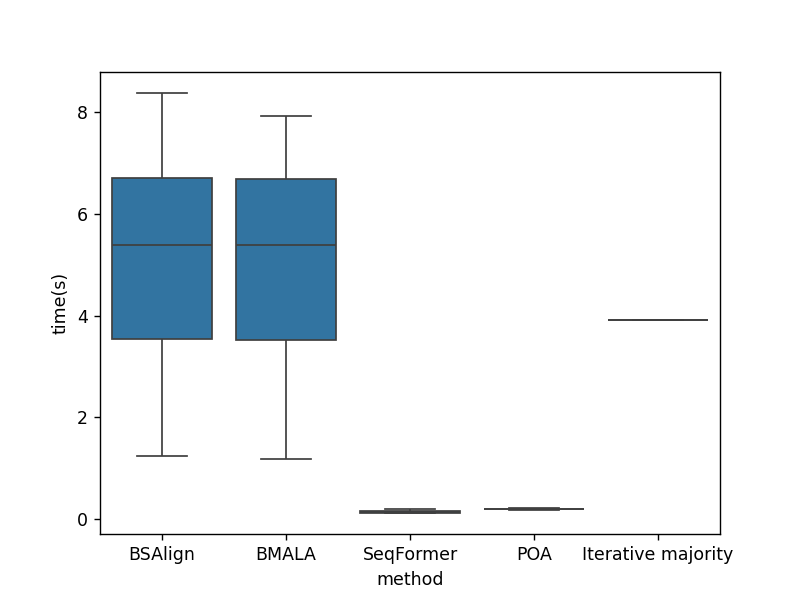

<Axes: xlabel='method', ylabel='time(s)'>

In [17]:
plt.figure()
sns.boxplot(data=runtime_df, x='method', y='time(s)', showfliers=False)

In [18]:
stat_df

,method,dis,depth,cluster
0,SeqFormer,0,5,0
1,POA,1,5,0
2,BSAlign,1,5,0
3,BMALA,5,5,0
4,Iterative majority,0,5,0
...,...,...,...,...
287905,SeqFormer,0,25,2741
287906,POA,0,25,2741
287907,BSAlign,0,25,2741
287908,BMALA,0,25,2741


In [19]:
result_df = (
    stat_df.groupby(['method', 'depth'])
      .agg(
          cluster_count=('cluster', 'nunique'),           # unique clusters
          zero_distance_count=('dis', lambda x: (x == 0).sum()),  # count of zero distance
          sum_distance=('dis', 'sum')                    # sum of distances
      )
      .reset_index()
)
result_df['success_rate'] = result_df['zero_distance_count'] / result_df['cluster_count']
result_df['mean_distance'] = result_df['sum_distance'] / result_df['cluster_count']

In [20]:
result_df

,method,depth,cluster_count,zero_distance_count,sum_distance,success_rate,mean_distance
0,BMALA,5,2742,276,29348,0.100656,10.703136
1,BMALA,6,2742,345,24185,0.125821,8.820204
2,BMALA,7,2742,585,18694,0.213348,6.817651
3,BMALA,8,2742,714,16173,0.260394,5.898249
4,BMALA,9,2742,964,12726,0.351568,4.641138
...,...,...,...,...,...,...,...
100,SeqFormer,21,2742,2678,65,0.976659,0.023705
101,SeqFormer,22,2742,2673,71,0.974836,0.025894
102,SeqFormer,23,2742,2683,60,0.978483,0.021882
103,SeqFormer,24,2742,2682,61,0.978118,0.022247


In [21]:
result_df[['method', 'depth', 'mean_distance', 'success_rate']].to_csv('bench_result_nanopore_v2.csv', sep=',', index=False)

In [22]:
result_df.groupby(['method']).agg(mean_success=('success_rate', 'mean')).reset_index()

,method,mean_success
0,BMALA,0.531399
1,BSAlign,0.700931
2,Iterative majority,0.906551
3,POA,0.696311
4,SeqFormer,0.930048


<IPython.core.display.Javascript object>


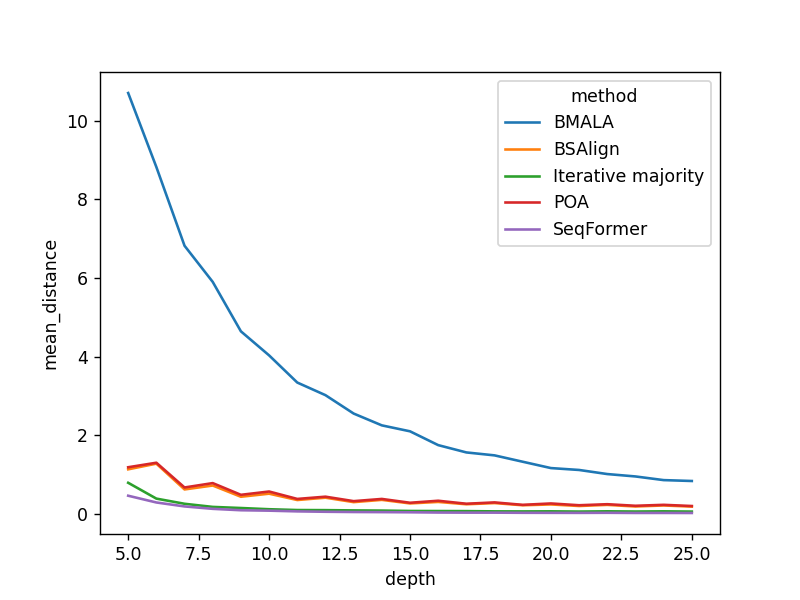

<Axes: xlabel='depth', ylabel='mean_distance'>

In [23]:
plt.figure()
sns.lineplot(data=result_df, x='depth', y='mean_distance', hue='method')

<IPython.core.display.Javascript object>


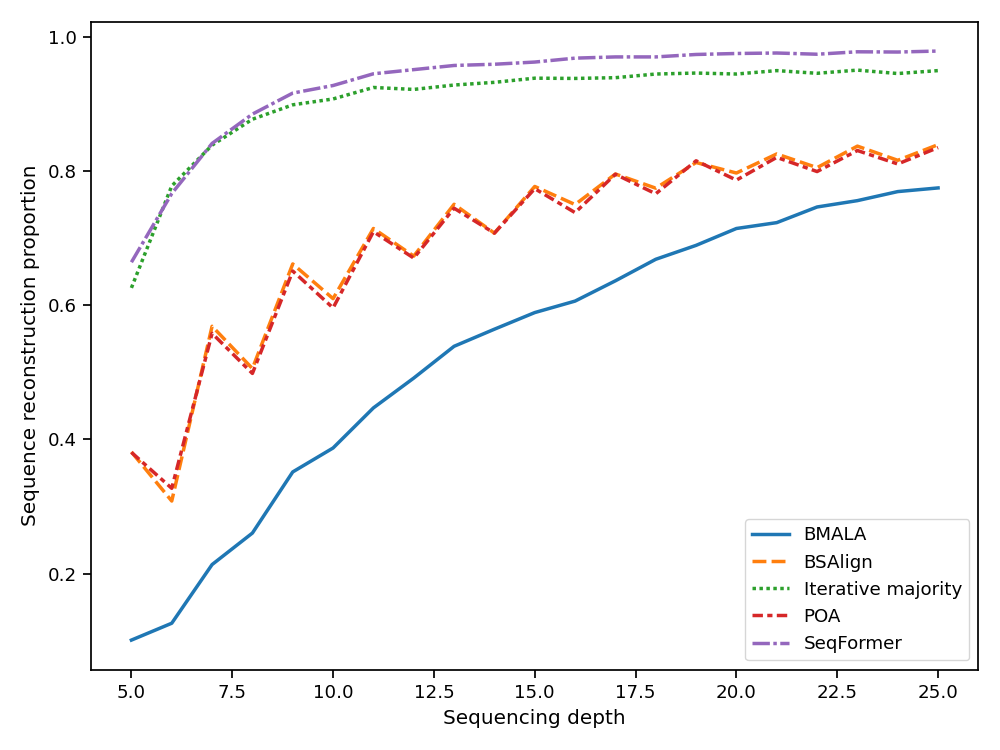

In [24]:
plt.figure(figsize=(8, 6))
sns.set_context("paper", font_scale=1.2)
sns.lineplot(data=result_df, x='depth', y='success_rate', hue='method', style="method", lw=2)
plt.legend(loc='best',)
plt.xlabel('Sequencing depth')
plt.ylabel('Sequence reconstruction proportion')
plt.tight_layout()
plt.savefig('nanopore_reco_bench_v2.png', dpi=400)

In [25]:
with open("model_bench_nanopore_v2_all.pkl", "wb") as f:
    pickle.dump(ont_ret_dict, f)